In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import pydotplus
from IPython.display import Image, HTML
from six import StringIO
from ipywidgets import interact, FloatSlider
from dtreeviz.trees import *

# データセット分割
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
)

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import (
    VarianceThreshold,
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# models
from lightgbm import LGBMClassifier
import xgboost as xgb

# XAI
import shap

import warnings


# config python file
import config

SEED = config.SEED
INDEX_MICROARRAY = config.INDEX_MICROARRAY
from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [2]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

# 最適化(all data)

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

In [4]:
optim_values_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR + "/microarray_optim_values.pickle"
)
optim_params_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR + "/microarray_optim_params.pickle"
)
dict_optim_values = (
    pickle_load(optim_values_path) if os.path.exists(optim_values_path) else {}
)

dict_optim_params = (
    pickle_load(optim_params_path) if os.path.exists(optim_params_path) else {}
)
dict_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]] = dict()
dict_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]] = dict()

## Optuna

### Random Forest

In [7]:
def objective(trial):
    # ランダムフォレストのパラメータチューニング
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 50, log=True),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 100),
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = RandomForestClassifier(**params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(
        clf, X_train, y_train, n_jobs=-1, cv=10, scoring=make_scorer(f1_score)
    )
    return score.mean()


dict_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"] = dict()
dict_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"] = dict()

study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
)
study.optimize(objective, n_trials=100, show_progress_bar=True)
dict_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"][
    config.THRESHOLD_YEAR
] = study.best_trial.values
dict_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"][
    config.THRESHOLD_YEAR
] = study.best_trial.params

[I 2022-09-20 13:56:45,131] A new study created in memory with name: no-name-bd308b2a-effb-44a5-8c8c-48525312f884


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-20 13:56:47,588] Trial 0 finished with value: 0.73761839754221 and parameters: {'n_estimators': 548, 'max_depth': 4, 'max_leaf_nodes': 44}. Best is trial 0 with value: 0.73761839754221.
[I 2022-09-20 13:56:49,790] Trial 1 finished with value: 0.7158790545918869 and parameters: {'n_estimators': 847, 'max_depth': 2, 'max_leaf_nodes': 14}. Best is trial 0 with value: 0.73761839754221.
[I 2022-09-20 13:56:51,607] Trial 2 finished with value: 0.7442350338072542 and parameters: {'n_estimators': 674, 'max_depth': 27, 'max_leaf_nodes': 15}. Best is trial 2 with value: 0.7442350338072542.
[I 2022-09-20 13:56:53,544] Trial 3 finished with value: 0.7491242266568306 and parameters: {'n_estimators': 579, 'max_depth': 34, 'max_leaf_nodes': 22}. Best is trial 3 with value: 0.7491242266568306.
[I 2022-09-20 13:56:53,990] Trial 4 finished with value: 0.7087875516068863 and parameters: {'n_estimators': 193, 'max_depth': 2, 'max_leaf_nodes': 23}. Best is trial 3 with value: 0.7491242266568306.

### LogisticRegression

In [8]:
def objective(trial):
    # ランダムフォレストのパラメータチューニング
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-5, 1e5),
        "max_iter": 1000,
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = LogisticRegression(**params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(
        clf, X_train, y_train, n_jobs=-1, cv=10, scoring=make_scorer(f1_score)
    )
    return score.mean()


dict_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"] = dict()
dict_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"] = dict()

study = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED)
)
study.optimize(objective, n_trials=10)
dict_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"][
    config.THRESHOLD_YEAR
] = study.best_trial.values
dict_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"][
    config.THRESHOLD_YEAR
] = study.best_trial.params

[I 2022-09-20 14:00:23,576] A new study created in memory with name: no-name-51943253-4f06-438a-b9a8-1e2a2fcc7bf7
[W 2022-09-20 14:00:23,593] Trial 0 failed, because the objective function returned nan.
[W 2022-09-20 14:00:23,610] Trial 1 failed, because the objective function returned nan.
[I 2022-09-20 14:00:23,638] Trial 2 finished with value: 0.759381025747212 and parameters: {'penalty': 'l2', 'C': 13670.65897712823}. Best is trial 2 with value: 0.759381025747212.
[I 2022-09-20 14:00:23,665] Trial 3 finished with value: 0.759381025747212 and parameters: {'penalty': 'l2', 'C': 20920.212219626937}. Best is trial 2 with value: 0.759381025747212.
[W 2022-09-20 14:00:23,683] Trial 4 failed, because the objective function returned nan.
[W 2022-09-20 14:00:23,700] Trial 5 failed, because the objective function returned nan.
[W 2022-09-20 14:00:23,717] Trial 6 failed, because the objective function returned nan.
[W 2022-09-20 14:00:23,732] Trial 7 failed, because the objective function ret

### lightGBM

In [9]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "max_bin": trial.suggest_int("max_bin", 100, 300),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "class_weight": "balanced",
        "random_state": SEED,
    }
    clf = LGBMClassifier(boosting_type="gbdt", **params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=10)
    return score.mean()


dict_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"] = dict()
dict_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"] = dict()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)
dict_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"][
    config.THRESHOLD_YEAR
] = study.best_trial.values
dict_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"][
    config.THRESHOLD_YEAR
] = study.best_trial.params

[I 2022-09-20 14:00:24,734] A new study created in memory with name: no-name-fe85ca54-b769-486f-9063-10ac11b643fa


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-20 14:00:26,602] Trial 0 finished with value: 0.7352044907778669 and parameters: {'lambda_l1': 5.2650661682626334e-08, 'lambda_l2': 2.676685804656544e-07, 'max_bin': 205, 'num_leaves': 39, 'learning_rate': 0.020500314953950424, 'n_estimators': 410}. Best is trial 0 with value: 0.7352044907778669.
[I 2022-09-20 14:00:26,836] Trial 1 finished with value: 0.6462443197006149 and parameters: {'lambda_l1': 1.9611027454558388e-05, 'lambda_l2': 0.009859684973036029, 'max_bin': 156, 'num_leaves': 26, 'learning_rate': 0.0018371964532022608, 'n_estimators': 42}. Best is trial 0 with value: 0.7352044907778669.
[I 2022-09-20 14:00:27,492] Trial 2 finished with value: 0.7376369954557604 and parameters: {'lambda_l1': 0.04491901149457346, 'lambda_l2': 0.0011661959910222177, 'max_bin': 183, 'num_leaves': 22, 'learning_rate': 0.05163262200039377, 'n_estimators': 189}. Best is trial 2 with value: 0.7376369954557604.
[I 2022-09-20 14:00:28,729] Trial 3 finished with value: 0.7156375300721732 an

## save params dict as pickle

In [11]:
make_dir(config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR)
pickle_dump(
    dict_optim_values,
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR + "/microarray_optim_values.pickle",
)
pickle_dump(
    dict_optim_params,
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR + "/microarray_optim_params.pickle",
)

# 最適化(subtypes毎)

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

In [12]:
subtype_optim_values_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/microarray_subtype_optim_values.pickle"
)
subtype_optim_param_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/microarray_subtype_optim_params.pickle"
)

dict_subtype_optim_values = (
    pickle_load(subtype_optim_values_path)
    if os.path.exists(subtype_optim_values_path)
    else {}
)
dict_subtype_optim_params = (
    pickle_load(subtype_optim_param_path)
    if os.path.exists(subtype_optim_param_path)
    else {}
)

dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]] = dict()
dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]] = dict()

## RandomForest

In [33]:
def objective(trial):
    warnings.simplefilter("ignore")
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 50),
        "max_depth": trial.suggest_int("max_depth", 2, 50, log=True),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 100),
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample"]
        ),
        "random_state": SEED,
    }

    clf = RandomForestClassifier(**params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(clf, X_train_subtype, y_train_subtype, n_jobs=-1, cv=10)
    return score.mean()


optuna.logging.disable_default_handler()
warnings.simplefilter("ignore")
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]


dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"] = dict()
dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"] = dict()
for subtype in subtypes:
    dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"][
        subtype
    ] = dict()
    dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"][
        subtype
    ] = dict()
    prognosis_Xlabel = "X{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    prognosis_ylabel = "y{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    X_train_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_Xlabel]
    y_train_subtype = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_ylabel]
    assert (
        X_train_subtype.shape[0] == y_train_subtype.shape[0]
    ), "train size is incorrect"

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"][
        subtype
    ][config.THRESHOLD_YEAR] = study.best_trial.values
    dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["rf"][
        subtype
    ][config.THRESHOLD_YEAR] = study.best_trial.params

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-20 14:52:56,630] Trial 0 finished with value: 0.5625 and parameters: {'n_estimators': 276, 'min_samples_split': 9, 'min_samples_leaf': 49, 'max_depth': 10, 'max_leaf_nodes': 6, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.5625.
[I 2022-09-20 14:52:57,884] Trial 1 finished with value: 0.8 and parameters: {'n_estimators': 451, 'min_samples_split': 47, 'min_samples_leaf': 10, 'max_depth': 6, 'max_leaf_nodes': 50, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8.
[I 2022-09-20 14:52:58,718] Trial 2 finished with value: 0.5625 and parameters: {'n_estimators': 555, 'min_samples_split': 7, 'min_samples_leaf': 37, 'max_depth': 9, 'max_leaf_nodes': 27, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.8.
[I 2022-09-20 14:52:59,174] Trial 3 finished with value: 0.8111111111111111 and parameters: {'n_estimators': 294, 'min_samples_split': 31, 'min_samples_leaf': 11, 'max_depth': 2, 'max_leaf_nodes': 82, 'class_weight': 'balanced_su

[I 2022-09-20 14:53:58,311] A new study created in memory with name: no-name-a0d3f535-ec2f-4838-9567-4320aeafd810


[I 2022-09-20 14:53:58,308] Trial 99 finished with value: 0.8 and parameters: {'n_estimators': 326, 'min_samples_split': 26, 'min_samples_leaf': 5, 'max_depth': 41, 'max_leaf_nodes': 49, 'class_weight': 'balanced'}. Best is trial 62 with value: 0.8333333333333333.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-20 14:53:59,142] Trial 0 finished with value: 0.7228835978835978 and parameters: {'n_estimators': 429, 'min_samples_split': 33, 'min_samples_leaf': 50, 'max_depth': 40, 'max_leaf_nodes': 44, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7228835978835978.
[I 2022-09-20 14:53:59,865] Trial 1 finished with value: 0.7411375661375661 and parameters: {'n_estimators': 448, 'min_samples_split': 39, 'min_samples_leaf': 39, 'max_depth': 2, 'max_leaf_nodes': 19, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.7411375661375661.
[I 2022-09-20 14:54:00,699] Trial 2 finished with value: 0.7448412698412699 and parameters: {'n_estimators': 486, 'min_samples_split': 26, 'min_samples_leaf': 20, 'max_depth': 36, 'max_leaf_nodes': 35, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.7448412698412699.
[I 2022-09-20 14:54:01,012] Trial 3 finished with value: 0.741005291005291 and parameters: {'n_estimators': 164, 'min_samples_split': 43, 'min_samples_lea

[I 2022-09-20 14:56:14,591] A new study created in memory with name: no-name-a43f5aa0-a94b-4d24-81d9-52b34d1524cf


[I 2022-09-20 14:56:14,588] Trial 99 finished with value: 0.751984126984127 and parameters: {'n_estimators': 977, 'min_samples_split': 6, 'min_samples_leaf': 32, 'max_depth': 13, 'max_leaf_nodes': 86, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.7593915343915344.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-20 14:56:14,721] Trial 0 finished with value: 0.7800865800865802 and parameters: {'n_estimators': 63, 'min_samples_split': 24, 'min_samples_leaf': 50, 'max_depth': 12, 'max_leaf_nodes': 32, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7800865800865802.
[I 2022-09-20 14:56:14,849] Trial 1 finished with value: 0.8030303030303031 and parameters: {'n_estimators': 69, 'min_samples_split': 21, 'min_samples_leaf': 12, 'max_depth': 32, 'max_leaf_nodes': 86, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8030303030303031.
[I 2022-09-20 14:56:16,746] Trial 2 finished with value: 0.8127705627705628 and parameters: {'n_estimators': 997, 'min_samples_split': 14, 'min_samples_leaf': 21, 'max_depth': 3, 'max_leaf_nodes': 21, 'class_weight': 'balanced_subsample'}. Best is trial 2 with value: 0.8127705627705628.
[I 2022-09-20 14:56:17,224] Trial 3 finished with value: 0.8077922077922078 and parameters: {'n_estimators': 242, 'min_samples_split': 33, 'min_samples_leaf

[I 2022-09-20 14:57:27,148] A new study created in memory with name: no-name-8547ce51-5538-4495-8fab-a5b2c99d04d5


[I 2022-09-20 14:57:27,146] Trial 99 finished with value: 0.827056277056277 and parameters: {'n_estimators': 509, 'min_samples_split': 9, 'min_samples_leaf': 25, 'max_depth': 10, 'max_leaf_nodes': 66, 'class_weight': 'balanced'}. Best is trial 61 with value: 0.8318181818181818.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-20 14:57:27,367] Trial 0 finished with value: 0.8192307692307692 and parameters: {'n_estimators': 99, 'min_samples_split': 44, 'min_samples_leaf': 15, 'max_depth': 6, 'max_leaf_nodes': 32, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8192307692307692.
[I 2022-09-20 14:57:28,685] Trial 1 finished with value: 0.8442307692307691 and parameters: {'n_estimators': 875, 'min_samples_split': 29, 'min_samples_leaf': 28, 'max_depth': 3, 'max_leaf_nodes': 89, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8442307692307691.
[I 2022-09-20 14:57:29,756] Trial 2 finished with value: 0.3198717948717949 and parameters: {'n_estimators': 602, 'min_samples_split': 48, 'min_samples_leaf': 42, 'max_depth': 20, 'max_leaf_nodes': 99, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.8442307692307691.
[I 2022-09-20 14:57:30,014] Trial 3 finished with value: 0.8275641025641025 and parameters: {'n_estimators': 125, 'min_samples_split': 24, 'min_sa

[I 2022-09-20 14:59:33,349] A new study created in memory with name: no-name-65a4e332-bb44-42b4-a6e9-8f674bea01bc


[I 2022-09-20 14:59:33,346] Trial 99 finished with value: 0.8525641025641025 and parameters: {'n_estimators': 799, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_depth': 11, 'max_leaf_nodes': 16, 'class_weight': 'balanced_subsample'}. Best is trial 64 with value: 0.8858974358974357.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-20 14:59:34,670] Trial 0 finished with value: 0.8633333333333333 and parameters: {'n_estimators': 907, 'min_samples_split': 6, 'min_samples_leaf': 16, 'max_depth': 2, 'max_leaf_nodes': 71, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8633333333333333.
[I 2022-09-20 14:59:34,798] Trial 1 finished with value: 0.4966666666666667 and parameters: {'n_estimators': 75, 'min_samples_split': 24, 'min_samples_leaf': 22, 'max_depth': 2, 'max_leaf_nodes': 99, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8633333333333333.
[I 2022-09-20 14:59:34,988] Trial 2 finished with value: 0.43 and parameters: {'n_estimators': 101, 'min_samples_split': 15, 'min_samples_leaf': 34, 'max_depth': 17, 'max_leaf_nodes': 44, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.8633333333333333.
[I 2022-09-20 14:59:35,526] Trial 3 finished with value: 0.57 and parameters: {'n_estimators': 351, 'min_samples_split': 30, 'min_samples_leaf': 31, 'max_depth': 11, 'max_

[I 2022-09-20 15:01:26,531] A new study created in memory with name: no-name-aad1289c-57a7-4763-a9c2-ab36be909aeb


[I 2022-09-20 15:01:26,528] Trial 99 finished with value: 0.8433333333333334 and parameters: {'n_estimators': 642, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_depth': 41, 'max_leaf_nodes': 13, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.8966666666666667.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-20 15:01:27,622] Trial 0 finished with value: 0.6854545454545455 and parameters: {'n_estimators': 585, 'min_samples_split': 12, 'min_samples_leaf': 24, 'max_depth': 3, 'max_leaf_nodes': 98, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.6854545454545455.
[I 2022-09-20 15:01:28,856] Trial 1 finished with value: 0.609090909090909 and parameters: {'n_estimators': 846, 'min_samples_split': 31, 'min_samples_leaf': 42, 'max_depth': 30, 'max_leaf_nodes': 42, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6854545454545455.
[I 2022-09-20 15:01:29,191] Trial 2 finished with value: 0.609090909090909 and parameters: {'n_estimators': 220, 'min_samples_split': 13, 'min_samples_leaf': 43, 'max_depth': 10, 'max_leaf_nodes': 49, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6854545454545455.
[I 2022-09-20 15:01:30,241] Trial 3 finished with value: 0.6854545454545455 and parameters: {'n_estimators': 564, 'min_samples_split': 29, 'min_samples_leaf

check optuna's effect 

claudin-low


accuracy     0.600000
precision    0.500000
recall       0.250000
f1 score     0.333333
dtype: float64

LumA


accuracy     0.741935
precision    0.714286
recall       0.454545
f1 score     0.555556
dtype: float64

LumB


accuracy     0.666667
precision    0.700000
recall       0.875000
f1 score     0.777778
dtype: float64

Her2


accuracy     0.714286
precision    0.692308
recall       1.000000
f1 score     0.818182
dtype: float64

Normal


accuracy     0.857143
precision    0.800000
recall       1.000000
f1 score     0.888889
dtype: float64

Basal


accuracy     0.583333
precision    0.583333
recall       1.000000
f1 score     0.736842
dtype: float64

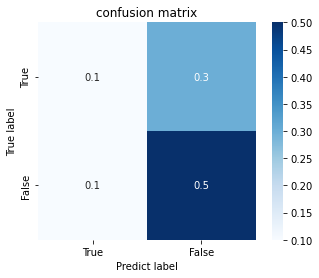

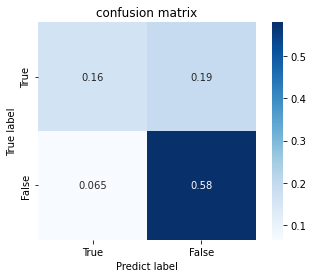

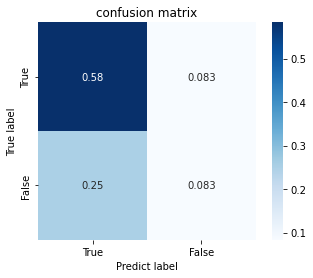

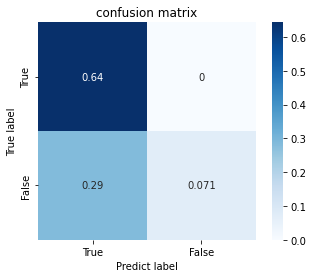

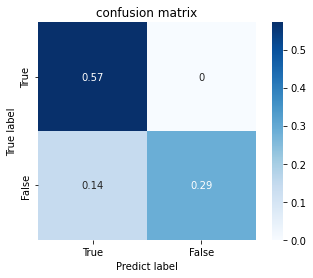

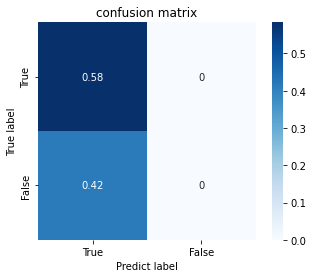

In [43]:
for subtype in subtypes:
    print(subtype)
    prognosis_Xlabel = "X{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    prognosis_ylabel = "y{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    X_train_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_Xlabel]
    y_train_subtype = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_ylabel]
    X_val_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["val"][prognosis_Xlabel]
    y_val_subtype = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["val"][prognosis_ylabel]

    assert X_val_subtype.shape[0] == y_val_subtype.shape[0], "train size is incorrect"

    rf = RandomForestClassifier(
        min_samples_split=20, min_samples_leaf=15, random_state=SEED
    )
    rf.fit(X_train_subtype, y_train_subtype)
    y_pred_subtype = rf.predict(X_val_subtype)
    show_scores(y_val_subtype, y_pred_subtype)
    plot_confusion_matrix(y_val_subtype, y_pred_subtype)

claudin-low


accuracy     0.40
precision    0.25
recall       0.25
f1 score     0.25
dtype: float64

LumA


accuracy     0.580645
precision    0.416667
recall       0.454545
f1 score     0.434783
dtype: float64

LumB


accuracy     0.625000
precision    0.733333
recall       0.687500
f1 score     0.709677
dtype: float64

Her2


accuracy     0.500000
precision    0.666667
recall       0.444444
f1 score     0.533333
dtype: float64

Normal


accuracy     0.714286
precision    0.750000
recall       0.750000
f1 score     0.750000
dtype: float64

Basal


accuracy     0.500000
precision    0.555556
recall       0.714286
f1 score     0.625000
dtype: float64

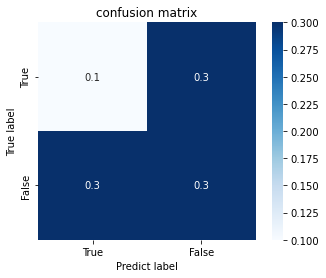

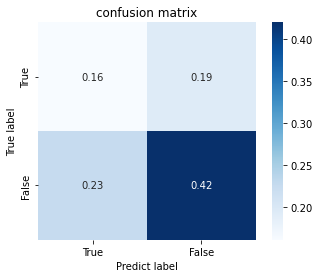

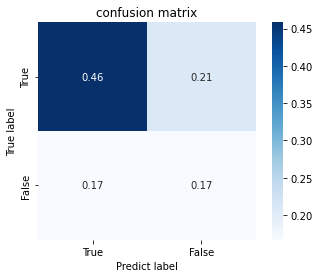

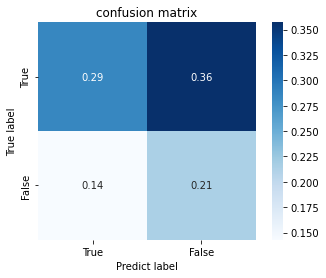

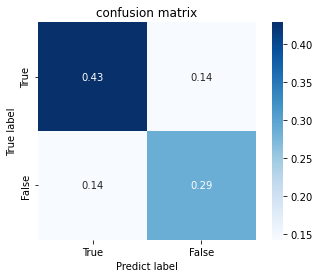

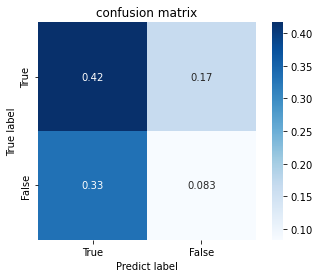

In [44]:
for subtype in subtypes:
    print(subtype)
    prognosis_Xlabel = "X{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    prognosis_ylabel = "y{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    X_train_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_Xlabel]
    y_train_subtype = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_ylabel]
    X_val_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["val"][prognosis_Xlabel]
    y_val_subtype = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["val"][prognosis_ylabel]

    assert X_val_subtype.shape[0] == y_val_subtype.shape[0], "train size is incorrect"

    params = dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "rf"
    ][subtype][config.THRESHOLD_YEAR]
    params["random_state"] = SEED
    rf = RandomForestClassifier()
    rf.set_params(**params)
    rf.fit(X_train_subtype, y_train_subtype)
    y_pred_subtype = rf.predict(X_val_subtype)
    show_scores(y_val_subtype, y_pred_subtype)
    plot_confusion_matrix(y_val_subtype, y_pred_subtype)

## LogitsticRegression

In [92]:
def objective(trial):
    warnings.simplefilter("ignore")
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-5, 1e5),
        "max_iter": 1000,
        "class_weight": "balanced",
        "random_state": SEED,
    }

    clf = LogisticRegression(**params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(clf, X_train_subtype, y_train_subtype, n_jobs=-1, cv=10)
    return score.mean()


optuna.logging.disable_default_handler()
warnings.simplefilter("ignore")
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]
dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"] = dict()
dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"] = dict()


for subtype in subtypes:
    print("----------" * 10)
    print(subtype)
    dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"][
        subtype
    ] = dict()
    dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"][
        subtype
    ] = dict()
    prognosis_Xlabel = "X{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    prognosis_ylabel = "y{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    X_train_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_Xlabel]
    y_train_subtype = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_ylabel]
    assert (
        X_train_subtype.shape[0] == y_train_subtype.shape[0]
    ), "train size is incorrect"

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"][
        subtype
    ][config.THRESHOLD_YEAR] = study.best_trial.values
    dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lr"][
        subtype
    ][config.THRESHOLD_YEAR] = study.best_trial.params

=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
claudin-low


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2022-09-14 09:45:55,846] Trial 0 failed, because the objective function returned nan.
[I 2022-09-14 09:45:55,864] Trial 1 finished with value: 0.8777777777777779 and parameters: {'penalty': 'l2', 'C': 29574.76829504445}. Best is trial 1 with value: 0.8777777777777779.
[W 2022-09-14 09:45:55,876] Trial 2 failed, because the objective function returned nan.
[W 2022-09-14 09:45:55,889] Trial 3 failed, because the objective function returned nan.
[I 2022-09-14 09:45:55,908] Trial 4 finished with value: 0.8777777777777779 and parameters: {'penalty': 'l2', 'C': 1381.8206006217147}. Best is trial 1 with value: 0.8777777777777779.
[W 2022-09-14 09:45:55,920] Trial 5 failed, because the objective function returned nan.
[W 2022-09-14 09:45:55,934] Trial 6 failed, because the objective function returned nan.
[W 2022-09-14 09:45:55,945] Trial 7 failed, because the objective function returned nan.
[W 2022-09-14 09:45:55,957] Trial 8 failed, because the objective function returned nan.
[W 2022-09

[I 2022-09-14 09:45:57,337] A new study created in memory with name: no-name-e43fe8d1-7a1c-4ed6-a005-2642931848b3


[W 2022-09-14 09:45:57,335] Trial 99 failed, because the objective function returned nan.
----------------------------------------------------------------------------------------------------
LumA


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2022-09-14 09:45:57,365] Trial 0 failed, because the objective function returned nan.
[W 2022-09-14 09:45:57,377] Trial 1 failed, because the objective function returned nan.
[W 2022-09-14 09:45:57,389] Trial 2 failed, because the objective function returned nan.
[W 2022-09-14 09:45:57,400] Trial 3 failed, because the objective function returned nan.
[I 2022-09-14 09:45:57,418] Trial 4 finished with value: 0.7925925925925925 and parameters: {'penalty': 'l2', 'C': 44150.91132526713}. Best is trial 4 with value: 0.7925925925925925.
[I 2022-09-14 09:45:57,436] Trial 5 finished with value: 0.7925925925925925 and parameters: {'penalty': 'l2', 'C': 23892.776654009605}. Best is trial 4 with value: 0.7925925925925925.
[W 2022-09-14 09:45:57,448] Trial 6 failed, because the objective function returned nan.
[I 2022-09-14 09:45:57,469] Trial 7 finished with value: 0.7925925925925925 and parameters: {'penalty': 'l2', 'C': 17258.71306087923}. Best is trial 4 with value: 0.7925925925925925.
[W 20

[I 2022-09-14 09:45:58,889] A new study created in memory with name: no-name-c9fd8e4d-62fa-4b50-a5f6-4270cef5615e


[W 2022-09-14 09:45:58,855] Trial 97 failed, because the objective function returned nan.
[W 2022-09-14 09:45:58,873] Trial 98 failed, because the objective function returned nan.
[W 2022-09-14 09:45:58,886] Trial 99 failed, because the objective function returned nan.
----------------------------------------------------------------------------------------------------
LumB


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-14 09:45:58,925] Trial 0 finished with value: 0.8547619047619047 and parameters: {'penalty': 'l2', 'C': 14691.141242795844}. Best is trial 0 with value: 0.8547619047619047.
[W 2022-09-14 09:45:58,936] Trial 1 failed, because the objective function returned nan.
[W 2022-09-14 09:45:58,948] Trial 2 failed, because the objective function returned nan.
[I 2022-09-14 09:45:58,967] Trial 3 finished with value: 0.8547619047619047 and parameters: {'penalty': 'l2', 'C': 25261.292376773872}. Best is trial 0 with value: 0.8547619047619047.
[W 2022-09-14 09:45:58,980] Trial 4 failed, because the objective function returned nan.
[I 2022-09-14 09:45:59,000] Trial 5 finished with value: 0.8547619047619047 and parameters: {'penalty': 'l2', 'C': 38432.07069529375}. Best is trial 0 with value: 0.8547619047619047.
[I 2022-09-14 09:45:59,022] Trial 6 finished with value: 0.8547619047619047 and parameters: {'penalty': 'l2', 'C': 50118.9655751286}. Best is trial 0 with value: 0.8547619047619047.


[I 2022-09-14 09:46:00,471] A new study created in memory with name: no-name-693f6fb3-75f0-4a97-9119-3db66c8af244


[W 2022-09-14 09:46:00,453] Trial 98 failed, because the objective function returned nan.
[W 2022-09-14 09:46:00,469] Trial 99 failed, because the objective function returned nan.
----------------------------------------------------------------------------------------------------
Her2


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-14 09:46:00,508] Trial 0 finished with value: 0.8839743589743589 and parameters: {'penalty': 'l2', 'C': 22175.449121128135}. Best is trial 0 with value: 0.8839743589743589.
[W 2022-09-14 09:46:00,519] Trial 1 failed, because the objective function returned nan.
[W 2022-09-14 09:46:00,530] Trial 2 failed, because the objective function returned nan.
[I 2022-09-14 09:46:00,550] Trial 3 finished with value: 0.8839743589743589 and parameters: {'penalty': 'l2', 'C': 33895.18031117087}. Best is trial 0 with value: 0.8839743589743589.
[I 2022-09-14 09:46:00,571] Trial 4 finished with value: 0.8839743589743589 and parameters: {'penalty': 'l2', 'C': 24954.387881473835}. Best is trial 0 with value: 0.8839743589743589.
[I 2022-09-14 09:46:00,592] Trial 5 finished with value: 0.8846153846153847 and parameters: {'penalty': 'l2', 'C': 92068.48041010021}. Best is trial 5 with value: 0.8846153846153847.
[I 2022-09-14 09:46:00,612] Trial 6 finished with value: 0.8839743589743589 and paramete

[I 2022-09-14 09:46:02,049] A new study created in memory with name: no-name-7c5383a9-90e1-4df5-86ee-a844991f9d74


[W 2022-09-14 09:46:02,045] Trial 99 failed, because the objective function returned nan.
----------------------------------------------------------------------------------------------------
Normal


  0%|          | 0/100 [00:00<?, ?it/s]

[W 2022-09-14 09:46:02,085] Trial 0 failed, because the objective function returned nan.
[W 2022-09-14 09:46:02,096] Trial 1 failed, because the objective function returned nan.
[W 2022-09-14 09:46:02,109] Trial 2 failed, because the objective function returned nan.
[W 2022-09-14 09:46:02,121] Trial 3 failed, because the objective function returned nan.
[W 2022-09-14 09:46:02,134] Trial 4 failed, because the objective function returned nan.
[W 2022-09-14 09:46:02,146] Trial 5 failed, because the objective function returned nan.
[W 2022-09-14 09:46:02,157] Trial 6 failed, because the objective function returned nan.
[W 2022-09-14 09:46:02,171] Trial 7 failed, because the objective function returned nan.
[W 2022-09-14 09:46:02,182] Trial 8 failed, because the objective function returned nan.
[I 2022-09-14 09:46:02,200] Trial 9 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 86391.59584084364}. Best is trial 9 with value: 1.0.
[W 2022-09-14 09:46:02,212] Trial 10 failed, b

[I 2022-09-14 09:46:03,542] A new study created in memory with name: no-name-1d4cb39f-38ab-44f9-8658-686b81f63619


[W 2022-09-14 09:46:03,541] Trial 99 failed, because the objective function returned nan.
----------------------------------------------------------------------------------------------------
Basal


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-14 09:46:03,577] Trial 0 finished with value: 0.8454545454545455 and parameters: {'penalty': 'l2', 'C': 61226.78211720135}. Best is trial 0 with value: 0.8454545454545455.
[W 2022-09-14 09:46:03,588] Trial 1 failed, because the objective function returned nan.
[I 2022-09-14 09:46:03,606] Trial 2 finished with value: 0.8454545454545455 and parameters: {'penalty': 'l2', 'C': 64128.073324100355}. Best is trial 0 with value: 0.8454545454545455.
[W 2022-09-14 09:46:03,617] Trial 3 failed, because the objective function returned nan.
[W 2022-09-14 09:46:03,630] Trial 4 failed, because the objective function returned nan.
[I 2022-09-14 09:46:03,648] Trial 5 finished with value: 0.8454545454545455 and parameters: {'penalty': 'l2', 'C': 32420.829144535233}. Best is trial 0 with value: 0.8454545454545455.
[W 2022-09-14 09:46:03,661] Trial 6 failed, because the objective function returned nan.
[W 2022-09-14 09:46:03,671] Trial 7 failed, because the objective function returned nan.
[W 2

## lightGBM

In [14]:
def objective(trial):
    warnings.simplefilter("ignore")
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "max_bin": trial.suggest_int("max_bin", 100, 300),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "class_weight": "balanced",
        "random_state": SEED,
    }
    clf = LGBMClassifier(boosting_type="gbdt", **params)
    # 10分割交差検証によるテストデータのaccuracyの出力
    score = cross_val_score(clf, X_train_subtype, y_train_subtype, n_jobs=-1, cv=10)
    return score.mean()


optuna.logging.disable_default_handler()
warnings.simplefilter("ignore")
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Her2",
    "Normal",
    "Basal",
]
dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"] = dict()
dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"] = dict()


for subtype in tqdm(subtypes):
    print("----------" * 10)
    print(subtype)
    dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"][
        subtype
    ] = dict()
    dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"][
        subtype
    ] = dict()
    prognosis_Xlabel = "X{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    prognosis_ylabel = "y{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
    X_train_subtype = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_Xlabel]
    y_train_subtype = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]][
        "claudin_subtype"
    ]["mrmr"]["train"][prognosis_ylabel]
    assert (
        X_train_subtype.shape[0] == y_train_subtype.shape[0]
    ), "train size is incorrect"

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    dict_subtype_optim_values[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"][
        subtype
    ][config.THRESHOLD_YEAR] = study.best_trial.values
    dict_subtype_optim_params[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["lgb"][
        subtype
    ][config.THRESHOLD_YEAR] = study.best_trial.params

=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
claudin-low


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|                                                                                            | 0/6 [00:01<?, ?it/s]

[I 2022-09-20 14:08:49,555] Trial 0 finished with value: 0.8222222222222223 and parameters: {'lambda_l1': 3.7229946901344946e-06, 'lambda_l2': 0.000549751062563644, 'max_bin': 242, 'num_leaves': 45, 'learning_rate': 0.02702884283622796, 'n_estimators': 329}. Best is trial 0 with value: 0.8222222222222223.


  0%|                                                                                            | 0/6 [00:02<?, ?it/s]

[I 2022-09-20 14:08:50,170] Trial 1 finished with value: 0.8222222222222222 and parameters: {'lambda_l1': 1.2451721233133255, 'lambda_l2': 0.00237625541839867, 'max_bin': 276, 'num_leaves': 32, 'learning_rate': 0.0124845296729276, 'n_estimators': 694}. Best is trial 0 with value: 0.8222222222222223.
[I 2022-09-20 14:08:50,259] Trial 2 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 6.62833901125759e-05, 'lambda_l2': 7.575809127169587e-08, 'max_bin': 225, 'num_leaves': 44, 'learning_rate': 0.010243645037422141, 'n_estimators': 793}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:50,280] Trial 3 finished with value: 0.7305555555555555 and parameters: {'lambda_l1': 0.4110097286623569, 'lambda_l2': 1.616678588696739e-05, 'max_bin': 251, 'num_leaves': 28, 'learning_rate': 0.013701959643975012, 'n_estimators': 62}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:50,305] Trial 4 finished with value: 0.6861111111111111 and paramete

  0%|                                                                                            | 0/6 [00:02<?, ?it/s]

[I 2022-09-20 14:08:50,469] Trial 6 finished with value: 0.8222222222222223 and parameters: {'lambda_l1': 1.9036789154087545e-05, 'lambda_l2': 8.672876827017482e-07, 'max_bin': 218, 'num_leaves': 48, 'learning_rate': 0.03642011887247413, 'n_estimators': 985}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:50,523] Trial 7 finished with value: 0.6972222222222222 and parameters: {'lambda_l1': 0.0008138805233223249, 'lambda_l2': 9.537279063740936, 'max_bin': 109, 'num_leaves': 49, 'learning_rate': 0.0034777009289397747, 'n_estimators': 415}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:50,603] Trial 8 finished with value: 0.7305555555555555 and parameters: {'lambda_l1': 0.0021610174689619998, 'lambda_l2': 0.8241325914936711, 'max_bin': 201, 'num_leaves': 43, 'learning_rate': 0.002029622711562461, 'n_estimators': 852}. Best is trial 2 with value: 0.8333333333333334.


  0%|                                                                                            | 0/6 [00:02<?, ?it/s]

[I 2022-09-20 14:08:50,697] Trial 9 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 0.0036305846526999497, 'lambda_l2': 3.025671797820567e-05, 'max_bin': 213, 'num_leaves': 43, 'learning_rate': 0.004428321676383421, 'n_estimators': 946}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:50,783] Trial 10 finished with value: 0.8 and parameters: {'lambda_l1': 1.5890116462312938e-06, 'lambda_l2': 1.0576443243329842e-08, 'max_bin': 148, 'num_leaves': 38, 'learning_rate': 0.08853001201477538, 'n_estimators': 641}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:50,853] Trial 11 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 8.694482936490963e-06, 'lambda_l2': 2.7451895874879062e-08, 'max_bin': 157, 'num_leaves': 41, 'learning_rate': 0.026874423077911113, 'n_estimators': 337}. Best is trial 2 with value: 0.8333333333333334.


  0%|                                                                                            | 0/6 [00:02<?, ?it/s]

[I 2022-09-20 14:08:50,904] Trial 12 finished with value: 0.8222222222222223 and parameters: {'lambda_l1': 2.8856814499988674e-05, 'lambda_l2': 1.5908286572991866e-08, 'max_bin': 161, 'num_leaves': 21, 'learning_rate': 0.028372558062808, 'n_estimators': 245}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:50,985] Trial 13 finished with value: 0.8 and parameters: {'lambda_l1': 4.5900528496548756e-07, 'lambda_l2': 3.612089503446321e-07, 'max_bin': 168, 'num_leaves': 39, 'learning_rate': 0.007364120618047281, 'n_estimators': 471}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:51,080] Trial 14 finished with value: 0.8333333333333333 and parameters: {'lambda_l1': 0.00011934438063800113, 'lambda_l2': 4.97450689365133e-07, 'max_bin': 111, 'num_leaves': 39, 'learning_rate': 0.07256555906904354, 'n_estimators': 796}. Best is trial 2 with value: 0.8333333333333334.


  0%|                                                                                            | 0/6 [00:03<?, ?it/s]

[I 2022-09-20 14:08:51,143] Trial 15 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 7.836361556262835e-08, 'lambda_l2': 8.22369842732884e-08, 'max_bin': 178, 'num_leaves': 45, 'learning_rate': 0.015315342825229974, 'n_estimators': 256}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:51,220] Trial 16 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 0.14957331254560208, 'lambda_l2': 5.898947336707337e-06, 'max_bin': 139, 'num_leaves': 41, 'learning_rate': 0.007345811200076224, 'n_estimators': 572}. Best is trial 2 with value: 0.8333333333333334.
[I 2022-09-20 14:08:51,324] Trial 17 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 1.1097507132109844e-08, 'lambda_l2': 0.030448117246606073, 'max_bin': 297, 'num_leaves': 50, 'learning_rate': 0.05045188573305594, 'n_estimators': 777}. Best is trial 2 with value: 0.8333333333333334.


  0%|                                                                                            | 0/6 [00:03<?, ?it/s]

[I 2022-09-20 14:08:51,397] Trial 18 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 7.163915388228849e-05, 'lambda_l2': 2.8001218201614983e-06, 'max_bin': 193, 'num_leaves': 36, 'learning_rate': 0.02145990009656736, 'n_estimators': 529}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:51,481] Trial 19 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 0.00015226195183926677, 'lambda_l2': 1.9555817741813783e-06, 'max_bin': 189, 'num_leaves': 31, 'learning_rate': 0.01911896998899936, 'n_estimators': 541}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:51,546] Trial 20 finished with value: 0.5041666666666667 and parameters: {'lambda_l1': 9.571681032831316, 'lambda_l2': 2.5199938915229255e-06, 'max_bin': 185, 'num_leaves': 29, 'learning_rate': 0.018934977238210825, 'n_estimators': 520}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:03<?, ?it/s]

[I 2022-09-20 14:08:51,633] Trial 21 finished with value: 0.8222222222222223 and parameters: {'lambda_l1': 0.00014757161063674303, 'lambda_l2': 1.7359289447356916e-07, 'max_bin': 227, 'num_leaves': 35, 'learning_rate': 0.00978999018238023, 'n_estimators': 568}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:51,723] Trial 22 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 0.024427905047281335, 'lambda_l2': 0.00010435860775582228, 'max_bin': 192, 'num_leaves': 25, 'learning_rate': 0.00620464083268623, 'n_estimators': 726}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:51,799] Trial 23 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 6.272972796257107e-06, 'lambda_l2': 2.7573341991425378e-06, 'max_bin': 132, 'num_leaves': 36, 'learning_rate': 0.02458335938067268, 'n_estimators': 420}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:03<?, ?it/s]

[I 2022-09-20 14:08:51,863] Trial 24 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 0.00045345850302014584, 'lambda_l2': 9.436998172170859e-06, 'max_bin': 133, 'num_leaves': 31, 'learning_rate': 0.04563292092147978, 'n_estimators': 428}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:51,933] Trial 25 finished with value: 0.8222222222222223 and parameters: {'lambda_l1': 7.996517007214577e-07, 'lambda_l2': 1.6887732156271965e-06, 'max_bin': 128, 'num_leaves': 36, 'learning_rate': 0.01939623707264756, 'n_estimators': 388}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:51,977] Trial 26 finished with value: 0.8333333333333333 and parameters: {'lambda_l1': 7.115064428453959e-06, 'lambda_l2': 6.129578132680637e-05, 'max_bin': 205, 'num_leaves': 33, 'learning_rate': 0.054382831183527276, 'n_estimators': 180}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,059] Trial 27 finished with value: 0.8444444444

  0%|                                                                                            | 0/6 [00:03<?, ?it/s]

[I 2022-09-20 14:08:52,131] Trial 28 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 2.2238627770882932e-07, 'lambda_l2': 0.0008293003071037785, 'max_bin': 118, 'num_leaves': 30, 'learning_rate': 0.03544080566127468, 'n_estimators': 471}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,191] Trial 29 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 2.5887126914067896e-06, 'lambda_l2': 2.0780174177303566e-05, 'max_bin': 175, 'num_leaves': 25, 'learning_rate': 0.02481299752919493, 'n_estimators': 310}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,271] Trial 30 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 2.2904212633219963e-07, 'lambda_l2': 0.0005754120565249316, 'max_bin': 100, 'num_leaves': 37, 'learning_rate': 0.03319520967951887, 'n_estimators': 630}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:04<?, ?it/s]

[I 2022-09-20 14:08:52,349] Trial 31 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 3.761673470434851e-05, 'lambda_l2': 2.4177366283778454e-06, 'max_bin': 146, 'num_leaves': 34, 'learning_rate': 0.020637219106491536, 'n_estimators': 545}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,407] Trial 32 finished with value: 0.8222222222222223 and parameters: {'lambda_l1': 4.8912270409332005e-06, 'lambda_l2': 7.19885928288529e-06, 'max_bin': 120, 'num_leaves': 37, 'learning_rate': 0.014062845512205347, 'n_estimators': 356}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,479] Trial 33 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 0.000225341028629266, 'lambda_l2': 1.8009697224794013e-07, 'max_bin': 233, 'num_leaves': 32, 'learning_rate': 0.010296049023739845, 'n_estimators': 463}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:04<?, ?it/s]

[I 2022-09-20 14:08:52,557] Trial 34 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 1.421969180757284e-05, 'lambda_l2': 1.3464034288605737e-06, 'max_bin': 156, 'num_leaves': 40, 'learning_rate': 0.01793826085032434, 'n_estimators': 590}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,640] Trial 35 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 4.366700966507885e-08, 'lambda_l2': 4.7202473505277014e-05, 'max_bin': 157, 'num_leaves': 41, 'learning_rate': 0.01131830331581862, 'n_estimators': 593}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,724] Trial 36 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 5.88106525939303e-05, 'lambda_l2': 4.9043517918613545e-08, 'max_bin': 194, 'num_leaves': 35, 'learning_rate': 0.015494060264711696, 'n_estimators': 694}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:04<?, ?it/s]

[I 2022-09-20 14:08:52,804] Trial 37 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 1.3470685528027619e-05, 'lambda_l2': 0.000196454771665804, 'max_bin': 125, 'num_leaves': 47, 'learning_rate': 0.04174467354783885, 'n_estimators': 513}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,847] Trial 38 finished with value: 0.8208333333333334 and parameters: {'lambda_l1': 1.1447622937991217e-06, 'lambda_l2': 7.259026891368268e-07, 'max_bin': 135, 'num_leaves': 40, 'learning_rate': 0.06455225969580938, 'n_estimators': 143}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:52,937] Trial 39 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 0.0013395095396649432, 'lambda_l2': 0.01949153901354052, 'max_bin': 144, 'num_leaves': 31, 'learning_rate': 0.01748125629012562, 'n_estimators': 688}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:53,002] Trial 40 finished with value: 0.84444444444444

  0%|                                                                                            | 0/6 [00:04<?, ?it/s]

[I 2022-09-20 14:08:53,073] Trial 41 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 0.00039925410551749967, 'lambda_l2': 1.0277265655171777e-07, 'max_bin': 171, 'num_leaves': 25, 'learning_rate': 0.024261754718446295, 'n_estimators': 424}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:53,128] Trial 42 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 0.004413581149230058, 'lambda_l2': 4.708784239719289e-06, 'max_bin': 213, 'num_leaves': 23, 'learning_rate': 0.02368991951690386, 'n_estimators': 297}. Best is trial 18 with value: 0.8444444444444444.
[LightGBM] [Warning] lambda_l1 is set=3.7229946901344946e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7229946901344946e-06
[LightGBM] [Warning] lambda_l2 is set=0.000549751062563644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000549751062563644
[LightGBM] [Warning] lambda_l1 is set=1.2451721233133255, reg_alpha=0.0 will be ignored. Current valu

  0%|                                                                                            | 0/6 [00:05<?, ?it/s]

[I 2022-09-20 14:08:53,276] Trial 44 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 0.012976956650714735, 'lambda_l2': 0.2602833661947539, 'max_bin': 146, 'num_leaves': 28, 'learning_rate': 0.012282731828530744, 'n_estimators': 396}. Best is trial 18 with value: 0.8444444444444444.
[LightGBM] [Warning] lambda_l1 is set=1.2451721233133255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2451721233133255
[LightGBM] [Warning] lambda_l2 is set=0.00237625541839867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00237625541839867
[LightGBM] [Warning] lambda_l1 is set=0.4110097286623569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4110097286623569
[LightGBM] [Warning] lambda_l2 is set=1.616678588696739e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.616678588696739e-05
[LightGBM] [Warning] lambda_l1 is set=4.622853551559241e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.622853551559241e-08
[LightGBM] [W

  0%|                                                                                            | 0/6 [00:05<?, ?it/s]

[I 2022-09-20 14:08:53,520] Trial 47 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 3.412668562481367e-05, 'lambda_l2': 0.26696261781048986, 'max_bin': 100, 'num_leaves': 32, 'learning_rate': 0.014926099742969245, 'n_estimators': 751}. Best is trial 18 with value: 0.8444444444444444.
[LightGBM] [Warning] lambda_l1 is set=3.7229946901344946e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7229946901344946e-06
[LightGBM] [Warning] lambda_l2 is set=0.000549751062563644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000549751062563644
[LightGBM] [Warning] lambda_l1 is set=6.62833901125759e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.62833901125759e-05
[LightGBM] [Warning] lambda_l2 is set=7.575809127169587e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.575809127169587e-08
[LightGBM] [Warning] lambda_l1 is set=0.4110097286623569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4110097286623569
[Li

  0%|                                                                                            | 0/6 [00:05<?, ?it/s]

[I 2022-09-20 14:08:53,780] Trial 50 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 5.6681083445680055e-05, 'lambda_l2': 1.737018320866056e-05, 'max_bin': 101, 'num_leaves': 33, 'learning_rate': 0.004950655520422433, 'n_estimators': 925}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:53,889] Trial 51 finished with value: 0.8222222222222222 and parameters: {'lambda_l1': 0.00031251847685498515, 'lambda_l2': 3.915970476771076, 'max_bin': 111, 'num_leaves': 43, 'learning_rate': 0.01357525904299708, 'n_estimators': 847}. Best is trial 18 with value: 0.8444444444444444.
[LightGBM] [Warning] lambda_l1 is set=1.2451721233133255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2451721233133255
[LightGBM] [Warning] lambda_l2 is set=0.00237625541839867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00237625541839867
[LightGBM] [Warning] lambda_l1 is set=0.4110097286623569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=

  0%|                                                                                            | 0/6 [00:05<?, ?it/s]

[I 2022-09-20 14:08:54,065] Trial 53 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 0.00105096222362297, 'lambda_l2': 0.02197833834828397, 'max_bin': 207, 'num_leaves': 31, 'learning_rate': 0.017942222732071095, 'n_estimators': 603}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:54,143] Trial 54 finished with value: 0.8222222222222223 and parameters: {'lambda_l1': 0.00431856857520652, 'lambda_l2': 0.08618074196958095, 'max_bin': 209, 'num_leaves': 29, 'learning_rate': 0.008649891451509724, 'n_estimators': 612}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:54,245] Trial 55 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 0.08164720162921582, 'lambda_l2': 3.3047010533657804e-06, 'max_bin': 142, 'num_leaves': 39, 'learning_rate': 0.022286808856245302, 'n_estimators': 666}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:06<?, ?it/s]

[I 2022-09-20 14:08:54,350] Trial 56 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 2.0972126469381006e-08, 'lambda_l2': 0.16853145412919515, 'max_bin': 220, 'num_leaves': 23, 'learning_rate': 0.029807339847891468, 'n_estimators': 732}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:54,467] Trial 57 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 3.364857256332615e-05, 'lambda_l2': 0.8658479830395024, 'max_bin': 257, 'num_leaves': 32, 'learning_rate': 0.01575655301380898, 'n_estimators': 770}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:06<?, ?it/s]

[I 2022-09-20 14:08:54,556] Trial 58 finished with value: 0.8222222222222222 and parameters: {'lambda_l1': 5.21092407160056e-07, 'lambda_l2': 3.8309294363417024e-07, 'max_bin': 265, 'num_leaves': 34, 'learning_rate': 0.012045126436238517, 'n_estimators': 562}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:54,679] Trial 59 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 4.654810512303577e-06, 'lambda_l2': 1.419730911016613, 'max_bin': 286, 'num_leaves': 36, 'learning_rate': 0.028107642207572163, 'n_estimators': 818}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:06<?, ?it/s]

[I 2022-09-20 14:08:54,780] Trial 60 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 0.07019696505105788, 'lambda_l2': 2.010311436914629e-08, 'max_bin': 181, 'num_leaves': 42, 'learning_rate': 0.02102238549519315, 'n_estimators': 660}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:54,865] Trial 61 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 0.00017819693717105643, 'lambda_l2': 1.1816587551011724e-06, 'max_bin': 192, 'num_leaves': 25, 'learning_rate': 0.036170112855977536, 'n_estimators': 429}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:54,936] Trial 62 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 0.000601196036886736, 'lambda_l2': 3.832269945086742e-08, 'max_bin': 166, 'num_leaves': 27, 'learning_rate': 0.02607697914950972, 'n_estimators': 358}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:06<?, ?it/s]

[I 2022-09-20 14:08:55,010] Trial 63 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 0.002078877570407617, 'lambda_l2': 3.223284369937198e-08, 'max_bin': 159, 'num_leaves': 29, 'learning_rate': 0.02802313312026477, 'n_estimators': 358}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:55,091] Trial 64 finished with value: 0.7194444444444444 and parameters: {'lambda_l1': 0.0001227681201339271, 'lambda_l2': 1.1444378120381929e-07, 'max_bin': 198, 'num_leaves': 30, 'learning_rate': 0.0013081292037799785, 'n_estimators': 489}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:07<?, ?it/s]

[I 2022-09-20 14:08:55,218] Trial 65 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 2.0692273316178916e-07, 'lambda_l2': 4.364329173582046e-07, 'max_bin': 116, 'num_leaves': 36, 'learning_rate': 0.032854434044935994, 'n_estimators': 890}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:55,331] Trial 66 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 3.4320150861382804e-05, 'lambda_l2': 0.48870407242469155, 'max_bin': 151, 'num_leaves': 33, 'learning_rate': 0.015072922050152296, 'n_estimators': 772}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:55,412] Trial 67 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 9.987007816604412e-06, 'lambda_l2': 0.007333893640156634, 'max_bin': 129, 'num_leaves': 38, 'learning_rate': 0.09988306972552496, 'n_estimators': 432}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:07<?, ?it/s]

[I 2022-09-20 14:08:55,514] Trial 68 finished with value: 0.7541666666666667 and parameters: {'lambda_l1': 3.7266892030691325, 'lambda_l2': 0.05922397815307356, 'max_bin': 176, 'num_leaves': 39, 'learning_rate': 0.017010643862124877, 'n_estimators': 722}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:55,582] Trial 69 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 2.1232940200747777e-06, 'lambda_l2': 0.0015887631719925129, 'max_bin': 139, 'num_leaves': 45, 'learning_rate': 0.013804304400639927, 'n_estimators': 236}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:55,662] Trial 70 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 9.313479148890211e-08, 'lambda_l2': 1.317866390012529e-08, 'max_bin': 126, 'num_leaves': 22, 'learning_rate': 0.054017928003506674, 'n_estimators': 497}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:07<?, ?it/s]

[I 2022-09-20 14:08:55,769] Trial 71 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 0.04811429436829615, 'lambda_l2': 0.010372383873421601, 'max_bin': 187, 'num_leaves': 31, 'learning_rate': 0.019136154093673006, 'n_estimators': 664}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:55,879] Trial 72 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 0.2062206420068587, 'lambda_l2': 0.03858325447015506, 'max_bin': 141, 'num_leaves': 30, 'learning_rate': 0.01790435870992159, 'n_estimators': 712}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:07<?, ?it/s]

[I 2022-09-20 14:08:55,973] Trial 73 finished with value: 0.8222222222222222 and parameters: {'lambda_l1': 1.1560453632647234, 'lambda_l2': 7.283426674862679e-07, 'max_bin': 200, 'num_leaves': 34, 'learning_rate': 0.022465767661212666, 'n_estimators': 586}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:56,080] Trial 74 finished with value: 0.8222222222222223 and parameters: {'lambda_l1': 2.060840082536476e-05, 'lambda_l2': 0.15283996507975922, 'max_bin': 105, 'num_leaves': 32, 'learning_rate': 0.01050183357897781, 'n_estimators': 756}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:08<?, ?it/s]

[I 2022-09-20 14:08:56,182] Trial 75 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 0.0014885422608994238, 'lambda_l2': 0.024104843075225795, 'max_bin': 114, 'num_leaves': 35, 'learning_rate': 0.016753307051184305, 'n_estimators': 639}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:56,268] Trial 76 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 0.006075800916839822, 'lambda_l2': 8.777611236481262e-06, 'max_bin': 170, 'num_leaves': 38, 'learning_rate': 0.02553492267767058, 'n_estimators': 541}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:56,367] Trial 77 finished with value: 0.7194444444444444 and parameters: {'lambda_l1': 0.00943690139004475, 'lambda_l2': 2.9980224436967435, 'max_bin': 113, 'num_leaves': 38, 'learning_rate': 0.0027672461592381198, 'n_estimators': 645}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:08<?, ?it/s]

[I 2022-09-20 14:08:56,481] Trial 78 finished with value: 0.8222222222222222 and parameters: {'lambda_l1': 0.0003058444617464826, 'lambda_l2': 0.9814502994181867, 'max_bin': 234, 'num_leaves': 28, 'learning_rate': 0.013029815155478748, 'n_estimators': 804}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:56,587] Trial 79 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 1.1096068675519035e-06, 'lambda_l2': 0.0036699876582220337, 'max_bin': 120, 'num_leaves': 26, 'learning_rate': 0.019605092735980677, 'n_estimators': 688}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:56,658] Trial 80 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 6.94069423063912e-05, 'lambda_l2': 2.2342029914414052e-07, 'max_bin': 134, 'num_leaves': 35, 'learning_rate': 0.04384400512277247, 'n_estimators': 385}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:08<?, ?it/s]

[I 2022-09-20 14:08:56,746] Trial 81 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 6.307118531973504e-06, 'lambda_l2': 4.073057782666378e-06, 'max_bin': 181, 'num_leaves': 32, 'learning_rate': 0.02090492516545022, 'n_estimators': 451}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:56,830] Trial 82 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 1.95386226056525e-05, 'lambda_l2': 1.2314725576187163e-06, 'max_bin': 152, 'num_leaves': 30, 'learning_rate': 0.014939823223921794, 'n_estimators': 499}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:56,928] Trial 83 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 0.0012772384210860634, 'lambda_l2': 0.3140574154455052, 'max_bin': 164, 'num_leaves': 31, 'learning_rate': 0.011650779271612946, 'n_estimators': 601}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:08<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.001434922963500189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001434922963500189
[LightGBM] [Warning] lambda_l2 is set=0.017977681277628752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017977681277628752
[LightGBM] [Warning] lambda_l1 is set=0.012976956650714735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012976956650714735
[LightGBM] [Warning] lambda_l2 is set=0.2602833661947539, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2602833661947539
[LightGBM] [Warning] lambda_l1 is set=0.0005467441054548542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005467441054548542
[LightGBM] [Warning] lambda_l2 is set=2.054457453271487e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.054457453271487e-07
[LightGBM] [Warning] lambda_l1 is set=3.412668562481367e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.412668562481367e-05
[LightGBM] [Warning] lambda_l2 is se

  0%|                                                                                            | 0/6 [00:09<?, ?it/s]

[I 2022-09-20 14:08:57,216] Trial 86 finished with value: 0.8111111111111111 and parameters: {'lambda_l1': 0.0008238351686679725, 'lambda_l2': 2.3973751185495807e-06, 'max_bin': 151, 'num_leaves': 27, 'learning_rate': 0.02629442266358897, 'n_estimators': 524}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:57,318] Trial 87 finished with value: 0.8222222222222222 and parameters: {'lambda_l1': 9.228601063219757e-06, 'lambda_l2': 8.446137324214675, 'max_bin': 225, 'num_leaves': 24, 'learning_rate': 0.016675990448633892, 'n_estimators': 667}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:09<?, ?it/s]

[I 2022-09-20 14:08:57,434] Trial 88 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 3.766262954122824e-05, 'lambda_l2': 5.318999779753831e-05, 'max_bin': 132, 'num_leaves': 37, 'learning_rate': 0.021341785309538938, 'n_estimators': 779}. Best is trial 18 with value: 0.8444444444444444.
[LightGBM] [Warning] lambda_l1 is set=9.00813313881369e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.00813313881369e-05
[LightGBM] [Warning] lambda_l2 is set=7.761255365831894e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.761255365831894e-08
[LightGBM] [Warning] lambda_l1 is set=3.412668562481367e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.412668562481367e-05
[LightGBM] [Warning] lambda_l2 is set=0.26696261781048986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26696261781048986
[LightGBM] [Warning] lambda_l1 is set=2.4267523332466674e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4267523332466674e-

  0%|                                                                                            | 0/6 [00:09<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=0.0005467441054548542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005467441054548542
[LightGBM] [Warning] lambda_l2 is set=2.054457453271487e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.054457453271487e-07
[LightGBM] [Warning] lambda_l1 is set=3.412668562481367e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.412668562481367e-05
[LightGBM] [Warning] lambda_l2 is set=0.26696261781048986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26696261781048986
[LightGBM] [Warning] lambda_l1 is set=1.3177576107301419e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3177576107301419e-05
[LightGBM] [Warning] lambda_l2 is set=1.1211646517331787e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1211646517331787e-06
[LightGBM] [Warning] lambda_l1 is set=5.6681083445680055e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6681083445680055e-05
[LightGBM] [Warning] l

  0%|                                                                                            | 0/6 [00:09<?, ?it/s]

[I 2022-09-20 14:08:57,953] Trial 93 finished with value: 0.8444444444444444 and parameters: {'lambda_l1': 5.317240425868922e-05, 'lambda_l2': 2.9297437448570215e-06, 'max_bin': 212, 'num_leaves': 41, 'learning_rate': 0.015787812885694755, 'n_estimators': 620}. Best is trial 18 with value: 0.8444444444444444.
[LightGBM] [Warning] lambda_l1 is set=0.0005467441054548542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005467441054548542
[LightGBM] [Warning] lambda_l2 is set=2.054457453271487e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.054457453271487e-07
[LightGBM] [Warning] lambda_l1 is set=3.412668562481367e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.412668562481367e-05
[LightGBM] [Warning] lambda_l2 is set=0.26696261781048986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26696261781048986
[LightGBM] [Warning] lambda_l1 is set=1.3177576107301419e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.317757610730141

  0%|                                                                                            | 0/6 [00:10<?, ?it/s]

[I 2022-09-20 14:08:58,194] Trial 95 finished with value: 0.7763888888888888 and parameters: {'lambda_l1': 0.00048603087770380393, 'lambda_l2': 3.875760768031056e-08, 'max_bin': 166, 'num_leaves': 26, 'learning_rate': 0.007863983869640736, 'n_estimators': 333}. Best is trial 18 with value: 0.8444444444444444.
[I 2022-09-20 14:08:58,356] Trial 96 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 1.2040334571574545e-05, 'lambda_l2': 0.514030447567314, 'max_bin': 261, 'num_leaves': 29, 'learning_rate': 0.027089810022154326, 'n_estimators': 746}. Best is trial 18 with value: 0.8444444444444444.


  0%|                                                                                            | 0/6 [00:10<?, ?it/s]

[LightGBM] [Warning] lambda_l1 is set=2.4267523332466674e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4267523332466674e-06
[LightGBM] [Warning] lambda_l2 is set=0.002975211309048921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002975211309048921
[LightGBM] [Warning] lambda_l1 is set=5.6681083445680055e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6681083445680055e-05
[LightGBM] [Warning] lambda_l2 is set=1.737018320866056e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.737018320866056e-05
[LightGBM] [Warning] lambda_l1 is set=2.40898793659114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.40898793659114e-05
[LightGBM] [Warning] lambda_l2 is set=0.07513012536696931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07513012536696931
[LightGBM] [Warning] lambda_l1 is set=0.00431856857520652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00431856857520652
[LightGBM] [Warning] lambda_l2 i

 17%|██████████████                                                                      | 1/6 [00:10<00:51, 10.38s/it][I 2022-09-20 14:08:58,674] A new study created in memory with name: no-name-187726ac-35dc-4929-be83-c8e587f2c923


[I 2022-09-20 14:08:58,666] Trial 99 finished with value: 0.8333333333333334 and parameters: {'lambda_l1': 8.05976672460507e-05, 'lambda_l2': 0.0011320167701327699, 'max_bin': 187, 'num_leaves': 31, 'learning_rate': 0.019624988051723913, 'n_estimators': 877}. Best is trial 18 with value: 0.8444444444444444.
----------------------------------------------------------------------------------------------------
LumA


  0%|          | 0/100 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:10<00:51, 10.38s/it]

[I 2022-09-20 14:08:58,781] Trial 0 finished with value: 0.6641534391534392 and parameters: {'lambda_l1': 0.001251233213088893, 'lambda_l2': 6.181386555563609e-05, 'max_bin': 217, 'num_leaves': 26, 'learning_rate': 0.002342551081930987, 'n_estimators': 206}. Best is trial 0 with value: 0.6641534391534392.


 17%|██████████████                                                                      | 1/6 [00:10<00:51, 10.38s/it]

[I 2022-09-20 14:08:58,978] Trial 1 finished with value: 0.7304232804232804 and parameters: {'lambda_l1': 0.030489467078553913, 'lambda_l2': 1.5546010864426865, 'max_bin': 285, 'num_leaves': 46, 'learning_rate': 0.026957725058947064, 'n_estimators': 511}. Best is trial 1 with value: 0.7304232804232804.


 17%|██████████████                                                                      | 1/6 [00:10<00:51, 10.38s/it]

[LightGBM] [Warning] lambda_l1 is set=2.40898793659114e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.40898793659114e-05
[LightGBM] [Warning] lambda_l2 is set=0.07513012536696931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07513012536696931
[LightGBM] [Warning] lambda_l1 is set=0.00431856857520652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00431856857520652
[LightGBM] [Warning] lambda_l2 is set=0.08618074196958095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08618074196958095
[LightGBM] [Warning] lambda_l1 is set=2.0972126469381006e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0972126469381006e-08
[LightGBM] [Warning] lambda_l2 is set=0.16853145412919515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16853145412919515
[LightGBM] [Warning] lambda_l1 is set=5.21092407160056e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.21092407160056e-07
[LightGBM] [Warning] lambda_l2 is set=3.83

 17%|██████████████                                                                      | 1/6 [00:10<00:51, 10.38s/it]

[I 2022-09-20 14:08:59,236] Trial 5 finished with value: 0.6906084656084656 and parameters: {'lambda_l1': 0.9506419129960458, 'lambda_l2': 2.064523019645315, 'max_bin': 143, 'num_leaves': 49, 'learning_rate': 0.009018879960530342, 'n_estimators': 134}. Best is trial 4 with value: 0.7411375661375661.
[I 2022-09-20 14:08:59,274] Trial 6 finished with value: 0.6498677248677249 and parameters: {'lambda_l1': 0.017765904161663258, 'lambda_l2': 0.0007539025632864786, 'max_bin': 226, 'num_leaves': 35, 'learning_rate': 0.012448726067870817, 'n_estimators': 44}. Best is trial 4 with value: 0.7411375661375661.


 17%|██████████████                                                                      | 1/6 [00:11<00:51, 10.38s/it]

[I 2022-09-20 14:08:59,694] Trial 7 finished with value: 0.7374338624338626 and parameters: {'lambda_l1': 1.8529221194457643e-08, 'lambda_l2': 0.01735174575099248, 'max_bin': 300, 'num_leaves': 29, 'learning_rate': 0.01246323863494222, 'n_estimators': 970}. Best is trial 4 with value: 0.7411375661375661.
[I 2022-09-20 14:08:59,816] Trial 8 finished with value: 0.7488095238095237 and parameters: {'lambda_l1': 6.086404803540232e-07, 'lambda_l2': 0.10463605676576472, 'max_bin': 208, 'num_leaves': 43, 'learning_rate': 0.007901134815006539, 'n_estimators': 289}. Best is trial 8 with value: 0.7488095238095237.


 17%|██████████████                                                                      | 1/6 [00:11<00:51, 10.38s/it]

[I 2022-09-20 14:08:59,910] Trial 9 finished with value: 0.6722222222222223 and parameters: {'lambda_l1': 0.0002637643934225527, 'lambda_l2': 0.21156788269383556, 'max_bin': 185, 'num_leaves': 49, 'learning_rate': 0.004557971586655259, 'n_estimators': 210}. Best is trial 8 with value: 0.7488095238095237.


 17%|██████████████                                                                      | 1/6 [00:11<00:51, 10.38s/it]

[I 2022-09-20 14:09:00,117] Trial 10 finished with value: 0.7523809523809524 and parameters: {'lambda_l1': 4.427590931466716e-06, 'lambda_l2': 0.020875928892934725, 'max_bin': 178, 'num_leaves': 40, 'learning_rate': 0.059605361280081925, 'n_estimators': 478}. Best is trial 10 with value: 0.7523809523809524.


 17%|██████████████                                                                      | 1/6 [00:12<00:51, 10.38s/it]

[I 2022-09-20 14:09:00,325] Trial 11 finished with value: 0.7158730158730159 and parameters: {'lambda_l1': 7.097650786546835e-06, 'lambda_l2': 0.013862468501808724, 'max_bin': 175, 'num_leaves': 40, 'learning_rate': 0.09740150129032332, 'n_estimators': 464}. Best is trial 10 with value: 0.7523809523809524.


 17%|██████████████                                                                      | 1/6 [00:12<00:51, 10.38s/it]

[I 2022-09-20 14:09:00,544] Trial 12 finished with value: 0.7414021164021165 and parameters: {'lambda_l1': 5.280357781401801e-06, 'lambda_l2': 0.012292613947814285, 'max_bin': 152, 'num_leaves': 40, 'learning_rate': 0.0885294413097096, 'n_estimators': 481}. Best is trial 10 with value: 0.7523809523809524.


 17%|██████████████                                                                      | 1/6 [00:12<00:51, 10.38s/it]

[I 2022-09-20 14:09:00,822] Trial 13 finished with value: 0.7486772486772486 and parameters: {'lambda_l1': 4.3179083124037374e-07, 'lambda_l2': 0.08986489523197046, 'max_bin': 198, 'num_leaves': 42, 'learning_rate': 0.0329180695153703, 'n_estimators': 655}. Best is trial 10 with value: 0.7523809523809524.
[I 2022-09-20 14:09:00,985] Trial 14 finished with value: 0.7488095238095238 and parameters: {'lambda_l1': 6.641332319507747e-05, 'lambda_l2': 5.70596722800679, 'max_bin': 157, 'num_leaves': 35, 'learning_rate': 0.04498620411552267, 'n_estimators': 346}. Best is trial 10 with value: 0.7523809523809524.


 17%|██████████████                                                                      | 1/6 [00:12<00:51, 10.38s/it]

[I 2022-09-20 14:09:01,259] Trial 15 finished with value: 0.7562169312169313 and parameters: {'lambda_l1': 5.4082018286922e-05, 'lambda_l2': 6.355237087736565, 'max_bin': 127, 'num_leaves': 34, 'learning_rate': 0.04514583485749219, 'n_estimators': 709}. Best is trial 15 with value: 0.7562169312169313.


 17%|██████████████                                                                      | 1/6 [00:13<00:51, 10.38s/it]

[I 2022-09-20 14:09:01,576] Trial 16 finished with value: 0.7378306878306878 and parameters: {'lambda_l1': 2.9230918159075533e-05, 'lambda_l2': 1.3427477277133595e-08, 'max_bin': 110, 'num_leaves': 31, 'learning_rate': 0.06163673851685128, 'n_estimators': 825}. Best is trial 15 with value: 0.7562169312169313.


 17%|██████████████                                                                      | 1/6 [00:13<00:51, 10.38s/it]

[I 2022-09-20 14:09:01,854] Trial 17 finished with value: 0.7632275132275133 and parameters: {'lambda_l1': 0.0009567715718086486, 'lambda_l2': 0.0015031495061658112, 'max_bin': 138, 'num_leaves': 22, 'learning_rate': 0.01938501586400284, 'n_estimators': 677}. Best is trial 17 with value: 0.7632275132275133.
[I 2022-09-20 14:09:02,036] Trial 18 finished with value: 0.7415343915343915 and parameters: {'lambda_l1': 2.769750871905923, 'lambda_l2': 2.4977551051711912e-05, 'max_bin': 118, 'num_leaves': 20, 'learning_rate': 0.018456258854486422, 'n_estimators': 707}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:14<00:51, 10.38s/it]

[I 2022-09-20 14:09:02,325] Trial 19 finished with value: 0.7486772486772487 and parameters: {'lambda_l1': 0.0013719911120471551, 'lambda_l2': 0.0018548451400831212, 'max_bin': 127, 'num_leaves': 20, 'learning_rate': 0.018628431524406918, 'n_estimators': 704}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:14<00:51, 10.38s/it]

[I 2022-09-20 14:09:02,670] Trial 20 finished with value: 0.74510582010582 and parameters: {'lambda_l1': 0.14542795043584902, 'lambda_l2': 4.506839959787015e-06, 'max_bin': 134, 'num_leaves': 35, 'learning_rate': 0.01986974892193053, 'n_estimators': 862}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:14<00:51, 10.38s/it]

[I 2022-09-20 14:09:02,940] Trial 21 finished with value: 0.7448412698412699 and parameters: {'lambda_l1': 0.00016603183665093231, 'lambda_l2': 0.003577430972625507, 'max_bin': 169, 'num_leaves': 38, 'learning_rate': 0.056415272835349715, 'n_estimators': 606}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:14<00:51, 10.38s/it]

[I 2022-09-20 14:09:03,186] Trial 22 finished with value: 0.733994708994709 and parameters: {'lambda_l1': 0.0019641310411739736, 'lambda_l2': 0.3779344952332164, 'max_bin': 164, 'num_leaves': 31, 'learning_rate': 0.04162306743858737, 'n_estimators': 562}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:15<00:51, 10.38s/it]

[I 2022-09-20 14:09:03,466] Trial 23 finished with value: 0.7416666666666666 and parameters: {'lambda_l1': 1.7113164031976692e-05, 'lambda_l2': 7.809679189998371, 'max_bin': 138, 'num_leaves': 24, 'learning_rate': 0.07252688370751328, 'n_estimators': 774}. Best is trial 17 with value: 0.7632275132275133.
[I 2022-09-20 14:09:03,638] Trial 24 finished with value: 0.7490740740740741 and parameters: {'lambda_l1': 2.7826399073114962e-06, 'lambda_l2': 0.041937273110479546, 'max_bin': 184, 'num_leaves': 44, 'learning_rate': 0.038627213673882915, 'n_estimators': 376}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:15<00:51, 10.38s/it]

[I 2022-09-20 14:09:03,988] Trial 25 finished with value: 0.7197089947089947 and parameters: {'lambda_l1': 1.341586816722402e-07, 'lambda_l2': 0.0001909970706357706, 'max_bin': 124, 'num_leaves': 37, 'learning_rate': 0.05691658694095338, 'n_estimators': 945}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:15<00:51, 10.38s/it]

[I 2022-09-20 14:09:04,237] Trial 26 finished with value: 0.7378306878306878 and parameters: {'lambda_l1': 4.184992887495359e-05, 'lambda_l2': 0.5882672821800884, 'max_bin': 148, 'num_leaves': 32, 'learning_rate': 0.025124628370738342, 'n_estimators': 584}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:16<00:51, 10.38s/it]

[I 2022-09-20 14:09:04,539] Trial 27 finished with value: 0.7562169312169311 and parameters: {'lambda_l1': 0.004091176049013965, 'lambda_l2': 0.0028208477581388, 'max_bin': 100, 'num_leaves': 28, 'learning_rate': 0.013310945419207488, 'n_estimators': 755}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:16<00:51, 10.38s/it]

[I 2022-09-20 14:09:04,848] Trial 28 finished with value: 0.7489417989417989 and parameters: {'lambda_l1': 0.006045803412855678, 'lambda_l2': 0.0031067466281267954, 'max_bin': 102, 'num_leaves': 23, 'learning_rate': 0.01231123394274148, 'n_estimators': 761}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:16<00:51, 10.38s/it]

[I 2022-09-20 14:09:05,198] Trial 29 finished with value: 0.723015873015873 and parameters: {'lambda_l1': 0.15775212165937547, 'lambda_l2': 9.984967584378843e-06, 'max_bin': 100, 'num_leaves': 28, 'learning_rate': 0.003428329106307397, 'n_estimators': 894}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=0.01549393611343681, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01549393611343681
[LightGBM] [Warning] lambda_l1 is set=6.464923790949136e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.464923790949136e-07
[LightGBM] [Warning] lambda_l2 is set=1.2140717828765258e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2140717828765258e-07
[LightGBM] [Warning] lambda_l1 is set=9.228601063219757e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.228601063219757e-06
[LightGBM] [Warning] lambda_l2 is set=8.446137324214675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.446137324214675
[Ligh

 17%|██████████████                                                                      | 1/6 [00:17<00:51, 10.38s/it]

[I 2022-09-20 14:09:05,489] Trial 30 finished with value: 0.7488095238095238 and parameters: {'lambda_l1': 0.0004692254089623838, 'lambda_l2': 4.765539872899709e-05, 'max_bin': 116, 'num_leaves': 27, 'learning_rate': 0.016932509386812723, 'n_estimators': 670}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:17<00:51, 10.38s/it]

[I 2022-09-20 14:09:05,809] Trial 31 finished with value: 0.7488095238095238 and parameters: {'lambda_l1': 0.0024381806818406246, 'lambda_l2': 0.0005661271258040267, 'max_bin': 130, 'num_leaves': 22, 'learning_rate': 0.03185047212381198, 'n_estimators': 782}. Best is trial 17 with value: 0.7632275132275133.
[I 2022-09-20 14:09:06,006] Trial 32 finished with value: 0.7488095238095238 and parameters: {'lambda_l1': 0.0004314119704550233, 'lambda_l2': 0.005366813261526956, 'max_bin': 143, 'num_leaves': 33, 'learning_rate': 0.046715756492019825, 'n_estimators': 434}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:17<00:51, 10.38s/it]

[I 2022-09-20 14:09:06,236] Trial 33 finished with value: 0.7449735449735451 and parameters: {'lambda_l1': 0.00012534534704868093, 'lambda_l2': 0.0010595851021626107, 'max_bin': 115, 'num_leaves': 29, 'learning_rate': 0.006300500650110863, 'n_estimators': 534}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:18<00:51, 10.38s/it]

[I 2022-09-20 14:09:06,483] Trial 34 finished with value: 0.7415343915343915 and parameters: {'lambda_l1': 0.09860300996021426, 'lambda_l2': 1.3536144253919775, 'max_bin': 195, 'num_leaves': 26, 'learning_rate': 0.025638086435983476, 'n_estimators': 629}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:18<00:51, 10.38s/it]

[I 2022-09-20 14:09:06,695] Trial 35 finished with value: 0.7341269841269842 and parameters: {'lambda_l1': 0.006737144820277047, 'lambda_l2': 0.000204368314468414, 'max_bin': 256, 'num_leaves': 22, 'learning_rate': 0.07859220867378383, 'n_estimators': 727}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:18<00:51, 10.38s/it]

[I 2022-09-20 14:09:06,897] Trial 36 finished with value: 0.6716931216931218 and parameters: {'lambda_l1': 1.4917369099296221e-05, 'lambda_l2': 4.261050181025304e-07, 'max_bin': 162, 'num_leaves': 39, 'learning_rate': 0.001022502682393933, 'n_estimators': 510}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=0.00026003203399118367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026003203399118367
[LightGBM] [Warning] lambda_l1 is set=0.00024307751657167114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024307751657167114
[LightGBM] [Warning] lambda_l2 is set=8.270870799303212e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.270870799303212e-06
[LightGBM] [Warning] lambda_l1 is set=2.53015941105204e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53015941105204e-05
[LightGBM] [Warning] lambda_l2 is set=1.3528886691769213e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.35288866

 17%|██████████████                                                                      | 1/6 [00:18<00:51, 10.38s/it]

[I 2022-09-20 14:09:07,230] Trial 37 finished with value: 0.7414021164021164 and parameters: {'lambda_l1': 0.0004607135739042233, 'lambda_l2': 8.733912197970134e-05, 'max_bin': 124, 'num_leaves': 25, 'learning_rate': 0.014044381102823411, 'n_estimators': 837}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=0.00026003203399118367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026003203399118367
[LightGBM] [Warning] lambda_l1 is set=0.00024307751657167114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024307751657167114
[LightGBM] [Warning] lambda_l2 is set=8.270870799303212e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.270870799303212e-06
[LightGBM] [Warning] lambda_l1 is set=2.53015941105204e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53015941105204e-05
[LightGBM] [Warning] lambda_l2 is set=1.3528886691769213e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.352888669

 17%|██████████████                                                                      | 1/6 [00:19<00:51, 10.38s/it]

[I 2022-09-20 14:09:07,505] Trial 38 finished with value: 0.744973544973545 and parameters: {'lambda_l1': 1.9640511361477257e-06, 'lambda_l2': 0.07526527555272595, 'max_bin': 222, 'num_leaves': 37, 'learning_rate': 0.02365695583320418, 'n_estimators': 658}. Best is trial 17 with value: 0.7632275132275133.
[I 2022-09-20 14:09:07,687] Trial 39 finished with value: 0.7448412698412699 and parameters: {'lambda_l1': 0.027003983941035, 'lambda_l2': 0.018442627999464795, 'max_bin': 179, 'num_leaves': 46, 'learning_rate': 0.01013341747026745, 'n_estimators': 387}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=8.270870799303212e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.270870799303212e-06
[LightGBM] [Warning] lambda_l1 is set=2.53015941105204e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53015941105204e-05
[LightGBM] [Warning] lambda_l2 is set=1.3528886691769213e-05, reg_lambda=0.0 will be ignored. Current value: lam

 17%|██████████████                                                                      | 1/6 [00:19<00:51, 10.38s/it]

[I 2022-09-20 14:09:08,117] Trial 40 finished with value: 0.7522486772486773 and parameters: {'lambda_l1': 8.048313992503712e-07, 'lambda_l2': 0.0004099323265921314, 'max_bin': 237, 'num_leaves': 30, 'learning_rate': 0.031447769036633925, 'n_estimators': 929}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=8.270870799303212e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.270870799303212e-06
[LightGBM] [Warning] lambda_l1 is set=5.317240425868922e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.317240425868922e-05
[LightGBM] [Warning] lambda_l2 is set=2.9297437448570215e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9297437448570215e-06
[LightGBM] [Warning] lambda_l1 is set=0.00048603087770380393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048603087770380393
[LightGBM] [Warning] lambda_l2 is set=3.875760768031056e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.87576076

 17%|██████████████                                                                      | 1/6 [00:20<00:51, 10.38s/it]

[I 2022-09-20 14:09:08,544] Trial 41 finished with value: 0.733862433862434 and parameters: {'lambda_l1': 5.633535199531608e-07, 'lambda_l2': 0.0004039032094413097, 'max_bin': 235, 'num_leaves': 33, 'learning_rate': 0.032885094467771284, 'n_estimators': 997}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=8.270870799303212e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.270870799303212e-06
[LightGBM] [Warning] lambda_l1 is set=5.317240425868922e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.317240425868922e-05
[LightGBM] [Warning] lambda_l2 is set=2.9297437448570215e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9297437448570215e-06
[LightGBM] [Warning] lambda_l1 is set=0.00048603087770380393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048603087770380393
[LightGBM] [Warning] lambda_l2 is set=3.875760768031056e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.875760768

 17%|██████████████                                                                      | 1/6 [00:20<00:51, 10.38s/it]

[I 2022-09-20 14:09:08,945] Trial 42 finished with value: 0.7412698412698413 and parameters: {'lambda_l1': 2.111636928997497e-07, 'lambda_l2': 0.006169114229698676, 'max_bin': 256, 'num_leaves': 29, 'learning_rate': 0.014887005887660742, 'n_estimators': 907}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=0.08170211611710278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08170211611710278
[LightGBM] [Warning] lambda_l1 is set=8.05976672460507e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.05976672460507e-05
[LightGBM] [Warning] lambda_l2 is set=0.0011320167701327699, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011320167701327699
[LightGBM] [Warning] lambda_l1 is set=0.030489467078553913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030489467078553913
[LightGBM] [Warning] lambda_l2 is set=1.5546010864426865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5546010864426865
[LightG

 17%|██████████████                                                                      | 1/6 [00:20<00:51, 10.38s/it]

[I 2022-09-20 14:09:09,286] Trial 43 finished with value: 0.7486772486772487 and parameters: {'lambda_l1': 2.7565550170447046e-08, 'lambda_l2': 0.0011713274264342063, 'max_bin': 280, 'num_leaves': 30, 'learning_rate': 0.02265468845076799, 'n_estimators': 809}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=0.08170211611710278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08170211611710278
[LightGBM] [Warning] lambda_l1 is set=8.05976672460507e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.05976672460507e-05
[LightGBM] [Warning] lambda_l2 is set=0.0011320167701327699, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011320167701327699
[LightGBM] [Warning] lambda_l1 is set=0.001251233213088893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001251233213088893
[LightGBM] [Warning] lambda_l2 is set=6.181386555563609e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.181386555563609e-05


 17%|██████████████                                                                      | 1/6 [00:21<00:51, 10.38s/it]

[I 2022-09-20 14:09:09,591] Trial 44 finished with value: 0.7485449735449736 and parameters: {'lambda_l1': 5.739955887803266e-06, 'lambda_l2': 0.03283713855165391, 'max_bin': 269, 'num_leaves': 34, 'learning_rate': 0.03161618644862816, 'n_estimators': 725}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=1.3528886691769213e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3528886691769213e-05
[LightGBM] [Warning] lambda_l1 is set=1.2040334571574545e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2040334571574545e-05
[LightGBM] [Warning] lambda_l2 is set=0.514030447567314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.514030447567314
[LightGBM] [Warning] lambda_l1 is set=1.3398657654433945e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3398657654433945e-06
[LightGBM] [Warning] lambda_l2 is set=1.8542278572383245e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8542278572383245

 17%|██████████████                                                                      | 1/6 [00:21<00:51, 10.38s/it]

[I 2022-09-20 14:09:09,969] Trial 45 finished with value: 0.7415343915343916 and parameters: {'lambda_l1': 9.74312959331713e-07, 'lambda_l2': 9.17748665228629e-05, 'max_bin': 213, 'num_leaves': 26, 'learning_rate': 0.0491468378877786, 'n_estimators': 913}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=1.8542278572383245e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8542278572383245e-06
[LightGBM] [Warning] lambda_l1 is set=8.05976672460507e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.05976672460507e-05
[LightGBM] [Warning] lambda_l2 is set=0.0011320167701327699, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011320167701327699
[LightGBM] [Warning] lambda_l1 is set=0.030489467078553913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030489467078553913
[LightGBM] [Warning] lambda_l2 is set=1.5546010864426865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5546010864426865
[Lig

 17%|██████████████                                                                      | 1/6 [00:22<00:51, 10.38s/it]

[I 2022-09-20 14:09:10,210] Trial 46 finished with value: 0.7484126984126984 and parameters: {'lambda_l1': 0.004817416624691232, 'lambda_l2': 0.16318661511886312, 'max_bin': 239, 'num_leaves': 27, 'learning_rate': 0.009430052087734432, 'n_estimators': 552}. Best is trial 17 with value: 0.7632275132275133.
[I 2022-09-20 14:09:10,400] Trial 47 finished with value: 0.7231481481481482 and parameters: {'lambda_l1': 5.7718621708313986e-05, 'lambda_l2': 1.5349883979336927, 'max_bin': 205, 'num_leaves': 41, 'learning_rate': 0.07063085065405035, 'n_estimators': 453}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:22<00:51, 10.38s/it]

[I 2022-09-20 14:09:10,802] Trial 48 finished with value: 0.7559523809523809 and parameters: {'lambda_l1': 1.1027318525070126e-05, 'lambda_l2': 2.2417107483312173e-05, 'max_bin': 153, 'num_leaves': 31, 'learning_rate': 0.036204330194073306, 'n_estimators': 876}. Best is trial 17 with value: 0.7632275132275133.
[I 2022-09-20 14:09:10,936] Trial 49 finished with value: 0.7302910052910053 and parameters: {'lambda_l1': 1.2621314985468682e-05, 'lambda_l2': 1.3800261130134887e-06, 'max_bin': 152, 'num_leaves': 36, 'learning_rate': 0.007461654248644263, 'n_estimators': 265}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l2 is set=2.2229487586643855e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2229487586643855e-06
[LightGBM] [Warning] lambda_l1 is set=6.315750351710627e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.315750351710627e-08
[LightGBM] [Warning] lambda_l2 is set=0.0001970888545409227, reg_lambda=0.0 will be ignored. Cu

 17%|██████████████                                                                      | 1/6 [00:22<00:51, 10.38s/it]

[I 2022-09-20 14:09:11,183] Trial 50 finished with value: 0.7523809523809523 and parameters: {'lambda_l1': 7.369759104200158e-05, 'lambda_l2': 2.2837321239449465e-05, 'max_bin': 139, 'num_leaves': 34, 'learning_rate': 0.09248098611363283, 'n_estimators': 684}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:23<00:51, 10.38s/it]

[I 2022-09-20 14:09:11,402] Trial 51 finished with value: 0.7376984126984127 and parameters: {'lambda_l1': 0.0007951691818515087, 'lambda_l2': 2.1808618143323015e-05, 'max_bin': 144, 'num_leaves': 33, 'learning_rate': 0.0910720170703391, 'n_estimators': 684}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:23<00:51, 10.38s/it]

[I 2022-09-20 14:09:11,679] Trial 52 finished with value: 0.7488095238095238 and parameters: {'lambda_l1': 0.0001183727251507316, 'lambda_l2': 3.999316848034232e-06, 'max_bin': 135, 'num_leaves': 34, 'learning_rate': 0.053973673481294136, 'n_estimators': 629}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:23<00:51, 10.38s/it]

[I 2022-09-20 14:09:11,966] Trial 53 finished with value: 0.74510582010582 and parameters: {'lambda_l1': 2.10666794553959e-05, 'lambda_l2': 1.8000391652249817e-05, 'max_bin': 109, 'num_leaves': 36, 'learning_rate': 0.06668052528130813, 'n_estimators': 767}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:23<00:51, 10.38s/it]

[I 2022-09-20 14:09:12,226] Trial 54 finished with value: 0.7449735449735451 and parameters: {'lambda_l1': 3.488912460272216e-06, 'lambda_l2': 5.212842773119251e-05, 'max_bin': 157, 'num_leaves': 31, 'learning_rate': 0.038308424639206105, 'n_estimators': 603}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:24<00:51, 10.38s/it]

[I 2022-09-20 14:09:12,498] Trial 55 finished with value: 0.7447089947089947 and parameters: {'lambda_l1': 0.00023003629210612225, 'lambda_l2': 7.021559336016634e-08, 'max_bin': 174, 'num_leaves': 39, 'learning_rate': 0.08353181348331538, 'n_estimators': 878}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:24<00:51, 10.38s/it]

[I 2022-09-20 14:09:12,759] Trial 56 finished with value: 0.7414021164021164 and parameters: {'lambda_l1': 7.467085116870746e-05, 'lambda_l2': 8.488212260081677e-06, 'max_bin': 138, 'num_leaves': 32, 'learning_rate': 0.09939251417289277, 'n_estimators': 837}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:24<00:51, 10.38s/it]

[I 2022-09-20 14:09:13,072] Trial 57 finished with value: 0.7486772486772486 and parameters: {'lambda_l1': 0.000977446792991866, 'lambda_l2': 8.501998339263793e-07, 'max_bin': 120, 'num_leaves': 34, 'learning_rate': 0.038815104547849436, 'n_estimators': 729}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:25<00:51, 10.38s/it]

[I 2022-09-20 14:09:13,401] Trial 58 finished with value: 0.7488095238095238 and parameters: {'lambda_l1': 1.0205352728034723e-05, 'lambda_l2': 0.0021887833475107564, 'max_bin': 189, 'num_leaves': 21, 'learning_rate': 0.06538020053130937, 'n_estimators': 809}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:25<00:51, 10.38s/it]

[I 2022-09-20 14:09:13,675] Trial 59 finished with value: 0.7484126984126984 and parameters: {'lambda_l1': 3.3453745721505535e-05, 'lambda_l2': 4.131300664416592, 'max_bin': 167, 'num_leaves': 24, 'learning_rate': 0.020828272714891176, 'n_estimators': 692}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:25<00:51, 10.38s/it]

[I 2022-09-20 14:09:13,905] Trial 60 finished with value: 0.7415343915343915 and parameters: {'lambda_l1': 0.0539477173616616, 'lambda_l2': 0.007637891546532442, 'max_bin': 111, 'num_leaves': 44, 'learning_rate': 0.050392720054680616, 'n_estimators': 743}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:26<00:51, 10.38s/it]

[I 2022-09-20 14:09:14,314] Trial 61 finished with value: 0.7559523809523809 and parameters: {'lambda_l1': 8.568390705311452e-07, 'lambda_l2': 0.0001610075586028245, 'max_bin': 157, 'num_leaves': 30, 'learning_rate': 0.030899414167570975, 'n_estimators': 923}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:26<00:51, 10.38s/it]

[I 2022-09-20 14:09:14,750] Trial 62 finished with value: 0.7523809523809524 and parameters: {'lambda_l1': 2.958743315479577e-07, 'lambda_l2': 9.385981955992138e-05, 'max_bin': 152, 'num_leaves': 28, 'learning_rate': 0.015932224629240845, 'n_estimators': 978}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:26<00:51, 10.38s/it]

[I 2022-09-20 14:09:15,097] Trial 63 finished with value: 0.7452380952380953 and parameters: {'lambda_l1': 2.2004625289488538e-07, 'lambda_l2': 0.00019494108073927233, 'max_bin': 157, 'num_leaves': 30, 'learning_rate': 0.01139518041797907, 'n_estimators': 862}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:27<00:51, 10.38s/it]

[I 2022-09-20 14:09:15,538] Trial 64 finished with value: 0.7522486772486773 and parameters: {'lambda_l1': 6.591634609798046e-08, 'lambda_l2': 0.00106769464151921, 'max_bin': 149, 'num_leaves': 28, 'learning_rate': 0.016030072407244085, 'n_estimators': 963}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:27<00:51, 10.38s/it]

[I 2022-09-20 14:09:15,971] Trial 65 finished with value: 0.7523809523809524 and parameters: {'lambda_l1': 1.0328781373636267e-08, 'lambda_l2': 4.3918745690548354e-05, 'max_bin': 130, 'num_leaves': 28, 'learning_rate': 0.028167600453985035, 'n_estimators': 976}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:28<00:51, 10.38s/it]

[I 2022-09-20 14:09:16,387] Trial 66 finished with value: 0.7522486772486773 and parameters: {'lambda_l1': 1.449355028249273e-06, 'lambda_l2': 4.3752438682968055e-05, 'max_bin': 128, 'num_leaves': 32, 'learning_rate': 0.029661425385209023, 'n_estimators': 931}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:28<00:51, 10.38s/it]

[I 2022-09-20 14:09:16,829] Trial 67 finished with value: 0.7414021164021164 and parameters: {'lambda_l1': 1.394161456778679e-08, 'lambda_l2': 0.00011119538719600887, 'max_bin': 130, 'num_leaves': 25, 'learning_rate': 0.018334113539708752, 'n_estimators': 988}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:28<00:51, 10.38s/it]

[I 2022-09-20 14:09:17,274] Trial 68 finished with value: 0.7485449735449735 and parameters: {'lambda_l1': 4.682160371609497e-08, 'lambda_l2': 9.360620024878001e-06, 'max_bin': 107, 'num_leaves': 28, 'learning_rate': 0.027997518590209502, 'n_estimators': 966}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:29<00:51, 10.38s/it]

[I 2022-09-20 14:09:17,619] Trial 69 finished with value: 0.7485449735449736 and parameters: {'lambda_l1': 3.365363774888654e-07, 'lambda_l2': 0.0002566942477090971, 'max_bin': 144, 'num_leaves': 27, 'learning_rate': 0.020380406199126226, 'n_estimators': 858}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:29<00:51, 10.38s/it]

[I 2022-09-20 14:09:17,932] Trial 70 finished with value: 0.744973544973545 and parameters: {'lambda_l1': 0.0034362998607584782, 'lambda_l2': 0.3712286213212998, 'max_bin': 170, 'num_leaves': 30, 'learning_rate': 0.043580663511585495, 'n_estimators': 796}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:30<00:51, 10.38s/it]

[I 2022-09-20 14:09:18,357] Trial 71 finished with value: 0.7414021164021165 and parameters: {'lambda_l1': 7.157376279067568e-08, 'lambda_l2': 0.00014189689899804866, 'max_bin': 157, 'num_leaves': 29, 'learning_rate': 0.03562269354545997, 'n_estimators': 951}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:30<00:51, 10.38s/it]

[I 2022-09-20 14:09:18,753] Trial 72 finished with value: 0.7452380952380954 and parameters: {'lambda_l1': 0.011068312307722391, 'lambda_l2': 0.0017987004803068512, 'max_bin': 161, 'num_leaves': 31, 'learning_rate': 0.014355479757300543, 'n_estimators': 890}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:30<00:51, 10.38s/it]

[I 2022-09-20 14:09:18,964] Trial 73 finished with value: 0.7489417989417989 and parameters: {'lambda_l1': 3.08282297481698e-06, 'lambda_l2': 0.0007096940555433312, 'max_bin': 175, 'num_leaves': 26, 'learning_rate': 0.025693500349192, 'n_estimators': 486}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:31<00:51, 10.38s/it]

[I 2022-09-20 14:09:19,371] Trial 74 finished with value: 0.7595238095238096 and parameters: {'lambda_l1': 8.9346796112081e-06, 'lambda_l2': 4.262613873856421e-05, 'max_bin': 123, 'num_leaves': 24, 'learning_rate': 0.010930664539262787, 'n_estimators': 923}. Best is trial 17 with value: 0.7632275132275133.
[I 2022-09-20 14:09:19,429] Trial 75 finished with value: 0.6646825396825398 and parameters: {'lambda_l1': 7.851120763871102e-06, 'lambda_l2': 3.401605844313153e-06, 'max_bin': 118, 'num_leaves': 23, 'learning_rate': 0.010807452891694774, 'n_estimators': 40}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l1 is set=0.0004692254089623838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004692254089623838
[LightGBM] [Warning] lambda_l2 is set=4.765539872899709e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.765539872899709e-05
[LightGBM] [Warning] lambda_l1 is set=0.0024381806818406246, reg_alpha=0.0 will be ignored. Current valu

 17%|██████████████                                                                      | 1/6 [00:31<00:51, 10.38s/it]

[I 2022-09-20 14:09:19,867] Trial 76 finished with value: 0.7560846560846561 and parameters: {'lambda_l1': 1.107817452358071e-08, 'lambda_l2': 3.249364634564837e-05, 'max_bin': 132, 'num_leaves': 24, 'learning_rate': 0.012955173815606836, 'n_estimators': 998}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:31<00:51, 10.38s/it]

[I 2022-09-20 14:09:20,280] Trial 77 finished with value: 0.7595238095238096 and parameters: {'lambda_l1': 1.598685356583848e-07, 'lambda_l2': 7.40908854926786e-06, 'max_bin': 120, 'num_leaves': 24, 'learning_rate': 0.00788220735575428, 'n_estimators': 926}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:32<00:51, 10.38s/it]

[I 2022-09-20 14:09:20,703] Trial 78 finished with value: 0.7632275132275133 and parameters: {'lambda_l1': 1.399144864116002e-07, 'lambda_l2': 6.246430100124518e-06, 'max_bin': 100, 'num_leaves': 21, 'learning_rate': 0.005209624003268413, 'n_estimators': 921}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:32<00:51, 10.38s/it]

[I 2022-09-20 14:09:21,044] Trial 79 finished with value: 0.7378306878306878 and parameters: {'lambda_l1': 2.1547417347039088e-08, 'lambda_l2': 7.506423836344718e-06, 'max_bin': 100, 'num_leaves': 21, 'learning_rate': 0.005569664261832127, 'n_estimators': 837}. Best is trial 17 with value: 0.7632275132275133.


 17%|██████████████                                                                      | 1/6 [00:33<00:51, 10.38s/it]

[I 2022-09-20 14:09:21,380] Trial 80 finished with value: 0.74510582010582 and parameters: {'lambda_l1': 1.094256782120257e-07, 'lambda_l2': 1.8275289934489835e-06, 'max_bin': 122, 'num_leaves': 23, 'learning_rate': 0.008057044290756616, 'n_estimators': 874}. Best is trial 17 with value: 0.7632275132275133.
[LightGBM] [Warning] lambda_l1 is set=0.0004607135739042233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004607135739042233
[LightGBM] [Warning] lambda_l2 is set=8.733912197970134e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.733912197970134e-05
[LightGBM] [Warning] lambda_l1 is set=1.9640511361477257e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9640511361477257e-06
[LightGBM] [Warning] lambda_l2 is set=0.07526527555272595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07526527555272595
[LightGBM] [Warning] lambda_l1 is set=0.027003983941035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027003983941035
[Lig

 17%|██████████████                                                                      | 1/6 [00:33<00:51, 10.38s/it]

[I 2022-09-20 14:09:21,835] Trial 81 finished with value: 0.7667989417989418 and parameters: {'lambda_l1': 1.4528843699879998e-06, 'lambda_l2': 1.3009486026232746e-05, 'max_bin': 115, 'num_leaves': 24, 'learning_rate': 0.006719281955293823, 'n_estimators': 929}. Best is trial 81 with value: 0.7667989417989418.


 17%|██████████████                                                                      | 1/6 [00:33<00:51, 10.38s/it]

[I 2022-09-20 14:09:22,221] Trial 82 finished with value: 0.7412698412698412 and parameters: {'lambda_l1': 3.756021280176729e-08, 'lambda_l2': 1.2928226570640083e-05, 'max_bin': 105, 'num_leaves': 24, 'learning_rate': 0.004232955236544883, 'n_estimators': 909}. Best is trial 81 with value: 0.7667989417989418.
[LightGBM] [Warning] lambda_l1 is set=8.048313992503712e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.048313992503712e-07
[LightGBM] [Warning] lambda_l2 is set=0.0004099323265921314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004099323265921314
[LightGBM] [Warning] lambda_l1 is set=2.111636928997497e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.111636928997497e-07
[LightGBM] [Warning] lambda_l2 is set=0.006169114229698676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006169114229698676
[LightGBM] [Warning] lambda_l1 is set=2.7565550170447046e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7565550170447

 17%|██████████████                                                                      | 1/6 [00:34<00:51, 10.38s/it]

[I 2022-09-20 14:09:22,643] Trial 83 finished with value: 0.7558201058201058 and parameters: {'lambda_l1': 1.918089518067423e-06, 'lambda_l2': 5.45948777699537e-06, 'max_bin': 114, 'num_leaves': 22, 'learning_rate': 0.006370373421378081, 'n_estimators': 948}. Best is trial 81 with value: 0.7667989417989418.


 17%|██████████████                                                                      | 1/6 [00:34<00:51, 10.38s/it]

[I 2022-09-20 14:09:23,012] Trial 84 finished with value: 0.7302910052910052 and parameters: {'lambda_l1': 1.4637480689427022e-07, 'lambda_l2': 7.907793130207753e-07, 'max_bin': 112, 'num_leaves': 20, 'learning_rate': 0.0028871845331306916, 'n_estimators': 889}. Best is trial 81 with value: 0.7667989417989418.
[LightGBM] [Warning] lambda_l1 is set=0.0004607135739042233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004607135739042233
[LightGBM] [Warning] lambda_l2 is set=8.733912197970134e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.733912197970134e-05
[LightGBM] [Warning] lambda_l1 is set=0.027003983941035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.027003983941035
[LightGBM] [Warning] lambda_l2 is set=0.018442627999464795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018442627999464795
[LightGBM] [Warning] lambda_l1 is set=5.633535199531608e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.633535199531608e-07
[

 17%|██████████████                                                                      | 1/6 [00:34<00:51, 10.38s/it]

[I 2022-09-20 14:09:23,242] Trial 85 finished with value: 0.6902116402116403 and parameters: {'lambda_l1': 9.31932896725169, 'lambda_l2': 3.21751627775371e-06, 'max_bin': 124, 'num_leaves': 24, 'learning_rate': 0.0053319232422904365, 'n_estimators': 946}. Best is trial 81 with value: 0.7667989417989418.
[LightGBM] [Warning] lambda_l1 is set=5.633535199531608e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.633535199531608e-07
[LightGBM] [Warning] lambda_l2 is set=0.0004039032094413097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004039032094413097
[LightGBM] [Warning] lambda_l1 is set=2.111636928997497e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.111636928997497e-07
[LightGBM] [Warning] lambda_l2 is set=0.006169114229698676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006169114229698676
[LightGBM] [Warning] lambda_l1 is set=5.739955887803266e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.739955887803266e-06


 17%|██████████████                                                                      | 1/6 [00:35<00:51, 10.38s/it]

[I 2022-09-20 14:09:23,691] Trial 86 finished with value: 0.755952380952381 and parameters: {'lambda_l1': 5.141572511800714e-07, 'lambda_l2': 1.3690722415066844e-07, 'max_bin': 105, 'num_leaves': 21, 'learning_rate': 0.007096919517112982, 'n_estimators': 1000}. Best is trial 81 with value: 0.7667989417989418.
[LightGBM] [Warning] lambda_l1 is set=5.633535199531608e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.633535199531608e-07
[LightGBM] [Warning] lambda_l2 is set=0.0004039032094413097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004039032094413097
[LightGBM] [Warning] lambda_l1 is set=2.7565550170447046e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7565550170447046e-08
[LightGBM] [Warning] lambda_l2 is set=0.0011713274264342063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011713274264342063
[LightGBM] [Warning] lambda_l1 is set=9.74312959331713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.74312959331

 17%|██████████████                                                                      | 1/6 [00:35<00:51, 10.38s/it]

[I 2022-09-20 14:09:24,129] Trial 87 finished with value: 0.7560846560846561 and parameters: {'lambda_l1': 6.490329797654234e-07, 'lambda_l2': 1.0811426162129692e-07, 'max_bin': 104, 'num_leaves': 21, 'learning_rate': 0.00848003589373434, 'n_estimators': 988}. Best is trial 81 with value: 0.7667989417989418.


 17%|██████████████                                                                      | 1/6 [00:36<00:51, 10.38s/it]

[I 2022-09-20 14:09:24,543] Trial 88 finished with value: 0.7596560846560847 and parameters: {'lambda_l1': 0.0017188339291057616, 'lambda_l2': 8.156207097452565e-07, 'max_bin': 117, 'num_leaves': 23, 'learning_rate': 0.009256142915848581, 'n_estimators': 929}. Best is trial 81 with value: 0.7667989417989418.
[LightGBM] [Warning] lambda_l1 is set=2.7565550170447046e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7565550170447046e-08
[LightGBM] [Warning] lambda_l2 is set=0.0011713274264342063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011713274264342063
[LightGBM] [Warning] lambda_l1 is set=9.74312959331713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.74312959331713e-07
[LightGBM] [Warning] lambda_l2 is set=9.17748665228629e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.17748665228629e-05
[LightGBM] [Warning] lambda_l1 is set=0.004817416624691232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0048174166246912

 17%|██████████████                                                                      | 1/6 [00:36<00:51, 10.38s/it]

[I 2022-09-20 14:09:24,965] Trial 90 finished with value: 0.7453703703703705 and parameters: {'lambda_l1': 0.002118163007869716, 'lambda_l2': 5.279185974111589e-08, 'max_bin': 103, 'num_leaves': 25, 'learning_rate': 0.008019661860526701, 'n_estimators': 852}. Best is trial 81 with value: 0.7667989417989418.
[LightGBM] [Warning] lambda_l1 is set=9.74312959331713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.74312959331713e-07
[LightGBM] [Warning] lambda_l2 is set=9.17748665228629e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.17748665228629e-05
[LightGBM] [Warning] lambda_l1 is set=5.7718621708313986e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7718621708313986e-05
[LightGBM] [Warning] lambda_l2 is set=1.5349883979336927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5349883979336927
[LightGBM] [Warning] lambda_l1 is set=1.1027318525070126e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1027318525070126e-05


 17%|██████████████                                                                      | 1/6 [00:37<00:51, 10.38s/it]

[I 2022-09-20 14:09:25,389] Trial 91 finished with value: 0.7596560846560847 and parameters: {'lambda_l1': 0.012381403565561229, 'lambda_l2': 1.5726880406610802e-08, 'max_bin': 108, 'num_leaves': 20, 'learning_rate': 0.00890621582843496, 'n_estimators': 903}. Best is trial 81 with value: 0.7667989417989418.


 17%|██████████████                                                                      | 1/6 [00:37<00:51, 10.38s/it]

[I 2022-09-20 14:09:25,812] Trial 92 finished with value: 0.7485449735449736 and parameters: {'lambda_l1': 0.008626725941847845, 'lambda_l2': 1.0492261708292685e-08, 'max_bin': 110, 'num_leaves': 22, 'learning_rate': 0.009993414213445273, 'n_estimators': 934}. Best is trial 81 with value: 0.7667989417989418.
[LightGBM] [Warning] lambda_l1 is set=0.004817416624691232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004817416624691232
[LightGBM] [Warning] lambda_l2 is set=0.16318661511886312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16318661511886312
[LightGBM] [Warning] lambda_l1 is set=5.7718621708313986e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7718621708313986e-05
[LightGBM] [Warning] lambda_l2 is set=1.5349883979336927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5349883979336927
[LightGBM] [Warning] lambda_l1 is set=1.2621314985468682e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2621314985468682e-05
[

 17%|██████████████                                                                      | 1/6 [00:37<00:51, 10.38s/it]

[I 2022-09-20 14:09:26,225] Trial 93 finished with value: 0.7525132275132276 and parameters: {'lambda_l1': 0.01751708194191985, 'lambda_l2': 2.829406399166743e-08, 'max_bin': 120, 'num_leaves': 20, 'learning_rate': 0.009060208251681325, 'n_estimators': 900}. Best is trial 81 with value: 0.7667989417989418.


 17%|██████████████                                                                      | 1/6 [00:38<00:51, 10.38s/it]

[I 2022-09-20 14:09:26,558] Trial 94 finished with value: 0.7452380952380953 and parameters: {'lambda_l1': 0.003516724550575277, 'lambda_l2': 2.9055142368329956e-07, 'max_bin': 108, 'num_leaves': 21, 'learning_rate': 0.00683706094286154, 'n_estimators': 824}. Best is trial 81 with value: 0.7667989417989418.
[LightGBM] [Warning] lambda_l1 is set=2.7565550170447046e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7565550170447046e-08
[LightGBM] [Warning] lambda_l2 is set=0.0011713274264342063, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011713274264342063
[LightGBM] [Warning] lambda_l1 is set=9.74312959331713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.74312959331713e-07
[LightGBM] [Warning] lambda_l2 is set=9.17748665228629e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.17748665228629e-05
[LightGBM] [Warning] lambda_l1 is set=5.7718621708313986e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.771862170831398

 17%|██████████████                                                                      | 1/6 [00:38<00:51, 10.38s/it]

[I 2022-09-20 14:09:26,981] Trial 95 finished with value: 0.7523809523809524 and parameters: {'lambda_l1': 0.02967121820464916, 'lambda_l2': 1.4515295629195346e-05, 'max_bin': 134, 'num_leaves': 25, 'learning_rate': 0.01230162300520187, 'n_estimators': 919}. Best is trial 81 with value: 0.7667989417989418.


 17%|██████████████                                                                      | 1/6 [00:39<00:51, 10.38s/it]

[I 2022-09-20 14:09:27,417] Trial 96 finished with value: 0.7522486772486773 and parameters: {'lambda_l1': 0.001032942341280484, 'lambda_l2': 2.3894301366795534e-06, 'max_bin': 126, 'num_leaves': 23, 'learning_rate': 0.012786856008191195, 'n_estimators': 959}. Best is trial 81 with value: 0.7667989417989418.


 17%|██████████████                                                                      | 1/6 [00:39<00:51, 10.38s/it]

[I 2022-09-20 14:09:27,735] Trial 97 finished with value: 0.7304232804232804 and parameters: {'lambda_l1': 0.28136940795166365, 'lambda_l2': 3.349691509253658e-05, 'max_bin': 114, 'num_leaves': 24, 'learning_rate': 0.005009617298367787, 'n_estimators': 784}. Best is trial 81 with value: 0.7667989417989418.

[LightGBM] [Warning] lambda_l1 is set=0.0007951691818515087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007951691818515087
[LightGBM] [Warning] lambda_l2 is set=2.1808618143323015e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1808618143323015e-05
[LightGBM] [Warning] lambda_l1 is set=2.10666794553959e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.10666794553959e-05
[LightGBM] [Warning] lambda_l2 is set=1.8000391652249817e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8000391652249817e-05
[LightGBM] [Warning] lambda_l1 is set=3.488912460272216e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.488912460272

 17%|██████████████                                                                      | 1/6 [00:39<00:51, 10.38s/it]

[I 2022-09-20 14:09:28,003] Trial 98 finished with value: 0.7341269841269841 and parameters: {'lambda_l1': 0.001272091395348851, 'lambda_l2': 4.826126259812913e-06, 'max_bin': 100, 'num_leaves': 22, 'learning_rate': 0.0064415881224090385, 'n_estimators': 636}. Best is trial 81 with value: 0.7667989417989418.


 33%|████████████████████████████                                                        | 2/6 [00:40<01:26, 21.71s/it][I 2022-09-20 14:09:28,310] A new study created in memory with name: no-name-fc81af61-739e-4267-b7d7-d911fcb109d8


[I 2022-09-20 14:09:28,304] Trial 99 finished with value: 0.7523809523809524 and parameters: {'lambda_l1': 0.00026299103201758684, 'lambda_l2': 1.935512232879948e-07, 'max_bin': 118, 'num_leaves': 20, 'learning_rate': 0.008689629321175963, 'n_estimators': 749}. Best is trial 81 with value: 0.7667989417989418.
----------------------------------------------------------------------------------------------------
LumB


  0%|          | 0/100 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 2/6 [00:40<01:26, 21.71s/it]

[I 2022-09-20 14:09:28,430] Trial 0 finished with value: 0.7664502164502165 and parameters: {'lambda_l1': 0.08289310559862016, 'lambda_l2': 0.015815467195586925, 'max_bin': 188, 'num_leaves': 37, 'learning_rate': 0.028390361389131435, 'n_estimators': 262}. Best is trial 0 with value: 0.7664502164502165.
[I 2022-09-20 14:09:28,488] Trial 1 finished with value: 0.6861471861471863 and parameters: {'lambda_l1': 0.0002711342799673985, 'lambda_l2': 6.528686258118417, 'max_bin': 190, 'num_leaves': 24, 'learning_rate': 0.022977106511502986, 'n_estimators': 103}. Best is trial 0 with value: 0.7664502164502165.


 33%|████████████████████████████                                                        | 2/6 [00:40<01:26, 21.71s/it]

[I 2022-09-20 14:09:28,666] Trial 2 finished with value: 0.7753246753246754 and parameters: {'lambda_l1': 0.00019136664397428142, 'lambda_l2': 1.2057914990704393e-07, 'max_bin': 206, 'num_leaves': 38, 'learning_rate': 0.011564433684152185, 'n_estimators': 527}. Best is trial 2 with value: 0.7753246753246754.
[I 2022-09-20 14:09:28,863] Trial 3 finished with value: 0.7803030303030304 and parameters: {'lambda_l1': 0.00040512144602735365, 'lambda_l2': 0.050933791382427804, 'max_bin': 173, 'num_leaves': 35, 'learning_rate': 0.00806168579859659, 'n_estimators': 579}. Best is trial 3 with value: 0.7803030303030304.


 33%|████████████████████████████                                                        | 2/6 [00:40<01:26, 21.71s/it]

[I 2022-09-20 14:09:29,081] Trial 4 finished with value: 0.7662337662337662 and parameters: {'lambda_l1': 4.140558586317385e-05, 'lambda_l2': 0.00019302368092482942, 'max_bin': 278, 'num_leaves': 49, 'learning_rate': 0.0032877032973166196, 'n_estimators': 721}. Best is trial 3 with value: 0.7803030303030304.
[I 2022-09-20 14:09:29,243] Trial 5 finished with value: 0.7891774891774892 and parameters: {'lambda_l1': 0.7448025597371609, 'lambda_l2': 0.0006406335407062705, 'max_bin': 159, 'num_leaves': 48, 'learning_rate': 0.03038739142773417, 'n_estimators': 928}. Best is trial 5 with value: 0.7891774891774892.


 33%|████████████████████████████                                                        | 2/6 [00:41<01:26, 21.71s/it]

[I 2022-09-20 14:09:29,419] Trial 6 finished with value: 0.7891774891774892 and parameters: {'lambda_l1': 5.254768394773209e-08, 'lambda_l2': 0.5214506788536173, 'max_bin': 168, 'num_leaves': 42, 'learning_rate': 0.024121778437345483, 'n_estimators': 556}. Best is trial 5 with value: 0.7891774891774892.


 33%|████████████████████████████                                                        | 2/6 [00:41<01:26, 21.71s/it]

[I 2022-09-20 14:09:29,626] Trial 7 finished with value: 0.8030303030303031 and parameters: {'lambda_l1': 1.4100479656746545e-07, 'lambda_l2': 1.5860961185937658e-07, 'max_bin': 242, 'num_leaves': 29, 'learning_rate': 0.07397948198311208, 'n_estimators': 810}. Best is trial 7 with value: 0.8030303030303031.


 33%|████████████████████████████                                                        | 2/6 [00:41<01:26, 21.71s/it]

[I 2022-09-20 14:09:29,865] Trial 8 finished with value: 0.8082251082251084 and parameters: {'lambda_l1': 0.00014861564407632236, 'lambda_l2': 1.3077210657501508e-07, 'max_bin': 259, 'num_leaves': 37, 'learning_rate': 0.015823959927843818, 'n_estimators': 765}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:42<01:26, 21.71s/it]

[I 2022-09-20 14:09:30,169] Trial 9 finished with value: 0.7800865800865799 and parameters: {'lambda_l1': 2.0107296629753473e-06, 'lambda_l2': 0.01905146931920374, 'max_bin': 290, 'num_leaves': 35, 'learning_rate': 0.0038733340462363793, 'n_estimators': 1000}. Best is trial 8 with value: 0.8082251082251084.
[I 2022-09-20 14:09:30,299] Trial 10 finished with value: 0.6718614718614718 and parameters: {'lambda_l1': 0.030954278362023, 'lambda_l2': 1.1479493382687889e-08, 'max_bin': 114, 'num_leaves': 20, 'learning_rate': 0.001612584153593138, 'n_estimators': 308}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:42<01:26, 21.71s/it]

[I 2022-09-20 14:09:30,508] Trial 11 finished with value: 0.7984848484848485 and parameters: {'lambda_l1': 2.6492628350089148e-08, 'lambda_l2': 2.7416611802603548e-06, 'max_bin': 246, 'num_leaves': 28, 'learning_rate': 0.0996260566266055, 'n_estimators': 777}. Best is trial 8 with value: 0.8082251082251084.
[I 2022-09-20 14:09:30,704] Trial 12 finished with value: 0.7987012987012987 and parameters: {'lambda_l1': 1.120899683100599e-06, 'lambda_l2': 3.90944959727815e-06, 'max_bin': 237, 'num_leaves': 30, 'learning_rate': 0.09967335589117877, 'n_estimators': 771}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:42<01:26, 21.71s/it]

[I 2022-09-20 14:09:30,979] Trial 13 finished with value: 0.7943722943722944 and parameters: {'lambda_l1': 1.877112679532433e-06, 'lambda_l2': 1.0732558497174206e-06, 'max_bin': 245, 'num_leaves': 29, 'learning_rate': 0.04993254847438378, 'n_estimators': 880}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:43<01:26, 21.71s/it]

[I 2022-09-20 14:09:31,208] Trial 14 finished with value: 0.79004329004329 and parameters: {'lambda_l1': 0.006264261515972357, 'lambda_l2': 1.1199157659072462e-08, 'max_bin': 270, 'num_leaves': 41, 'learning_rate': 0.011604411698048373, 'n_estimators': 671}. Best is trial 8 with value: 0.8082251082251084.
[I 2022-09-20 14:09:31,296] Trial 15 finished with value: 0.7474025974025974 and parameters: {'lambda_l1': 5.312494769153997, 'lambda_l2': 7.005923591266693e-05, 'max_bin': 218, 'num_leaves': 31, 'learning_rate': 0.05315745696585853, 'n_estimators': 385}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:43<01:26, 21.71s/it]

[I 2022-09-20 14:09:31,564] Trial 16 finished with value: 0.7753246753246752 and parameters: {'lambda_l1': 1.7156180754675723e-05, 'lambda_l2': 2.042668970091321e-07, 'max_bin': 262, 'num_leaves': 25, 'learning_rate': 0.005868045085426543, 'n_estimators': 845}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:43<01:26, 21.71s/it]

[I 2022-09-20 14:09:31,794] Trial 17 finished with value: 0.803030303030303 and parameters: {'lambda_l1': 1.0165591363089573e-08, 'lambda_l2': 2.880357818437541e-05, 'max_bin': 297, 'num_leaves': 43, 'learning_rate': 0.05508543327189759, 'n_estimators': 662}. Best is trial 8 with value: 0.8082251082251084.
[I 2022-09-20 14:09:31,959] Trial 18 finished with value: 0.6625541125541126 and parameters: {'lambda_l1': 2.369605357773937e-07, 'lambda_l2': 1.0957572542572745e-07, 'max_bin': 229, 'num_leaves': 32, 'learning_rate': 0.0011663665238602753, 'n_estimators': 432}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:44<01:26, 21.71s/it]

[I 2022-09-20 14:09:32,292] Trial 19 finished with value: 0.7893939393939394 and parameters: {'lambda_l1': 1.3794378687120628e-05, 'lambda_l2': 1.1740224317127728e-05, 'max_bin': 137, 'num_leaves': 25, 'learning_rate': 0.016492397828030404, 'n_estimators': 995}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:44<01:26, 21.71s/it]

[I 2022-09-20 14:09:32,547] Trial 20 finished with value: 0.7893939393939393 and parameters: {'lambda_l1': 0.009567552459138855, 'lambda_l2': 0.0008177068516329184, 'max_bin': 260, 'num_leaves': 33, 'learning_rate': 0.040246830593338154, 'n_estimators': 827}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:44<01:26, 21.71s/it]

[I 2022-09-20 14:09:32,776] Trial 21 finished with value: 0.7987012987012987 and parameters: {'lambda_l1': 1.1767815027575034e-08, 'lambda_l2': 1.871020504361478e-05, 'max_bin': 296, 'num_leaves': 44, 'learning_rate': 0.06095671075704174, 'n_estimators': 645}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:44<01:26, 21.71s/it]

[I 2022-09-20 14:09:32,982] Trial 22 finished with value: 0.7984848484848485 and parameters: {'lambda_l1': 1.903246831913698e-07, 'lambda_l2': 2.853795845719969e-07, 'max_bin': 287, 'num_leaves': 45, 'learning_rate': 0.06292916456286836, 'n_estimators': 634}. Best is trial 8 with value: 0.8082251082251084.
[LightGBM] [Warning] lambda_l1 is set=1.107817452358071e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.107817452358071e-08
[LightGBM] [Warning] lambda_l2 is set=3.249364634564837e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.249364634564837e-05
[LightGBM] [Warning] lambda_l1 is set=1.399144864116002e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.399144864116002e-07
[LightGBM] [Warning] lambda_l2 is set=6.246430100124518e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.246430100124518e-06
[LightGBM] [Warning] lambda_l1 is set=1.094256782120257e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.094256782120257

 33%|████████████████████████████                                                        | 2/6 [00:45<01:26, 21.71s/it]

[I 2022-09-20 14:09:33,224] Trial 23 finished with value: 0.7800865800865802 and parameters: {'lambda_l1': 1.6273270815101015e-07, 'lambda_l2': 9.379567635673531e-07, 'max_bin': 258, 'num_leaves': 39, 'learning_rate': 0.016028148453034956, 'n_estimators': 725}. Best is trial 8 with value: 0.8082251082251084.
[I 2022-09-20 14:09:33,398] Trial 24 finished with value: 0.793939393939394 and parameters: {'lambda_l1': 1.3930461683538935e-08, 'lambda_l2': 6.661422948689e-08, 'max_bin': 298, 'num_leaves': 46, 'learning_rate': 0.07607661422300593, 'n_estimators': 462}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:45<01:26, 21.71s/it]

[I 2022-09-20 14:09:33,691] Trial 25 finished with value: 0.7984848484848485 and parameters: {'lambda_l1': 1.298360438238237e-06, 'lambda_l2': 2.1221945851402296e-05, 'max_bin': 220, 'num_leaves': 42, 'learning_rate': 0.04074536261346814, 'n_estimators': 919}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:45<01:26, 21.71s/it]

[I 2022-09-20 14:09:33,984] Trial 26 finished with value: 0.7850649350649351 and parameters: {'lambda_l1': 8.316237854884222e-08, 'lambda_l2': 4.5823001616840014e-08, 'max_bin': 278, 'num_leaves': 40, 'learning_rate': 0.01911294680877278, 'n_estimators': 790}. Best is trial 8 with value: 0.8082251082251084.
[LightGBM] [Warning] lambda_l1 is set=1.918089518067423e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.918089518067423e-06
[LightGBM] [Warning] lambda_l2 is set=5.45948777699537e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.45948777699537e-06
[LightGBM] [Warning] lambda_l1 is set=9.31932896725169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.31932896725169
[LightGBM] [Warning] lambda_l2 is set=3.21751627775371e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.21751627775371e-06
[LightGBM] [Warning] lambda_l1 is set=5.141572511800714e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.141572511800714e-07
[LightGB

 33%|████████████████████████████                                                        | 2/6 [00:46<01:26, 21.71s/it]

[I 2022-09-20 14:09:34,205] Trial 27 finished with value: 0.7893939393939394 and parameters: {'lambda_l1': 5.512903720307113e-06, 'lambda_l2': 6.913647493585263e-07, 'max_bin': 249, 'num_leaves': 34, 'learning_rate': 0.0323502204884732, 'n_estimators': 592}. Best is trial 8 with value: 0.8082251082251084.
[I 2022-09-20 14:09:34,399] Trial 28 finished with value: 0.7893939393939393 and parameters: {'lambda_l1': 0.0031973870471989716, 'lambda_l2': 0.0030027913048208525, 'max_bin': 278, 'num_leaves': 37, 'learning_rate': 0.07760720540299092, 'n_estimators': 713}. Best is trial 8 with value: 0.8082251082251084.


 33%|████████████████████████████                                                        | 2/6 [00:46<01:26, 21.71s/it]

[I 2022-09-20 14:09:34,460] Trial 29 finished with value: 0.7335497835497835 and parameters: {'lambda_l1': 0.2438834771717202, 'lambda_l2': 0.00012525241002592902, 'max_bin': 204, 'num_leaves': 37, 'learning_rate': 0.036656596909059924, 'n_estimators': 56}. Best is trial 8 with value: 0.8082251082251084.
[LightGBM] [Warning] lambda_l1 is set=1.4528843699879998e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4528843699879998e-06
[LightGBM] [Warning] lambda_l2 is set=1.3009486026232746e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3009486026232746e-05
[LightGBM] [Warning] lambda_l1 is set=3.756021280176729e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.756021280176729e-08
[LightGBM] [Warning] lambda_l2 is set=1.2928226570640083e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2928226570640083e-05
[LightGBM] [Warning] lambda_l1 is set=1.4637480689427022e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4637480689

 33%|████████████████████████████                                                        | 2/6 [00:46<01:26, 21.71s/it]

[I 2022-09-20 14:09:34,751] Trial 30 finished with value: 0.7850649350649351 and parameters: {'lambda_l1': 4.1535786257018246e-07, 'lambda_l2': 4.923466201915776e-06, 'max_bin': 226, 'num_leaves': 27, 'learning_rate': 0.008534639452197247, 'n_estimators': 893}. Best is trial 8 with value: 0.8082251082251084.
[LightGBM] [Warning] lambda_l1 is set=6.490329797654234e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.490329797654234e-07
[LightGBM] [Warning] lambda_l2 is set=1.0811426162129692e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0811426162129692e-07
[LightGBM] [Warning] lambda_l1 is set=0.0006415160923000773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006415160923000773
[LightGBM] [Warning] lambda_l2 is set=1.204248516009422e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.204248516009422e-06
[LightGBM] [Warning] lambda_l1 is set=0.012381403565561229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012381403565

 33%|████████████████████████████                                                        | 2/6 [00:46<01:26, 21.71s/it]

[I 2022-09-20 14:09:34,973] Trial 31 finished with value: 0.8170995670995671 and parameters: {'lambda_l1': 5.762610993128995e-07, 'lambda_l2': 2.7685565063872385e-06, 'max_bin': 239, 'num_leaves': 30, 'learning_rate': 0.09844220885332607, 'n_estimators': 756}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=9.31932896725169, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.31932896725169
[LightGBM] [Warning] lambda_l2 is set=3.21751627775371e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.21751627775371e-06
[LightGBM] [Warning] lambda_l1 is set=5.141572511800714e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.141572511800714e-07
[LightGBM] [Warning] lambda_l2 is set=1.3690722415066844e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3690722415066844e-07
[LightGBM] [Warning] lambda_l1 is set=0.0017188339291057616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017188339291057616
[Li

 33%|████████████████████████████                                                        | 2/6 [00:46<01:26, 21.71s/it]

[I 2022-09-20 14:09:35,181] Trial 32 finished with value: 0.8030303030303031 and parameters: {'lambda_l1': 3.05394632736679e-08, 'lambda_l2': 5.3024369105509855e-05, 'max_bin': 241, 'num_leaves': 21, 'learning_rate': 0.07838753023997296, 'n_estimators': 667}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=5.141572511800714e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.141572511800714e-07
[LightGBM] [Warning] lambda_l2 is set=1.3690722415066844e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3690722415066844e-07
[LightGBM] [Warning] lambda_l1 is set=0.0017188339291057616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017188339291057616
[LightGBM] [Warning] lambda_l2 is set=8.156207097452565e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.156207097452565e-07
[LightGBM] [Warning] lambda_l1 is set=0.0006415160923000773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000641516092

 33%|████████████████████████████                                                        | 2/6 [00:47<01:26, 21.71s/it]

[I 2022-09-20 14:09:35,465] Trial 33 finished with value: 0.7891774891774892 and parameters: {'lambda_l1': 7.009382556000554e-05, 'lambda_l2': 4.647231260619781e-07, 'max_bin': 239, 'num_leaves': 20, 'learning_rate': 0.07653736069318588, 'n_estimators': 817}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:35,650] Trial 34 finished with value: 0.8034632034632034 and parameters: {'lambda_l1': 0.0010236120584349046, 'lambda_l2': 2.7177002713865046e-06, 'max_bin': 192, 'num_leaves': 22, 'learning_rate': 0.09037229822251447, 'n_estimators': 722}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:47<01:26, 21.71s/it]

[I 2022-09-20 14:09:35,850] Trial 35 finished with value: 0.7941558441558442 and parameters: {'lambda_l1': 0.0006287512992385866, 'lambda_l2': 2.1256975779893987e-06, 'max_bin': 195, 'num_leaves': 22, 'learning_rate': 0.09747841066634268, 'n_estimators': 512}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=0.012381403565561229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012381403565561229
[LightGBM] [Warning] lambda_l2 is set=1.5726880406610802e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5726880406610802e-08
[LightGBM] [Warning] lambda_l1 is set=0.01751708194191985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01751708194191985
[LightGBM] [Warning] lambda_l2 is set=2.829406399166743e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.829406399166743e-08
[LightGBM] [Warning] lambda_l1 is set=0.003516724550575277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003516724550575277

 33%|████████████████████████████                                                        | 2/6 [00:47<01:26, 21.71s/it]

[I 2022-09-20 14:09:36,159] Trial 37 finished with value: 0.8034632034632034 and parameters: {'lambda_l1': 0.00010254923504015381, 'lambda_l2': 0.0019380891783104203, 'max_bin': 210, 'num_leaves': 26, 'learning_rate': 0.04497181614310931, 'n_estimators': 602}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:48<01:26, 21.71s/it]

[I 2022-09-20 14:09:36,407] Trial 38 finished with value: 0.7755411255411255 and parameters: {'lambda_l1': 0.00011046593996441318, 'lambda_l2': 0.1351743764808329, 'max_bin': 211, 'num_leaves': 27, 'learning_rate': 0.043935618788140764, 'n_estimators': 736}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=0.012381403565561229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012381403565561229
[LightGBM] [Warning] lambda_l2 is set=1.5726880406610802e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5726880406610802e-08
[LightGBM] [Warning] lambda_l1 is set=0.01751708194191985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01751708194191985
[LightGBM] [Warning] lambda_l2 is set=2.829406399166743e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.829406399166743e-08
[LightGBM] [Warning] lambda_l1 is set=0.02967121820464916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02967121820464916
[Li

 33%|████████████████████████████                                                        | 2/6 [00:48<01:26, 21.71s/it]

[I 2022-09-20 14:09:36,614] Trial 39 finished with value: 0.7848484848484849 and parameters: {'lambda_l1': 0.00033791116190691586, 'lambda_l2': 0.00279957120944811, 'max_bin': 186, 'num_leaves': 25, 'learning_rate': 0.012704321230762252, 'n_estimators': 584}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:36,804] Trial 40 finished with value: 0.7517316017316018 and parameters: {'lambda_l1': 0.001772103451418891, 'lambda_l2': 3.955706338938781, 'max_bin': 154, 'num_leaves': 23, 'learning_rate': 0.027952428479146335, 'n_estimators': 541}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:48<01:26, 21.71s/it]

[I 2022-09-20 14:09:36,966] Trial 41 finished with value: 0.7893939393939393 and parameters: {'lambda_l1': 0.02761663244107604, 'lambda_l2': 0.00040431376193725266, 'max_bin': 212, 'num_leaves': 22, 'learning_rate': 0.06672287503480108, 'n_estimators': 691}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=0.01751708194191985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01751708194191985
[LightGBM] [Warning] lambda_l2 is set=2.829406399166743e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.829406399166743e-08
[LightGBM] [Warning] lambda_l1 is set=0.003516724550575277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003516724550575277
[LightGBM] [Warning] lambda_l2 is set=2.9055142368329956e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9055142368329956e-07
[LightGBM] [Warning] lambda_l1 is set=0.001032942341280484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001032942341280484
[

 33%|████████████████████████████                                                        | 2/6 [00:48<01:26, 21.71s/it]

[I 2022-09-20 14:09:37,175] Trial 42 finished with value: 0.7987012987012987 and parameters: {'lambda_l1': 2.7467011884024743e-05, 'lambda_l2': 0.0023153766161773523, 'max_bin': 226, 'num_leaves': 26, 'learning_rate': 0.07780765185042772, 'n_estimators': 638}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:49<01:26, 21.71s/it]

[LightGBM] [Warning] lambda_l1 is set=0.02967121820464916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02967121820464916
[LightGBM] [Warning] lambda_l2 is set=1.4515295629195346e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4515295629195346e-05
[LightGBM] [Warning] lambda_l1 is set=0.28136940795166365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28136940795166365
[LightGBM] [Warning] lambda_l2 is set=3.349691509253658e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.349691509253658e-05
[LightGBM] [Warning] lambda_l1 is set=0.00026299103201758684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00026299103201758684
[LightGBM] [Warning] lambda_l2 is set=1.935512232879948e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.935512232879948e-07
[LightGBM] [Warning] lambda_l1 is set=0.0002711342799673985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002711342799673985
[LightGBM] [Warning] lambda_

 33%|████████████████████████████                                                        | 2/6 [00:49<01:26, 21.71s/it]

[I 2022-09-20 14:09:37,857] Trial 44 finished with value: 0.7937229437229437 and parameters: {'lambda_l1': 5.174741253070759e-06, 'lambda_l2': 2.9756172642065798e-08, 'max_bin': 254, 'num_leaves': 30, 'learning_rate': 0.047449880355612734, 'n_estimators': 848}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:49<01:26, 21.71s/it]

[I 2022-09-20 14:09:38,073] Trial 45 finished with value: 0.7941558441558441 and parameters: {'lambda_l1': 4.1412467733086244e-08, 'lambda_l2': 0.020311415570964168, 'max_bin': 235, 'num_leaves': 22, 'learning_rate': 0.08877469865400187, 'n_estimators': 615}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=0.001272091395348851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001272091395348851
[LightGBM] [Warning] lambda_l2 is set=4.826126259812913e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.826126259812913e-06
[LightGBM] [Warning] lambda_l1 is set=0.00026299103201758684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00026299103201758684
[LightGBM] [Warning] lambda_l2 is set=1.935512232879948e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.935512232879948e-07
[LightGBM] [Warning] lambda_l1 is set=0.08289310559862016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0828931055986201

 33%|████████████████████████████                                                        | 2/6 [00:50<01:26, 21.71s/it]

[I 2022-09-20 14:09:38,289] Trial 46 finished with value: 0.7943722943722944 and parameters: {'lambda_l1': 5.855332936504462e-07, 'lambda_l2': 0.00019906620784295822, 'max_bin': 176, 'num_leaves': 24, 'learning_rate': 0.060308101777938786, 'n_estimators': 692}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:38,459] Trial 47 finished with value: 0.7008658008658009 and parameters: {'lambda_l1': 8.37407661267992e-06, 'lambda_l2': 1.710402015245446e-06, 'max_bin': 270, 'num_leaves': 35, 'learning_rate': 0.0024664136752164012, 'n_estimators': 477}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:50<01:26, 21.71s/it]

[I 2022-09-20 14:09:38,610] Trial 48 finished with value: 0.7755411255411256 and parameters: {'lambda_l1': 6.185165781058992e-05, 'lambda_l2': 6.916010239587934e-05, 'max_bin': 167, 'num_leaves': 28, 'learning_rate': 0.03339241057527312, 'n_estimators': 386}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:38,803] Trial 49 finished with value: 0.7428571428571428 and parameters: {'lambda_l1': 0.0005363022601763257, 'lambda_l2': 8.307200581283337e-06, 'max_bin': 191, 'num_leaves': 21, 'learning_rate': 0.00414091323448513, 'n_estimators': 563}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:50<01:26, 21.71s/it]

[I 2022-09-20 14:09:38,947] Trial 50 finished with value: 0.7800865800865802 and parameters: {'lambda_l1': 0.046948121068837646, 'lambda_l2': 0.0006484494925284493, 'max_bin': 216, 'num_leaves': 24, 'learning_rate': 0.08808632633562029, 'n_estimators': 742}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:50<01:26, 21.71s/it]

[I 2022-09-20 14:09:39,167] Trial 51 finished with value: 0.8123376623376621 and parameters: {'lambda_l1': 6.420861137699756e-08, 'lambda_l2': 1.944260896068704e-07, 'max_bin': 244, 'num_leaves': 30, 'learning_rate': 0.0710104506404921, 'n_estimators': 769}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:51<01:26, 21.71s/it]

[I 2022-09-20 14:09:39,413] Trial 52 finished with value: 0.7987012987012987 and parameters: {'lambda_l1': 6.5436979480656e-08, 'lambda_l2': 2.61816720775361e-08, 'max_bin': 250, 'num_leaves': 32, 'learning_rate': 0.05104863475656274, 'n_estimators': 770}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:51<01:26, 21.71s/it]

[I 2022-09-20 14:09:39,648] Trial 53 finished with value: 0.7987012987012987 and parameters: {'lambda_l1': 2.514764196288784e-08, 'lambda_l2': 3.55850165965762e-07, 'max_bin': 268, 'num_leaves': 29, 'learning_rate': 0.06418594524821032, 'n_estimators': 868}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:51<01:26, 21.71s/it]

[I 2022-09-20 14:09:39,858] Trial 54 finished with value: 0.7984848484848485 and parameters: {'lambda_l1': 1.0281247890826949e-07, 'lambda_l2': 1.8844491323695696e-07, 'max_bin': 231, 'num_leaves': 32, 'learning_rate': 0.09740367831161954, 'n_estimators': 798}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:51<01:26, 21.71s/it]

[I 2022-09-20 14:09:40,167] Trial 55 finished with value: 0.7982683982683982 and parameters: {'lambda_l1': 6.454521425638538e-07, 'lambda_l2': 2.320525368366814e-08, 'max_bin': 207, 'num_leaves': 29, 'learning_rate': 0.02086809432960832, 'n_estimators': 962}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:52<01:26, 21.71s/it]

[I 2022-09-20 14:09:40,448] Trial 56 finished with value: 0.7982683982683982 and parameters: {'lambda_l1': 3.5771437265996058e-06, 'lambda_l2': 1.2184644906706635e-07, 'max_bin': 243, 'num_leaves': 30, 'learning_rate': 0.050447204109409394, 'n_estimators': 926}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:52<01:26, 21.71s/it]

[I 2022-09-20 14:09:40,667] Trial 57 finished with value: 0.7848484848484848 and parameters: {'lambda_l1': 2.9446676350608595e-05, 'lambda_l2': 1.4016358764354518e-06, 'max_bin': 102, 'num_leaves': 26, 'learning_rate': 0.06715363817137612, 'n_estimators': 670}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:52<01:26, 21.71s/it]

[I 2022-09-20 14:09:40,914] Trial 58 finished with value: 0.7846320346320347 and parameters: {'lambda_l1': 0.005106632229412931, 'lambda_l2': 6.892089496142529e-08, 'max_bin': 261, 'num_leaves': 34, 'learning_rate': 0.04058779949473889, 'n_estimators': 825}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:52<01:26, 21.71s/it]

[I 2022-09-20 14:09:41,197] Trial 59 finished with value: 0.7937229437229437 and parameters: {'lambda_l1': 3.0396782277493734e-07, 'lambda_l2': 0.008342261616903676, 'max_bin': 222, 'num_leaves': 31, 'learning_rate': 0.08803176103540675, 'n_estimators': 893}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:53<01:26, 21.71s/it]

[I 2022-09-20 14:09:41,416] Trial 60 finished with value: 0.7989177489177489 and parameters: {'lambda_l1': 0.012358352077942893, 'lambda_l2': 2.828406104419969e-05, 'max_bin': 235, 'num_leaves': 38, 'learning_rate': 0.027701463884118867, 'n_estimators': 610}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:53<01:26, 21.71s/it]

[I 2022-09-20 14:09:41,629] Trial 61 finished with value: 0.7984848484848485 and parameters: {'lambda_l1': 3.2714951223133743e-08, 'lambda_l2': 1.4338963707989595e-07, 'max_bin': 251, 'num_leaves': 28, 'learning_rate': 0.07234847137390162, 'n_estimators': 701}. Best is trial 31 with value: 0.8170995670995671.


[I 2022-09-20 14:09:41,884] Trial 62 finished with value: 0.7798701298701298 and parameters: {'lambda_l1': 1.4416262663553675e-07, 'lambda_l2': 6.751034322076701e-07, 'max_bin': 241, 'num_leaves': 26, 'learning_rate': 0.05412505122574672, 'n_estimators': 778}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:53<01:26, 21.71s/it]

[I 2022-09-20 14:09:42,085] Trial 63 finished with value: 0.793939393939394 and parameters: {'lambda_l1': 2.091574477339305e-06, 'lambda_l2': 2.930763687823222e-06, 'max_bin': 267, 'num_leaves': 21, 'learning_rate': 0.08267439933105591, 'n_estimators': 678}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:54<01:26, 21.71s/it]

[I 2022-09-20 14:09:42,315] Trial 64 finished with value: 0.7893939393939393 and parameters: {'lambda_l1': 1.6227822984025377e-08, 'lambda_l2': 1.2205848320196708e-05, 'max_bin': 202, 'num_leaves': 31, 'learning_rate': 0.05800137472150226, 'n_estimators': 756}. Best is trial 31 with value: 0.8170995670995671.


[I 2022-09-20 14:09:42,523] Trial 65 finished with value: 0.7803030303030303 and parameters: {'lambda_l1': 0.0010649377144592445, 'lambda_l2': 1.0135519452654185e-08, 'max_bin': 247, 'num_leaves': 35, 'learning_rate': 0.07309586086749574, 'n_estimators': 805}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:54<01:26, 21.71s/it]

[I 2022-09-20 14:09:42,724] Trial 66 finished with value: 0.7937229437229437 and parameters: {'lambda_l1': 0.00012397488009529807, 'lambda_l2': 2.2798005857089007e-07, 'max_bin': 286, 'num_leaves': 27, 'learning_rate': 0.09809293227947079, 'n_estimators': 714}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:54<01:26, 21.71s/it]

[I 2022-09-20 14:09:42,952] Trial 67 finished with value: 0.793939393939394 and parameters: {'lambda_l1': 7.122454855608054e-08, 'lambda_l2': 5.233093726448006e-07, 'max_bin': 256, 'num_leaves': 36, 'learning_rate': 0.04539867970512934, 'n_estimators': 643}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:43,147] Trial 68 finished with value: 0.7658008658008658 and parameters: {'lambda_l1': 2.1650570377903136, 'lambda_l2': 0.0011578215530446952, 'max_bin': 232, 'num_leaves': 33, 'learning_rate': 0.015426228507722161, 'n_estimators': 872}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:55<01:26, 21.71s/it]

[I 2022-09-20 14:09:43,400] Trial 69 finished with value: 0.7844155844155845 and parameters: {'lambda_l1': 7.147777901348241e-07, 'lambda_l2': 9.349445610793406e-07, 'max_bin': 242, 'num_leaves': 24, 'learning_rate': 0.03443159397666518, 'n_estimators': 727}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=1.6273270815101015e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6273270815101015e-07
[LightGBM] [Warning] lambda_l2 is set=9.379567635673531e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.379567635673531e-07
[LightGBM] [Warning] lambda_l1 is set=1.298360438238237e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.298360438238237e-06
[LightGBM] [Warning] lambda_l2 is set=2.1221945851402296e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1221945851402296e-05
[LightGBM] [Warning] lambda_l1 is set=5.512903720307113e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5129037203

 33%|████████████████████████████                                                        | 2/6 [00:55<01:26, 21.71s/it]

[I 2022-09-20 14:09:43,833] Trial 71 finished with value: 0.808008658008658 and parameters: {'lambda_l1': 1.1186089137241557e-08, 'lambda_l2': 2.703753291980786e-05, 'max_bin': 285, 'num_leaves': 48, 'learning_rate': 0.059556792305354385, 'n_estimators': 664}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l2 is set=6.913647493585263e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.913647493585263e-07
[LightGBM] [Warning] lambda_l1 is set=0.2438834771717202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2438834771717202
[LightGBM] [Warning] lambda_l2 is set=0.00012525241002592902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00012525241002592902
[LightGBM] [Warning] lambda_l1 is set=4.1535786257018246e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1535786257018246e-07
[LightGBM] [Warning] lambda_l2 is set=4.923466201915776e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.92346620191577

 33%|████████████████████████████                                                        | 2/6 [00:55<01:26, 21.71s/it]

[I 2022-09-20 14:09:44,205] Trial 73 finished with value: 0.7891774891774892 and parameters: {'lambda_l1': 2.3842498156180424e-08, 'lambda_l2': 4.2451790578067994e-05, 'max_bin': 285, 'num_leaves': 50, 'learning_rate': 0.08504528820066803, 'n_estimators': 557}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:56<01:26, 21.71s/it]

[I 2022-09-20 14:09:44,460] Trial 74 finished with value: 0.803030303030303 and parameters: {'lambda_l1': 1.0276236534759688e-08, 'lambda_l2': 0.00013843849116433095, 'max_bin': 262, 'num_leaves': 48, 'learning_rate': 0.05473683533375418, 'n_estimators': 835}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:44,661] Trial 75 finished with value: 0.7987012987012987 and parameters: {'lambda_l1': 2.1209504733159122e-08, 'lambda_l2': 1.325326734842675e-05, 'max_bin': 283, 'num_leaves': 45, 'learning_rate': 0.0722105503129512, 'n_estimators': 651}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=7.009382556000554e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.009382556000554e-05
[LightGBM] [Warning] lambda_l2 is set=4.647231260619781e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.647231260619781e-07
[LightGBM] [Warning] lambda_l1 is set=0.0010236120584349046, reg_alpha=0.0 will be ignored. Current va

 33%|████████████████████████████                                                        | 2/6 [00:56<01:26, 21.71s/it]

[I 2022-09-20 14:09:44,933] Trial 76 finished with value: 0.7844155844155845 and parameters: {'lambda_l1': 4.4674055250759526e-08, 'lambda_l2': 6.687774981794126e-08, 'max_bin': 276, 'num_leaves': 47, 'learning_rate': 0.03995049371803757, 'n_estimators': 780}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=5.762610993128995e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.762610993128995e-07
[LightGBM] [Warning] lambda_l2 is set=2.7685565063872385e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7685565063872385e-06
[LightGBM] [Warning] lambda_l1 is set=3.05394632736679e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.05394632736679e-08
[LightGBM] [Warning] lambda_l2 is set=5.3024369105509855e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3024369105509855e-05
[LightGBM] [Warning] lambda_l1 is set=0.0010236120584349046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00102361205

 33%|████████████████████████████                                                        | 2/6 [00:57<01:26, 21.71s/it]

[I 2022-09-20 14:09:45,259] Trial 78 finished with value: 0.7850649350649351 and parameters: {'lambda_l1': 5.1577596568834376e-08, 'lambda_l2': 0.0003139744693602971, 'max_bin': 254, 'num_leaves': 48, 'learning_rate': 0.009998033889508049, 'n_estimators': 592}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=3.05394632736679e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.05394632736679e-08
[LightGBM] [Warning] lambda_l2 is set=5.3024369105509855e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3024369105509855e-05
[LightGBM] [Warning] lambda_l1 is set=0.0010236120584349046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010236120584349046
[LightGBM] [Warning] lambda_l2 is set=2.7177002713865046e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7177002713865046e-06
[LightGBM] [Warning] lambda_l1 is set=0.0006287512992385866, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006287512

 33%|████████████████████████████                                                        | 2/6 [00:57<01:26, 21.71s/it]

[I 2022-09-20 14:09:45,560] Trial 80 finished with value: 0.7798701298701298 and parameters: {'lambda_l1': 0.0030205992023014166, 'lambda_l2': 2.483098390009914e-06, 'max_bin': 295, 'num_leaves': 42, 'learning_rate': 0.09489788454988066, 'n_estimators': 523}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:45,740] Trial 81 finished with value: 0.7987012987012987 and parameters: {'lambda_l1': 0.0008214559832950843, 'lambda_l2': 4.490581406618406e-05, 'max_bin': 293, 'num_leaves': 46, 'learning_rate': 0.07697805578710218, 'n_estimators': 485}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:57<01:26, 21.71s/it]

[LightGBM] [Warning] lambda_l1 is set=4.1535786257018246e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1535786257018246e-07
[LightGBM] [Warning] lambda_l2 is set=4.923466201915776e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.923466201915776e-06
[LightGBM] [Warning] lambda_l1 is set=3.05394632736679e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.05394632736679e-08
[LightGBM] [Warning] lambda_l2 is set=5.3024369105509855e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3024369105509855e-05
[LightGBM] [Warning] lambda_l1 is set=7.009382556000554e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.009382556000554e-05
[LightGBM] [Warning] lambda_l2 is set=4.647231260619781e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.647231260619781e-07
[LightGBM] [Warning] lambda_l1 is set=0.0010236120584349046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010236120584349046
[LightGBM] [Warning] l

 33%|████████████████████████████                                                        | 2/6 [00:57<01:26, 21.71s/it]

[I 2022-09-20 14:09:46,094] Trial 83 finished with value: 0.8125541125541126 and parameters: {'lambda_l1': 0.001968036108247864, 'lambda_l2': 1.4555114963286524e-05, 'max_bin': 271, 'num_leaves': 44, 'learning_rate': 0.08026458875298738, 'n_estimators': 683}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:46,246] Trial 84 finished with value: 0.785064935064935 and parameters: {'lambda_l1': 0.003352607611682066, 'lambda_l2': 2.0728151867297714e-05, 'max_bin': 274, 'num_leaves': 46, 'learning_rate': 0.09985794409865562, 'n_estimators': 628}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:58<01:26, 21.71s/it]

[I 2022-09-20 14:09:46,423] Trial 85 finished with value: 0.793939393939394 and parameters: {'lambda_l1': 0.01102854896395916, 'lambda_l2': 1.2549807039016927e-06, 'max_bin': 292, 'num_leaves': 44, 'learning_rate': 0.06667601484264046, 'n_estimators': 702}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:46,599] Trial 86 finished with value: 0.803030303030303 and parameters: {'lambda_l1': 0.0018403930739349702, 'lambda_l2': 8.51196154637468e-05, 'max_bin': 299, 'num_leaves': 43, 'learning_rate': 0.0796232142093755, 'n_estimators': 542}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:58<01:26, 21.71s/it]

[I 2022-09-20 14:09:46,762] Trial 87 finished with value: 0.8034632034632037 and parameters: {'lambda_l1': 0.13362702128268938, 'lambda_l2': 4.359671912612826e-06, 'max_bin': 265, 'num_leaves': 41, 'learning_rate': 0.05584289655554178, 'n_estimators': 750}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:46,936] Trial 88 finished with value: 0.7850649350649351 and parameters: {'lambda_l1': 0.12902792935910795, 'lambda_l2': 7.6285462897962275e-06, 'max_bin': 267, 'num_leaves': 40, 'learning_rate': 0.046567217190109735, 'n_estimators': 747}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:58<01:26, 21.71s/it]

[I 2022-09-20 14:09:47,065] Trial 89 finished with value: 0.793939393939394 and parameters: {'lambda_l1': 0.8499174650825586, 'lambda_l2': 3.595180849178845e-06, 'max_bin': 187, 'num_leaves': 40, 'learning_rate': 0.05682394917285956, 'n_estimators': 666}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=0.00033791116190691586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00033791116190691586
[LightGBM] [Warning] lambda_l2 is set=0.00279957120944811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00279957120944811
[LightGBM] [Warning] lambda_l1 is set=0.02761663244107604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02761663244107604
[LightGBM] [Warning] lambda_l2 is set=0.00040431376193725266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040431376193725266
[LightGBM] [Warning] lambda_l1 is set=0.00019413917412959938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019413917412959938


 33%|████████████████████████████                                                        | 2/6 [00:59<01:26, 21.71s/it]

[I 2022-09-20 14:09:47,310] Trial 90 finished with value: 0.7846320346320346 and parameters: {'lambda_l1': 0.00018770254474104227, 'lambda_l2': 1.6678002987710423e-05, 'max_bin': 273, 'num_leaves': 41, 'learning_rate': 0.03717294976424999, 'n_estimators': 717}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:47,501] Trial 91 finished with value: 0.7896103896103895 and parameters: {'lambda_l1': 0.006822483105476004, 'lambda_l2': 0.007576181033304594, 'max_bin': 290, 'num_leaves': 45, 'learning_rate': 0.06883135242147413, 'n_estimators': 764}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:59<01:26, 21.71s/it]

[I 2022-09-20 14:09:47,716] Trial 92 finished with value: 0.8032467532467532 and parameters: {'lambda_l1': 0.0006507698292908962, 'lambda_l2': 2.9416438599481042e-05, 'max_bin': 281, 'num_leaves': 43, 'learning_rate': 0.06005703245530975, 'n_estimators': 576}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [00:59<01:26, 21.71s/it]

[I 2022-09-20 14:09:47,922] Trial 93 finished with value: 0.7987012987012987 and parameters: {'lambda_l1': 0.0004319329478523941, 'lambda_l2': 3.799544153828746e-05, 'max_bin': 280, 'num_leaves': 47, 'learning_rate': 0.059542372205229344, 'n_estimators': 589}. Best is trial 31 with value: 0.8170995670995671.
[LightGBM] [Warning] lambda_l1 is set=5.855332936504462e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.855332936504462e-07
[LightGBM] [Warning] lambda_l2 is set=0.00019906620784295822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019906620784295822
[LightGBM] [Warning] lambda_l1 is set=6.185165781058992e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.185165781058992e-05
[LightGBM] [Warning] lambda_l2 is set=6.916010239587934e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.916010239587934e-05
[LightGBM] [Warning] lambda_l1 is set=0.046948121068837646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.046948121068

 33%|████████████████████████████                                                        | 2/6 [00:59<01:26, 21.71s/it]

[I 2022-09-20 14:09:48,283] Trial 95 finished with value: 0.7800865800865799 and parameters: {'lambda_l1': 6.20268640356139e-05, 'lambda_l2': 1.7679638779052544e-06, 'max_bin': 256, 'num_leaves': 38, 'learning_rate': 0.004653371573659664, 'n_estimators': 729}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [01:00<01:26, 21.71s/it]

[I 2022-09-20 14:09:48,546] Trial 96 finished with value: 0.7896103896103897 and parameters: {'lambda_l1': 1.474490271999438e-05, 'lambda_l2': 5.068156408356806e-06, 'max_bin': 252, 'num_leaves': 42, 'learning_rate': 0.051306436593794344, 'n_estimators': 804}. Best is trial 31 with value: 0.8170995670995671.
[I 2022-09-20 14:09:48,720] Trial 97 finished with value: 0.8032467532467532 and parameters: {'lambda_l1': 0.0015864161910213847, 'lambda_l2': 9.855327098946515e-08, 'max_bin': 138, 'num_leaves': 44, 'learning_rate': 0.09082307307822374, 'n_estimators': 852}. Best is trial 31 with value: 0.8170995670995671.


 33%|████████████████████████████                                                        | 2/6 [01:00<01:26, 21.71s/it]

[I 2022-09-20 14:09:48,944] Trial 98 finished with value: 0.7471861471861472 and parameters: {'lambda_l1': 0.0006868509544475535, 'lambda_l2': 0.00010386371124463372, 'max_bin': 271, 'num_leaves': 39, 'learning_rate': 0.0029305541622780644, 'n_estimators': 657}. Best is trial 31 with value: 0.8170995670995671.


 50%|██████████████████████████████████████████                                          | 3/6 [01:00<01:03, 21.32s/it][I 2022-09-20 14:09:49,169] A new study created in memory with name: no-name-cc412312-a658-45ae-8e9b-a656751b602d


[I 2022-09-20 14:09:49,164] Trial 99 finished with value: 0.7796536796536797 and parameters: {'lambda_l1': 0.022391782411644252, 'lambda_l2': 0.0012276502575184326, 'max_bin': 181, 'num_leaves': 41, 'learning_rate': 0.030336292078552776, 'n_estimators': 629}. Best is trial 31 with value: 0.8170995670995671.
----------------------------------------------------------------------------------------------------
Her2


  0%|          | 0/100 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████                                          | 3/6 [01:01<01:03, 21.32s/it]

[I 2022-09-20 14:09:49,324] Trial 0 finished with value: 0.7634615384615385 and parameters: {'lambda_l1': 6.551645172237871e-07, 'lambda_l2': 0.009452823634554828, 'max_bin': 105, 'num_leaves': 45, 'learning_rate': 0.004757200593838202, 'n_estimators': 586}. Best is trial 0 with value: 0.7634615384615385.


 50%|██████████████████████████████████████████                                          | 3/6 [01:01<01:03, 21.32s/it]

[I 2022-09-20 14:09:49,517] Trial 1 finished with value: 0.7365384615384616 and parameters: {'lambda_l1': 0.001015035334564881, 'lambda_l2': 0.02783055989174027, 'max_bin': 230, 'num_leaves': 47, 'learning_rate': 0.003851700802851184, 'n_estimators': 894}. Best is trial 0 with value: 0.7634615384615385.


 50%|██████████████████████████████████████████                                          | 3/6 [01:01<01:03, 21.32s/it]

[I 2022-09-20 14:09:49,681] Trial 2 finished with value: 0.8525641025641025 and parameters: {'lambda_l1': 0.009837309130835812, 'lambda_l2': 0.021945331812494178, 'max_bin': 129, 'num_leaves': 49, 'learning_rate': 0.020535553550067344, 'n_estimators': 716}. Best is trial 2 with value: 0.8525641025641025.


 50%|██████████████████████████████████████████                                          | 3/6 [01:01<01:03, 21.32s/it]

[I 2022-09-20 14:09:49,827] Trial 3 finished with value: 0.8032051282051282 and parameters: {'lambda_l1': 0.9973401246259365, 'lambda_l2': 4.498249946019994e-06, 'max_bin': 144, 'num_leaves': 30, 'learning_rate': 0.017043823944121458, 'n_estimators': 676}. Best is trial 2 with value: 0.8525641025641025.
[I 2022-09-20 14:09:49,873] Trial 4 finished with value: 0.7038461538461538 and parameters: {'lambda_l1': 0.011299668416363874, 'lambda_l2': 2.527628482975224e-08, 'max_bin': 192, 'num_leaves': 39, 'learning_rate': 0.012015242103309537, 'n_estimators': 124}. Best is trial 2 with value: 0.8525641025641025.


 50%|██████████████████████████████████████████                                          | 3/6 [01:01<01:03, 21.32s/it]

[I 2022-09-20 14:09:49,920] Trial 5 finished with value: 0.6217948717948718 and parameters: {'lambda_l1': 1.6306323573381297e-06, 'lambda_l2': 9.867763906208169e-05, 'max_bin': 133, 'num_leaves': 34, 'learning_rate': 0.001397579706393624, 'n_estimators': 147}. Best is trial 2 with value: 0.8525641025641025.
[I 2022-09-20 14:09:49,957] Trial 6 finished with value: 0.7788461538461537 and parameters: {'lambda_l1': 1.3261857493380345, 'lambda_l2': 9.19715434324948e-05, 'max_bin': 117, 'num_leaves': 43, 'learning_rate': 0.06571549653947034, 'n_estimators': 81}. Best is trial 2 with value: 0.8525641025641025.
[I 2022-09-20 14:09:50,006] Trial 7 finished with value: 0.7371794871794871 and parameters: {'lambda_l1': 4.228475614631429e-08, 'lambda_l2': 4.325525049046011, 'max_bin': 300, 'num_leaves': 30, 'learning_rate': 0.026680975917676965, 'n_estimators': 135}. Best is trial 2 with value: 0.8525641025641025.


 50%|██████████████████████████████████████████                                          | 3/6 [01:01<01:03, 21.32s/it]

[I 2022-09-20 14:09:50,071] Trial 8 finished with value: 0.7198717948717949 and parameters: {'lambda_l1': 0.0028854015513241197, 'lambda_l2': 3.8590876755493325e-06, 'max_bin': 228, 'num_leaves': 47, 'learning_rate': 0.008735685509657039, 'n_estimators': 231}. Best is trial 2 with value: 0.8525641025641025.
[I 2022-09-20 14:09:50,097] Trial 9 finished with value: 0.5955128205128205 and parameters: {'lambda_l1': 8.175464219153223, 'lambda_l2': 0.0004913979506559008, 'max_bin': 133, 'num_leaves': 23, 'learning_rate': 0.006550096730314742, 'n_estimators': 16}. Best is trial 2 with value: 0.8525641025641025.


 50%|██████████████████████████████████████████                                          | 3/6 [01:02<01:03, 21.32s/it]

[I 2022-09-20 14:09:50,317] Trial 10 finished with value: 0.8442307692307693 and parameters: {'lambda_l1': 7.967878270979962e-06, 'lambda_l2': 1.0824449316631077, 'max_bin': 177, 'num_leaves': 50, 'learning_rate': 0.05004364849167284, 'n_estimators': 960}. Best is trial 2 with value: 0.8525641025641025.


 50%|██████████████████████████████████████████                                          | 3/6 [01:02<01:03, 21.32s/it]

[I 2022-09-20 14:09:50,539] Trial 11 finished with value: 0.860897435897436 and parameters: {'lambda_l1': 1.3662691353421959e-05, 'lambda_l2': 4.817832493648141, 'max_bin': 180, 'num_leaves': 50, 'learning_rate': 0.09738888032011436, 'n_estimators': 878}. Best is trial 11 with value: 0.860897435897436.
[I 2022-09-20 14:09:50,724] Trial 12 finished with value: 0.8442307692307691 and parameters: {'lambda_l1': 5.132659225264632e-05, 'lambda_l2': 0.19214474186401892, 'max_bin': 163, 'num_leaves': 41, 'learning_rate': 0.08382994645954506, 'n_estimators': 768}. Best is trial 11 with value: 0.860897435897436.


 50%|██████████████████████████████████████████                                          | 3/6 [01:02<01:03, 21.32s/it]

[I 2022-09-20 14:09:50,849] Trial 13 finished with value: 0.8192307692307693 and parameters: {'lambda_l1': 0.02403529181410405, 'lambda_l2': 7.583273268510069, 'max_bin': 219, 'num_leaves': 49, 'learning_rate': 0.033416983251452516, 'n_estimators': 388}. Best is trial 11 with value: 0.860897435897436.


 50%|██████████████████████████████████████████                                          | 3/6 [01:02<01:03, 21.32s/it]

[I 2022-09-20 14:09:51,060] Trial 14 finished with value: 0.8519230769230768 and parameters: {'lambda_l1': 0.00015142829704018398, 'lambda_l2': 0.05200441057050436, 'max_bin': 163, 'num_leaves': 40, 'learning_rate': 0.02108198565932112, 'n_estimators': 822}. Best is trial 11 with value: 0.860897435897436.
[I 2022-09-20 14:09:51,199] Trial 15 finished with value: 0.8519230769230768 and parameters: {'lambda_l1': 0.055889308668588, 'lambda_l2': 0.003327303080600273, 'max_bin': 264, 'num_leaves': 20, 'learning_rate': 0.0417106912480516, 'n_estimators': 494}. Best is trial 11 with value: 0.860897435897436.


 50%|██████████████████████████████████████████                                          | 3/6 [01:03<01:03, 21.32s/it]

[I 2022-09-20 14:09:51,368] Trial 16 finished with value: 0.7198717948717949 and parameters: {'lambda_l1': 2.6310287470254178e-08, 'lambda_l2': 0.9741634422174205, 'max_bin': 196, 'num_leaves': 36, 'learning_rate': 0.00234887113738812, 'n_estimators': 704}. Best is trial 11 with value: 0.860897435897436.


 50%|██████████████████████████████████████████                                          | 3/6 [01:03<01:03, 21.32s/it]

[I 2022-09-20 14:09:51,603] Trial 17 finished with value: 0.8442307692307691 and parameters: {'lambda_l1': 7.235422987177117e-05, 'lambda_l2': 0.269230802861415, 'max_bin': 159, 'num_leaves': 44, 'learning_rate': 0.0970034451496746, 'n_estimators': 994}. Best is trial 11 with value: 0.860897435897436.
[I 2022-09-20 14:09:51,755] Trial 18 finished with value: 0.8442307692307691 and parameters: {'lambda_l1': 6.306181479125288e-06, 'lambda_l2': 0.0008192631358429854, 'max_bin': 119, 'num_leaves': 49, 'learning_rate': 0.011084686600235621, 'n_estimators': 575}. Best is trial 11 with value: 0.860897435897436.
[LightGBM] [Warning] lambda_l2 is set=3.5173627193476235e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5173627193476235e-05
[LightGBM] [Warning] lambda_l1 is set=1.0276236534759688e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0276236534759688e-08
[LightGBM] [Warning] lambda_l2 is set=0.00013843849116433095, reg_lambda=0.0 will be ignored. Current val

 50%|██████████████████████████████████████████                                          | 3/6 [01:03<01:03, 21.32s/it]

[I 2022-09-20 14:09:51,956] Trial 19 finished with value: 0.8192307692307693 and parameters: {'lambda_l1': 0.000603136663280903, 'lambda_l2': 9.371948068179679, 'max_bin': 254, 'num_leaves': 36, 'learning_rate': 0.016293302222604954, 'n_estimators': 818}. Best is trial 11 with value: 0.860897435897436.
[LightGBM] [Warning] lambda_l1 is set=1.948812360592329e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.948812360592329e-07
[LightGBM] [Warning] lambda_l2 is set=3.815954005987352e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.815954005987352e-06
[LightGBM] [Warning] lambda_l1 is set=1.9935289261942857e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9935289261942857e-08
[LightGBM] [Warning] lambda_l2 is set=3.5173627193476235e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5173627193476235e-05
[LightGBM] [Warning] lambda_l1 is set=1.0276236534759688e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.02762365347596

 50%|██████████████████████████████████████████                                          | 3/6 [01:04<01:03, 21.32s/it]

[I 2022-09-20 14:09:52,201] Trial 21 finished with value: 0.8275641025641025 and parameters: {'lambda_l1': 0.08793427158371311, 'lambda_l2': 0.10736658246814314, 'max_bin': 177, 'num_leaves': 26, 'learning_rate': 0.059776051383042095, 'n_estimators': 334}. Best is trial 11 with value: 0.860897435897436.
[I 2022-09-20 14:09:52,353] Trial 22 finished with value: 0.8435897435897436 and parameters: {'lambda_l1': 0.002286647473190601, 'lambda_l2': 0.007308909924405383, 'max_bin': 273, 'num_leaves': 25, 'learning_rate': 0.0350330295786685, 'n_estimators': 531}. Best is trial 11 with value: 0.860897435897436.


 50%|██████████████████████████████████████████                                          | 3/6 [01:04<01:03, 21.32s/it]

[I 2022-09-20 14:09:52,456] Trial 23 finished with value: 0.8115384615384617 and parameters: {'lambda_l1': 0.6920659594494987, 'lambda_l2': 1.0729292878992638, 'max_bin': 206, 'num_leaves': 31, 'learning_rate': 0.09536542210702444, 'n_estimators': 456}. Best is trial 11 with value: 0.860897435897436.
[LightGBM] [Warning] lambda_l1 is set=0.001968036108247864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001968036108247864
[LightGBM] [Warning] lambda_l2 is set=1.4555114963286524e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4555114963286524e-05
[LightGBM] [Warning] lambda_l1 is set=0.01102854896395916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01102854896395916
[LightGBM] [Warning] lambda_l2 is set=1.2549807039016927e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2549807039016927e-06
[LightGBM] [Warning] lambda_l1 is set=0.13362702128268938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13362702128268938
[LightG

 50%|██████████████████████████████████████████                                          | 3/6 [01:04<01:03, 21.32s/it]

[I 2022-09-20 14:09:52,821] Trial 25 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 0.007373336553482611, 'lambda_l2': 0.02599246557979354, 'max_bin': 181, 'num_leaves': 33, 'learning_rate': 0.026651925275473953, 'n_estimators': 903}. Best is trial 11 with value: 0.860897435897436.
[LightGBM] [Warning] lambda_l1 is set=0.002018938344522387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002018938344522387
[LightGBM] [Warning] lambda_l2 is set=3.1048612962630295e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1048612962630295e-07
[LightGBM] [Warning] lambda_l1 is set=0.0030205992023014166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030205992023014166
[LightGBM] [Warning] lambda_l2 is set=2.483098390009914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.483098390009914e-06
[LightGBM] [Warning] lambda_l1 is set=0.0002975831353653923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029758313536539

 50%|██████████████████████████████████████████                                          | 3/6 [01:04<01:03, 21.32s/it]

[I 2022-09-20 14:09:53,030] Trial 26 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 0.006165754674048772, 'lambda_l2': 0.017513407419907274, 'max_bin': 242, 'num_leaves': 38, 'learning_rate': 0.02541704859845704, 'n_estimators': 903}. Best is trial 11 with value: 0.860897435897436.
[LightGBM] [Warning] lambda_l1 is set=0.002018938344522387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002018938344522387
[LightGBM] [Warning] lambda_l2 is set=3.1048612962630295e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1048612962630295e-07
[LightGBM] [Warning] lambda_l1 is set=0.0008214559832950843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008214559832950843
[LightGBM] [Warning] lambda_l2 is set=4.490581406618406e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.490581406618406e-05
[LightGBM] [Warning] lambda_l1 is set=0.001968036108247864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001968036108247864

 50%|██████████████████████████████████████████                                          | 3/6 [01:04<01:03, 21.32s/it]

[I 2022-09-20 14:09:53,245] Trial 27 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 1.6725797504898498e-05, 'lambda_l2': 0.0016225678867992626, 'max_bin': 241, 'num_leaves': 34, 'learning_rate': 0.028317808055244927, 'n_estimators': 859}. Best is trial 11 with value: 0.860897435897436.
[LightGBM] [Warning] lambda_l1 is set=0.001968036108247864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001968036108247864
[LightGBM] [Warning] lambda_l2 is set=1.4555114963286524e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4555114963286524e-05
[LightGBM] [Warning] lambda_l1 is set=0.003352607611682066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003352607611682066
[LightGBM] [Warning] lambda_l2 is set=2.0728151867297714e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0728151867297714e-05
[LightGBM] [Warning] lambda_l1 is set=0.0018403930739349702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018403930739

 50%|██████████████████████████████████████████                                          | 3/6 [01:05<01:03, 21.32s/it]

[I 2022-09-20 14:09:53,458] Trial 28 finished with value: 0.8435897435897436 and parameters: {'lambda_l1': 6.235425389132106e-07, 'lambda_l2': 0.001358079661228522, 'max_bin': 211, 'num_leaves': 32, 'learning_rate': 0.014742910932748805, 'n_estimators': 895}. Best is trial 11 with value: 0.860897435897436.
[LightGBM] [Warning] lambda_l1 is set=0.001968036108247864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001968036108247864
[LightGBM] [Warning] lambda_l2 is set=1.4555114963286524e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4555114963286524e-05
[LightGBM] [Warning] lambda_l1 is set=0.01102854896395916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01102854896395916
[LightGBM] [Warning] lambda_l2 is set=1.2549807039016927e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2549807039016927e-06
[LightGBM] [Warning] lambda_l1 is set=0.0018403930739349702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00184039307393497

 50%|██████████████████████████████████████████                                          | 3/6 [01:05<01:03, 21.32s/it]

[I 2022-09-20 14:09:53,673] Trial 29 finished with value: 0.8352564102564102 and parameters: {'lambda_l1': 0.0003229493074422289, 'lambda_l2': 0.012572582409265187, 'max_bin': 284, 'num_leaves': 38, 'learning_rate': 0.007879620122763152, 'n_estimators': 933}. Best is trial 11 with value: 0.860897435897436.


 50%|██████████████████████████████████████████                                          | 3/6 [01:05<01:03, 21.32s/it]

[I 2022-09-20 14:09:53,876] Trial 30 finished with value: 0.8282051282051283 and parameters: {'lambda_l1': 1.580558015261916e-05, 'lambda_l2': 1.4231961292800498e-05, 'max_bin': 244, 'num_leaves': 42, 'learning_rate': 0.005361377779786698, 'n_estimators': 824}. Best is trial 11 with value: 0.860897435897436.


 50%|██████████████████████████████████████████                                          | 3/6 [01:05<01:03, 21.32s/it]

[I 2022-09-20 14:09:54,100] Trial 31 finished with value: 0.8435897435897436 and parameters: {'lambda_l1': 3.675933166566157e-07, 'lambda_l2': 0.0038329826184209273, 'max_bin': 237, 'num_leaves': 35, 'learning_rate': 0.030255603021517648, 'n_estimators': 894}. Best is trial 11 with value: 0.860897435897436.
[LightGBM] [Warning] lambda_l2 is set=2.483098390009914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.483098390009914e-06
[LightGBM] [Warning] lambda_l1 is set=0.0002975831353653923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002975831353653923
[LightGBM] [Warning] lambda_l2 is set=3.2651264767514137e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2651264767514137e-07
[LightGBM] [Warning] lambda_l1 is set=0.003352607611682066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003352607611682066
[LightGBM] [Warning] lambda_l2 is set=2.0728151867297714e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.072815186729

 50%|██████████████████████████████████████████                                          | 3/6 [01:06<01:03, 21.32s/it]

[I 2022-09-20 14:09:54,303] Trial 32 finished with value: 0.8442307692307691 and parameters: {'lambda_l1': 3.3340035300647106e-05, 'lambda_l2': 0.00014446351005241038, 'max_bin': 219, 'num_leaves': 38, 'learning_rate': 0.023757730824704407, 'n_estimators': 851}. Best is trial 11 with value: 0.860897435897436.
[I 2022-09-20 14:09:54,491] Trial 33 finished with value: 0.7288461538461537 and parameters: {'lambda_l1': 0.0022133639176850875, 'lambda_l2': 0.036710141776635084, 'max_bin': 250, 'num_leaves': 33, 'learning_rate': 0.003765920016890731, 'n_estimators': 768}. Best is trial 11 with value: 0.860897435897436.


[LightGBM] [Warning] lambda_l1 is set=0.00018770254474104227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018770254474104227
[LightGBM] [Warning] lambda_l2 is set=1.6678002987710423e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6678002987710423e-05
[LightGBM] [Warning] lambda_l1 is set=0.006822483105476004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006822483105476004
[LightGBM] [Warning] lambda_l2 is set=0.007576181033304594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007576181033304594
[LightGBM] [Warning] lambda_l1 is set=0.0006507698292908962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006507698292908962
[LightGBM] [Warning] lambda_l2 is set=2.9416438599481042e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9416438599481042e-05
[LightGBM] [Warning] lambda_l1 is set=0.2783584340289753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2783584340289753
[LightGBM] [Warning] lambda_

 50%|██████████████████████████████████████████                                          | 3/6 [01:06<01:03, 21.32s/it]

[I 2022-09-20 14:09:54,905] Trial 35 finished with value: 0.8525641025641025 and parameters: {'lambda_l1': 1.594991737287947e-06, 'lambda_l2': 1.3680026035388376e-08, 'max_bin': 231, 'num_leaves': 45, 'learning_rate': 0.07045992335943164, 'n_estimators': 999}. Best is trial 11 with value: 0.860897435897436.
[I 2022-09-20 14:09:55,073] Trial 36 finished with value: 0.826923076923077 and parameters: {'lambda_l1': 0.009206497772552552, 'lambda_l2': 2.2724925827651643e-07, 'max_bin': 188, 'num_leaves': 34, 'learning_rate': 0.01393767364219631, 'n_estimators': 639}. Best is trial 11 with value: 0.860897435897436.


 50%|██████████████████████████████████████████                                          | 3/6 [01:07<01:03, 21.32s/it]

[I 2022-09-20 14:09:55,264] Trial 37 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 1.271574462588606e-07, 'lambda_l2': 0.0025959369514592418, 'max_bin': 207, 'num_leaves': 36, 'learning_rate': 0.040863973194816466, 'n_estimators': 756}. Best is trial 11 with value: 0.860897435897436.
[I 2022-09-20 14:09:55,445] Trial 38 finished with value: 0.8852564102564102 and parameters: {'lambda_l1': 1.4892056359333098e-07, 'lambda_l2': 2.0839055687193394e-05, 'max_bin': 202, 'num_leaves': 40, 'learning_rate': 0.03958719633948826, 'n_estimators': 741}. Best is trial 38 with value: 0.8852564102564102.


 50%|██████████████████████████████████████████                                          | 3/6 [01:07<01:03, 21.32s/it]

[I 2022-09-20 14:09:55,646] Trial 39 finished with value: 0.8685897435897436 and parameters: {'lambda_l1': 9.33457098055954e-08, 'lambda_l2': 2.2168088258904676e-05, 'max_bin': 207, 'num_leaves': 40, 'learning_rate': 0.03962087052777246, 'n_estimators': 756}. Best is trial 38 with value: 0.8852564102564102.
[I 2022-09-20 14:09:55,794] Trial 40 finished with value: 0.860897435897436 and parameters: {'lambda_l1': 1.7682110415695704e-08, 'lambda_l2': 1.9345836858253656e-05, 'max_bin': 220, 'num_leaves': 47, 'learning_rate': 0.07437240159407835, 'n_estimators': 603}. Best is trial 38 with value: 0.8852564102564102.


 50%|██████████████████████████████████████████                                          | 3/6 [01:07<01:03, 21.32s/it]

[I 2022-09-20 14:09:55,945] Trial 41 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 1.0380112470793236e-08, 'lambda_l2': 1.6971695889749383e-05, 'max_bin': 203, 'num_leaves': 46, 'learning_rate': 0.07427742282255222, 'n_estimators': 607}. Best is trial 38 with value: 0.8852564102564102.
[LightGBM] [Warning] lambda_l1 is set=0.2783584340289753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2783584340289753
[LightGBM] [Warning] lambda_l2 is set=9.123301028781377e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.123301028781377e-06
[LightGBM] [Warning] lambda_l1 is set=1.474490271999438e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.474490271999438e-05
[LightGBM] [Warning] lambda_l2 is set=5.068156408356806e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.068156408356806e-06
[LightGBM] [Warning] lambda_l1 is set=0.0006868509544475535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000686850954447553

 50%|██████████████████████████████████████████                                          | 3/6 [01:08<01:03, 21.32s/it]

[I 2022-09-20 14:09:56,240] Trial 43 finished with value: 0.8692307692307691 and parameters: {'lambda_l1': 6.7782479874396e-08, 'lambda_l2': 1.0474004622745754e-06, 'max_bin': 219, 'num_leaves': 48, 'learning_rate': 0.07671377177757362, 'n_estimators': 634}. Best is trial 38 with value: 0.8852564102564102.
[I 2022-09-20 14:09:56,384] Trial 44 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 1.0097819920725992e-08, 'lambda_l2': 8.877100292553436e-07, 'max_bin': 220, 'num_leaves': 48, 'learning_rate': 0.07428002590314593, 'n_estimators': 647}. Best is trial 38 with value: 0.8852564102564102.


 50%|██████████████████████████████████████████                                          | 3/6 [01:08<01:03, 21.32s/it]

[I 2022-09-20 14:09:56,537] Trial 45 finished with value: 0.8685897435897434 and parameters: {'lambda_l1': 5.286409082748501e-08, 'lambda_l2': 1.4840079840467546e-06, 'max_bin': 225, 'num_leaves': 46, 'learning_rate': 0.048994666579798826, 'n_estimators': 553}. Best is trial 38 with value: 0.8852564102564102.
[I 2022-09-20 14:09:56,689] Trial 46 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 6.92546293040934e-08, 'lambda_l2': 1.8816360629158597e-07, 'max_bin': 197, 'num_leaves': 44, 'learning_rate': 0.05126920486987781, 'n_estimators': 554}. Best is trial 38 with value: 0.8852564102564102.


 50%|██████████████████████████████████████████                                          | 3/6 [01:08<01:03, 21.32s/it]

[I 2022-09-20 14:09:56,872] Trial 47 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 2.8956242144132084e-07, 'lambda_l2': 1.5499422681680285e-06, 'max_bin': 227, 'num_leaves': 42, 'learning_rate': 0.037698336637296846, 'n_estimators': 726}. Best is trial 38 with value: 0.8852564102564102.
[I 2022-09-20 14:09:57,016] Trial 48 finished with value: 0.8679487179487179 and parameters: {'lambda_l1': 5.180124403017773e-08, 'lambda_l2': 4.074634852874093e-05, 'max_bin': 213, 'num_leaves': 46, 'learning_rate': 0.04939937583576624, 'n_estimators': 500}. Best is trial 38 with value: 0.8852564102564102.


 50%|██████████████████████████████████████████                                          | 3/6 [01:09<01:03, 21.32s/it]

[I 2022-09-20 14:09:57,176] Trial 49 finished with value: 0.8519230769230768 and parameters: {'lambda_l1': 2.5713182694721844e-06, 'lambda_l2': 5.517590367180652e-06, 'max_bin': 227, 'num_leaves': 40, 'learning_rate': 0.0210445670171414, 'n_estimators': 655}. Best is trial 38 with value: 0.8852564102564102.
[I 2022-09-20 14:09:57,347] Trial 50 finished with value: 0.8525641025641025 and parameters: {'lambda_l1': 1.5094175238617765e-07, 'lambda_l2': 9.88133897601389e-08, 'max_bin': 256, 'num_leaves': 43, 'learning_rate': 0.05898792358108962, 'n_estimators': 735}. Best is trial 38 with value: 0.8852564102564102.


 50%|██████████████████████████████████████████                                          | 3/6 [01:09<01:03, 21.32s/it]

[I 2022-09-20 14:09:57,495] Trial 51 finished with value: 0.8435897435897436 and parameters: {'lambda_l1': 3.992341252501972e-08, 'lambda_l2': 4.1329217408393456e-05, 'max_bin': 188, 'num_leaves': 46, 'learning_rate': 0.04418824684555935, 'n_estimators': 519}. Best is trial 38 with value: 0.8852564102564102.
[I 2022-09-20 14:09:57,610] Trial 52 finished with value: 0.8435897435897436 and parameters: {'lambda_l1': 5.18632273993229e-08, 'lambda_l2': 0.00024942017663396096, 'max_bin': 214, 'num_leaves': 48, 'learning_rate': 0.049869741197252036, 'n_estimators': 384}. Best is trial 38 with value: 0.8852564102564102.


 50%|██████████████████████████████████████████                                          | 3/6 [01:09<01:03, 21.32s/it]

[I 2022-09-20 14:09:57,744] Trial 53 finished with value: 0.8769230769230768 and parameters: {'lambda_l1': 1.0446458313540018e-06, 'lambda_l2': 1.7802988720136972e-06, 'max_bin': 201, 'num_leaves': 50, 'learning_rate': 0.07960427206882144, 'n_estimators': 477}. Best is trial 38 with value: 0.8852564102564102.
[I 2022-09-20 14:09:57,840] Trial 54 finished with value: 0.6217948717948718 and parameters: {'lambda_l1': 9.871307769537907e-07, 'lambda_l2': 1.1786547675593964e-06, 'max_bin': 200, 'num_leaves': 50, 'learning_rate': 0.0010487050221369603, 'n_estimators': 271}. Best is trial 38 with value: 0.8852564102564102.


 50%|██████████████████████████████████████████                                          | 3/6 [01:09<01:03, 21.32s/it]

[I 2022-09-20 14:09:57,977] Trial 55 finished with value: 0.8935897435897434 and parameters: {'lambda_l1': 2.367164827480182e-07, 'lambda_l2': 4.515159376350822e-06, 'max_bin': 100, 'num_leaves': 48, 'learning_rate': 0.07854640686456571, 'n_estimators': 578}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:09:58,116] Trial 56 finished with value: 0.8519230769230768 and parameters: {'lambda_l1': 3.552748986971031e-06, 'lambda_l2': 4.662810864483031e-06, 'max_bin': 196, 'num_leaves': 50, 'learning_rate': 0.08616859494561076, 'n_estimators': 598}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:10<01:03, 21.32s/it]

[I 2022-09-20 14:09:58,248] Trial 57 finished with value: 0.8929487179487179 and parameters: {'lambda_l1': 3.0658695978769636e-07, 'lambda_l2': 1.043222379968349e-05, 'max_bin': 110, 'num_leaves': 49, 'learning_rate': 0.06451685837863001, 'n_estimators': 457}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:09:58,374] Trial 58 finished with value: 0.8775641025641026 and parameters: {'lambda_l1': 2.818939645827979e-07, 'lambda_l2': 4.5535731157274786e-07, 'max_bin': 100, 'num_leaves': 48, 'learning_rate': 0.06330967435303066, 'n_estimators': 439}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:10<01:03, 21.32s/it]

[I 2022-09-20 14:09:58,510] Trial 59 finished with value: 0.8692307692307691 and parameters: {'lambda_l1': 3.100228027440275e-07, 'lambda_l2': 5.146359215076203e-07, 'max_bin': 100, 'num_leaves': 49, 'learning_rate': 0.06372669949490885, 'n_estimators': 467}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:09:58,623] Trial 60 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 7.257855165318872e-07, 'lambda_l2': 8.66708413379168e-06, 'max_bin': 122, 'num_leaves': 48, 'learning_rate': 0.09901697833331917, 'n_estimators': 414}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:10<01:03, 21.32s/it]

[I 2022-09-20 14:09:58,756] Trial 61 finished with value: 0.8775641025641026 and parameters: {'lambda_l1': 2.819027864207885e-07, 'lambda_l2': 4.7127186815049405e-07, 'max_bin': 104, 'num_leaves': 49, 'learning_rate': 0.05948493061219472, 'n_estimators': 466}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:09:58,862] Trial 62 finished with value: 0.8769230769230768 and parameters: {'lambda_l1': 2.481842719460226e-07, 'lambda_l2': 2.9036523102689256e-06, 'max_bin': 110, 'num_leaves': 50, 'learning_rate': 0.0629248245738699, 'n_estimators': 351}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:10<01:03, 21.32s/it]

[I 2022-09-20 14:09:58,971] Trial 63 finished with value: 0.8442307692307691 and parameters: {'lambda_l1': 2.0488210034879158e-07, 'lambda_l2': 3.3040923902024836e-06, 'max_bin': 113, 'num_leaves': 45, 'learning_rate': 0.0631471999714861, 'n_estimators': 327}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l1 is set=0.000603136663280903, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000603136663280903
[LightGBM] [Warning] lambda_l2 is set=9.371948068179679, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.371948068179679
[LightGBM] [Warning] lambda_l1 is set=0.11098298710981497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11098298710981497
[LightGBM] [Warning] lambda_l2 is set=0.14365466182829909, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14365466182829909
[LightGBM] [Warning] lambda_l1 is set=0.002286647473190601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002286647473190601
[LightGBM] [W

 50%|██████████████████████████████████████████                                          | 3/6 [01:11<01:03, 21.32s/it]

[I 2022-09-20 14:09:59,215] Trial 65 finished with value: 0.8371794871794872 and parameters: {'lambda_l1': 5.397761060425956e-07, 'lambda_l2': 3.0188271056098683e-08, 'max_bin': 109, 'num_leaves': 49, 'learning_rate': 0.032368234656577746, 'n_estimators': 357}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:09:59,339] Trial 66 finished with value: 0.860897435897436 and parameters: {'lambda_l1': 2.0401449902481977e-08, 'lambda_l2': 3.8249631881959117e-07, 'max_bin': 127, 'num_leaves': 47, 'learning_rate': 0.09025781987579276, 'n_estimators': 452}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:11<01:03, 21.32s/it]

[I 2022-09-20 14:09:59,478] Trial 67 finished with value: 0.8525641025641025 and parameters: {'lambda_l1': 1.4476195368422631e-06, 'lambda_l2': 7.940806131782521e-08, 'max_bin': 139, 'num_leaves': 44, 'learning_rate': 0.057732693418045385, 'n_estimators': 476}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:09:59,599] Trial 68 finished with value: 0.8775641025641026 and parameters: {'lambda_l1': 4.395180604366017e-06, 'lambda_l2': 6.04355417887704e-08, 'max_bin': 100, 'num_leaves': 49, 'learning_rate': 0.08478130483622905, 'n_estimators': 414}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l2 is set=9.371948068179679, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.371948068179679
[LightGBM] [Warning] lambda_l1 is set=0.08793427158371311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08793427158371311
[LightGBM] [Warning] lambda_l2 is set=0.10736658246814314, reg_lambda=0.0 will be ignored. Current value: lambda_l

 50%|██████████████████████████████████████████                                          | 3/6 [01:11<01:03, 21.32s/it]

[I 2022-09-20 14:09:59,698] Trial 69 finished with value: 0.860897435897436 and parameters: {'lambda_l1': 8.150872968668913e-06, 'lambda_l2': 7.234350100086598e-08, 'max_bin': 100, 'num_leaves': 45, 'learning_rate': 0.08404353249360158, 'n_estimators': 288}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l2 is set=0.02599246557979354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02599246557979354
[LightGBM] [Warning] lambda_l1 is set=1.6725797504898498e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6725797504898498e-05
[LightGBM] [Warning] lambda_l2 is set=0.0016225678867992626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016225678867992626
[LightGBM] [Warning] lambda_l1 is set=6.235425389132106e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.235425389132106e-07
[LightGBM] [Warning] lambda_l2 is set=0.001358079661228522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00135807966122852

 50%|██████████████████████████████████████████                                          | 3/6 [01:11<01:03, 21.32s/it]

[I 2022-09-20 14:09:59,954] Trial 71 finished with value: 0.8519230769230768 and parameters: {'lambda_l1': 2.857513724351301e-06, 'lambda_l2': 2.8709446271963548e-08, 'max_bin': 116, 'num_leaves': 49, 'learning_rate': 0.06756704919485183, 'n_estimators': 425}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:00,073] Trial 72 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 4.883596330035216e-07, 'lambda_l2': 6.476247142442608e-07, 'max_bin': 106, 'num_leaves': 50, 'learning_rate': 0.05648166955013602, 'n_estimators': 394}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l2 is set=0.017513407419907274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017513407419907274
[LightGBM] [Warning] lambda_l1 is set=6.235425389132106e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.235425389132106e-07
[LightGBM] [Warning] lambda_l2 is set=0.001358079661228522, reg_lambda=0.0 will be ignored. Current valu

 50%|██████████████████████████████████████████                                          | 3/6 [01:11<01:03, 21.32s/it]

[I 2022-09-20 14:10:00,201] Trial 73 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 5.443792495620826e-06, 'lambda_l2': 3.2622758891063667e-07, 'max_bin': 124, 'num_leaves': 48, 'learning_rate': 0.04411130329464042, 'n_estimators': 442}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l1 is set=3.3340035300647106e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3340035300647106e-05
[LightGBM] [Warning] lambda_l2 is set=0.00014446351005241038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014446351005241038
[LightGBM] [Warning] lambda_l1 is set=0.0022133639176850875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022133639176850875
[LightGBM] [Warning] lambda_l2 is set=0.036710141776635084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036710141776635084
[LightGBM] [Warning] lambda_l1 is set=1.594991737287947e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.59499173728

 50%|██████████████████████████████████████████                                          | 3/6 [01:12<01:03, 21.32s/it]

[I 2022-09-20 14:10:00,417] Trial 75 finished with value: 0.860897435897436 and parameters: {'lambda_l1': 2.8223840227443143e-08, 'lambda_l2': 5.496874862697489e-05, 'max_bin': 102, 'num_leaves': 47, 'learning_rate': 0.07034684788379955, 'n_estimators': 540}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l2 is set=0.001358079661228522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001358079661228522
[LightGBM] [Warning] lambda_l1 is set=1.580558015261916e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.580558015261916e-05
[LightGBM] [Warning] lambda_l2 is set=1.4231961292800498e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4231961292800498e-05
[LightGBM] [Warning] lambda_l1 is set=3.675933166566157e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.675933166566157e-07
[LightGBM] [Warning] lambda_l2 is set=0.0038329826184209273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038329826184

 50%|██████████████████████████████████████████                                          | 3/6 [01:12<01:03, 21.32s/it]

[I 2022-09-20 14:10:00,673] Trial 77 finished with value: 0.8435897435897436 and parameters: {'lambda_l1': 1.6212739332713631e-06, 'lambda_l2': 1.4168378726959342e-07, 'max_bin': 129, 'num_leaves': 43, 'learning_rate': 0.05176233424128973, 'n_estimators': 512}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:00,770] Trial 78 finished with value: 0.6788461538461539 and parameters: {'lambda_l1': 4.497763760252388e-05, 'lambda_l2': 1.0061247918928116e-05, 'max_bin': 110, 'num_leaves': 50, 'learning_rate': 0.002305464158669348, 'n_estimators': 306}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l2 is set=0.0019972781535843765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019972781535843765
[LightGBM] [Warning] lambda_l1 is set=0.009206497772552552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009206497772552552
[LightGBM] [Warning] lambda_l2 is set=2.2724925827651643e-07, reg_lambda=0.0 will be ignored. Current

 50%|██████████████████████████████████████████                                          | 3/6 [01:12<01:03, 21.32s/it]

[I 2022-09-20 14:10:00,889] Trial 79 finished with value: 0.8435897435897436 and parameters: {'lambda_l1': 0.00010021660823088211, 'lambda_l2': 5.645058173993588e-08, 'max_bin': 133, 'num_leaves': 48, 'learning_rate': 0.03417220229703306, 'n_estimators': 401}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l2 is set=0.012572582409265187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012572582409265187
[LightGBM] [Warning] lambda_l1 is set=1.580558015261916e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.580558015261916e-05
[LightGBM] [Warning] lambda_l2 is set=1.4231961292800498e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4231961292800498e-05
[LightGBM] [Warning] lambda_l1 is set=3.3340035300647106e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3340035300647106e-05
[LightGBM] [Warning] lambda_l2 is set=0.00014446351005241038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000144463

 50%|██████████████████████████████████████████                                          | 3/6 [01:12<01:03, 21.32s/it]

[I 2022-09-20 14:10:01,164] Trial 81 finished with value: 0.8519230769230768 and parameters: {'lambda_l1': 1.1130303515250281e-07, 'lambda_l2': 6.058707480250609e-07, 'max_bin': 119, 'num_leaves': 47, 'learning_rate': 0.07772187569118963, 'n_estimators': 574}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:01,284] Trial 82 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 3.6150901211329894e-07, 'lambda_l2': 3.753438991060894e-06, 'max_bin': 105, 'num_leaves': 50, 'learning_rate': 0.06389977044929919, 'n_estimators': 357}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:13<01:03, 21.32s/it]

[I 2022-09-20 14:10:01,423] Trial 83 finished with value: 0.8679487179487179 and parameters: {'lambda_l1': 2.2608088670294812e-05, 'lambda_l2': 1.1805962618719929e-08, 'max_bin': 141, 'num_leaves': 47, 'learning_rate': 0.08325725820505876, 'n_estimators': 495}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:01,539] Trial 84 finished with value: 0.8519230769230768 and parameters: {'lambda_l1': 4.729774680011039e-06, 'lambda_l2': 4.783028960228533e-08, 'max_bin': 117, 'num_leaves': 46, 'learning_rate': 0.06928244867459449, 'n_estimators': 378}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:13<01:03, 21.32s/it]

[I 2022-09-20 14:10:01,630] Trial 85 finished with value: 0.8358974358974358 and parameters: {'lambda_l1': 2.1090981676491074e-07, 'lambda_l2': 2.0867130364766425e-06, 'max_bin': 110, 'num_leaves': 49, 'learning_rate': 0.06348476084095926, 'n_estimators': 239}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:01,798] Trial 86 finished with value: 0.8769230769230768 and parameters: {'lambda_l1': 8.994576905994848e-08, 'lambda_l2': 9.023541697804749e-06, 'max_bin': 114, 'num_leaves': 48, 'learning_rate': 0.04329541580158802, 'n_estimators': 667}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:13<01:03, 21.32s/it]

[I 2022-09-20 14:10:01,979] Trial 87 finished with value: 0.8685897435897436 and parameters: {'lambda_l1': 2.3696734984952675e-06, 'lambda_l2': 1.1218377317735102e-05, 'max_bin': 126, 'num_leaves': 48, 'learning_rate': 0.045391043444909684, 'n_estimators': 683}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:02,099] Trial 88 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 8.460440307355484e-06, 'lambda_l2': 1.0419023924282688e-07, 'max_bin': 135, 'num_leaves': 49, 'learning_rate': 0.037627241423166057, 'n_estimators': 418}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:14<01:03, 21.32s/it]

[I 2022-09-20 14:10:02,226] Trial 89 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 8.826020082242907e-08, 'lambda_l2': 9.533895973057752e-05, 'max_bin': 149, 'num_leaves': 44, 'learning_rate': 0.09312868042145601, 'n_estimators': 574}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:02,359] Trial 90 finished with value: 0.8769230769230768 and parameters: {'lambda_l1': 1.1618518319527496e-06, 'lambda_l2': 1.6906272834641438e-07, 'max_bin': 104, 'num_leaves': 46, 'learning_rate': 0.07960925749896909, 'n_estimators': 479}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:14<01:03, 21.32s/it]

[I 2022-09-20 14:10:02,548] Trial 91 finished with value: 0.8442307692307691 and parameters: {'lambda_l1': 4.1169860680527183e-07, 'lambda_l2': 2.825893192141709e-06, 'max_bin': 120, 'num_leaves': 48, 'learning_rate': 0.053394266534147916, 'n_estimators': 808}. Best is trial 55 with value: 0.8935897435897434.
[LightGBM] [Warning] lambda_l2 is set=2.1273468882866752e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1273468882866752e-05
[LightGBM] [Warning] lambda_l1 is set=6.7782479874396e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.7782479874396e-08
[LightGBM] [Warning] lambda_l2 is set=1.0474004622745754e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0474004622745754e-06
[LightGBM] [Warning] lambda_l1 is set=5.286409082748501e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.286409082748501e-08
[LightGBM] [Warning] lambda_l2 is set=1.4840079840467546e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4840079840

 50%|██████████████████████████████████████████                                          | 3/6 [01:14<01:03, 21.32s/it]

[I 2022-09-20 14:10:02,843] Trial 93 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 2.5977684881503603e-08, 'lambda_l2': 3.209747179527959e-05, 'max_bin': 190, 'num_leaves': 50, 'learning_rate': 0.07158838247700909, 'n_estimators': 525}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:03,005] Trial 94 finished with value: 0.8692307692307694 and parameters: {'lambda_l1': 1.613837393905743e-08, 'lambda_l2': 0.0001973271816753565, 'max_bin': 100, 'num_leaves': 49, 'learning_rate': 0.04755499400993389, 'n_estimators': 617}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:14<01:03, 21.32s/it]

[I 2022-09-20 14:10:03,117] Trial 95 finished with value: 0.8685897435897436 and parameters: {'lambda_l1': 2.3559364277399429e-07, 'lambda_l2': 1.4731716509944673e-06, 'max_bin': 111, 'num_leaves': 20, 'learning_rate': 0.06039696980067986, 'n_estimators': 373}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:03,263] Trial 96 finished with value: 0.8685897435897434 and parameters: {'lambda_l1': 1.495302958122957e-07, 'lambda_l2': 0.000487952308042934, 'max_bin': 105, 'num_leaves': 50, 'learning_rate': 0.0668150115150471, 'n_estimators': 549}. Best is trial 55 with value: 0.8935897435897434.


 50%|██████████████████████████████████████████                                          | 3/6 [01:15<01:03, 21.32s/it]

[I 2022-09-20 14:10:03,387] Trial 97 finished with value: 0.8602564102564102 and parameters: {'lambda_l1': 7.894754581847287e-07, 'lambda_l2': 8.008085236042149e-07, 'max_bin': 123, 'num_leaves': 47, 'learning_rate': 0.08850609591786411, 'n_estimators': 482}. Best is trial 55 with value: 0.8935897435897434.
[I 2022-09-20 14:10:03,516] Trial 98 finished with value: 0.8525641025641025 and parameters: {'lambda_l1': 3.5379590981843235e-08, 'lambda_l2': 1.876570789696119e-07, 'max_bin': 108, 'num_leaves': 46, 'learning_rate': 0.03878670217076927, 'n_estimators': 448}. Best is trial 55 with value: 0.8935897435897434.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:15<00:37, 18.62s/it][I 2022-09-20 14:10:03,657] A new study created in memory with name: no-name-7937b5e6-b38a-4630-b467-5d6d9d8273ad


[I 2022-09-20 14:10:03,651] Trial 99 finished with value: 0.8852564102564102 and parameters: {'lambda_l1': 1.1809486472407085e-06, 'lambda_l2': 4.2297402512763195e-07, 'max_bin': 104, 'num_leaves': 39, 'learning_rate': 0.07497647870566758, 'n_estimators': 497}. Best is trial 55 with value: 0.8935897435897434.
----------------------------------------------------------------------------------------------------
Normal


  0%|          | 0/100 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:15<00:37, 18.62s/it]

[I 2022-09-20 14:10:03,763] Trial 0 finished with value: 0.7933333333333333 and parameters: {'lambda_l1': 1.5338060247028005e-07, 'lambda_l2': 0.08749809681465086, 'max_bin': 128, 'num_leaves': 23, 'learning_rate': 0.004072296055873247, 'n_estimators': 901}. Best is trial 0 with value: 0.7933333333333333.
[I 2022-09-20 14:10:03,793] Trial 1 finished with value: 0.8099999999999999 and parameters: {'lambda_l1': 2.159852111151198e-05, 'lambda_l2': 0.00133011408791116, 'max_bin': 220, 'num_leaves': 39, 'learning_rate': 0.024250607696939312, 'n_estimators': 95}. Best is trial 1 with value: 0.8099999999999999.
[I 2022-09-20 14:10:03,838] Trial 2 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 3.0989805509229282e-06, 'lambda_l2': 0.03347865203027443, 'max_bin': 166, 'num_leaves': 40, 'learning_rate': 0.01846212456572645, 'n_estimators': 334}. Best is trial 2 with value: 0.8800000000000001.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:15<00:37, 18.62s/it]

[I 2022-09-20 14:10:03,877] Trial 3 finished with value: 0.6699999999999999 and parameters: {'lambda_l1': 3.6444378420202875e-07, 'lambda_l2': 0.8728652648763218, 'max_bin': 271, 'num_leaves': 46, 'learning_rate': 0.0027102025581474017, 'n_estimators': 245}. Best is trial 2 with value: 0.8800000000000001.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:15<00:37, 18.62s/it]

[I 2022-09-20 14:10:03,969] Trial 4 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 2.416313825509283e-06, 'lambda_l2': 0.2115467307720979, 'max_bin': 209, 'num_leaves': 50, 'learning_rate': 0.009124657930933665, 'n_estimators': 856}. Best is trial 2 with value: 0.8800000000000001.
[I 2022-09-20 14:10:03,999] Trial 5 finished with value: 0.7066666666666666 and parameters: {'lambda_l1': 6.016319547918839e-08, 'lambda_l2': 5.8327528452055457e-05, 'max_bin': 209, 'num_leaves': 36, 'learning_rate': 0.0056235693774518754, 'n_estimators': 143}. Best is trial 2 with value: 0.8800000000000001.
[I 2022-09-20 14:10:04,043] Trial 6 finished with value: 0.8966666666666667 and parameters: {'lambda_l1': 4.137104684982447e-05, 'lambda_l2': 0.030445919009155463, 'max_bin': 139, 'num_leaves': 20, 'learning_rate': 0.0874205341182148, 'n_estimators': 244}. Best is trial 6 with value: 0.8966666666666667.
[I 2022-09-20 14:10:04,065] Trial 7 finished with value: 0.6366666666666665 and 

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:15<00:37, 18.62s/it]

[I 2022-09-20 14:10:04,119] Trial 8 finished with value: 0.8633333333333333 and parameters: {'lambda_l1': 6.481946533731423e-05, 'lambda_l2': 5.647614243744753e-05, 'max_bin': 183, 'num_leaves': 31, 'learning_rate': 0.01184064343723899, 'n_estimators': 473}. Best is trial 6 with value: 0.8966666666666667.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:15<00:37, 18.62s/it]

[I 2022-09-20 14:10:04,198] Trial 9 finished with value: 0.8300000000000001 and parameters: {'lambda_l1': 1.3492692970212248, 'lambda_l2': 1.1361644657380429e-05, 'max_bin': 298, 'num_leaves': 25, 'learning_rate': 0.002435062116113402, 'n_estimators': 729}. Best is trial 6 with value: 0.8966666666666667.
[LightGBM] [Warning] lambda_l1 is set=1.4028861350113891e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4028861350113891e-06
[LightGBM] [Warning] lambda_l2 is set=9.567815642927214e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.567815642927214e-08
[LightGBM] [Warning] lambda_l1 is set=2.0401449902481977e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0401449902481977e-08
[LightGBM] [Warning] lambda_l2 is set=3.8249631881959117e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8249631881959117e-07
[LightGBM] [Warning] lambda_l1 is set=4.395180604366017e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.39518060436

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:37, 18.62s/it]

[I 2022-09-20 14:10:04,343] Trial 11 finished with value: 0.8966666666666667 and parameters: {'lambda_l1': 0.001348224614083533, 'lambda_l2': 0.00715702772206199, 'max_bin': 146, 'num_leaves': 30, 'learning_rate': 0.07775701191166491, 'n_estimators': 368}. Best is trial 6 with value: 0.8966666666666667.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:37, 18.62s/it]

[I 2022-09-20 14:10:04,421] Trial 12 finished with value: 0.8966666666666667 and parameters: {'lambda_l1': 0.006111217937566172, 'lambda_l2': 0.003924552168598112, 'max_bin': 143, 'num_leaves': 29, 'learning_rate': 0.08346577766912257, 'n_estimators': 393}. Best is trial 6 with value: 0.8966666666666667.
[LightGBM] [Warning] lambda_l2 is set=2.8709446271963548e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8709446271963548e-08
[LightGBM] [Warning] lambda_l1 is set=4.883596330035216e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.883596330035216e-07
[LightGBM] [Warning] lambda_l2 is set=6.476247142442608e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.476247142442608e-07
[LightGBM] [Warning] lambda_l1 is set=5.443792495620826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.443792495620826e-06
[LightGBM] [Warning] lambda_l2 is set=3.2622758891063667e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2622758891063

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:37, 18.62s/it]

[LightGBM] [Warning] lambda_l2 is set=5.250072149965591e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.250072149965591e-07
[LightGBM] [Warning] lambda_l1 is set=4.883596330035216e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.883596330035216e-07
[LightGBM] [Warning] lambda_l2 is set=6.476247142442608e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.476247142442608e-07
[LightGBM] [Warning] lambda_l1 is set=6.76127859215208e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.76127859215208e-07
[LightGBM] [Warning] lambda_l2 is set=2.3889310456611367e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3889310456611367e-06
[LightGBM] [Warning] lambda_l1 is set=2.123396860686876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.123396860686876e-07
[LightGBM] [Warning] lambda_l2 is set=5.790677288993573e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.790677288993573e-06
[LightGBM] [Warning] la

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:37, 18.62s/it]

[I 2022-09-20 14:10:04,682] Trial 16 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.0399158587230648, 'lambda_l2': 1.5798387921609566e-06, 'max_bin': 247, 'num_leaves': 33, 'learning_rate': 0.047849355747663254, 'n_estimators': 260}. Best is trial 13 with value: 0.9133333333333334.
[LightGBM] [Warning] lambda_l2 is set=7.234350100086598e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.234350100086598e-08
[LightGBM] [Warning] lambda_l1 is set=2.857513724351301e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.857513724351301e-06
[LightGBM] [Warning] lambda_l2 is set=2.8709446271963548e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8709446271963548e-08
[LightGBM] [Warning] lambda_l1 is set=4.883596330035216e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.883596330035216e-07
[LightGBM] [Warning] lambda_l2 is set=6.476247142442608e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.476247142442

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:37, 18.62s/it]

[I 2022-09-20 14:10:04,805] Trial 18 finished with value: 0.57 and parameters: {'lambda_l1': 9.035350033178762, 'lambda_l2': 1.107148753387097e-08, 'max_bin': 243, 'num_leaves': 34, 'learning_rate': 0.017110397498195207, 'n_estimators': 308}. Best is trial 13 with value: 0.9133333333333334.
[LightGBM] [Warning] lambda_l2 is set=5.790677288993573e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.790677288993573e-06
[LightGBM] [Warning] lambda_l1 is set=4.497763760252388e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.497763760252388e-05
[LightGBM] [Warning] lambda_l2 is set=1.0061247918928116e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0061247918928116e-05
[LightGBM] [Warning] lambda_l1 is set=9.263020373614144e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.263020373614144e-07
[LightGBM] [Warning] lambda_l2 is set=2.8704662811189196e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8704662811189196e-07
[Light

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:37, 18.62s/it]

[LightGBM] [Warning] lambda_l2 is set=3.2622758891063667e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2622758891063667e-07
[LightGBM] [Warning] lambda_l1 is set=6.76127859215208e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.76127859215208e-07
[LightGBM] [Warning] lambda_l2 is set=2.3889310456611367e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3889310456611367e-06
[LightGBM] [Warning] lambda_l1 is set=2.8223840227443143e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8223840227443143e-08
[LightGBM] [Warning] lambda_l2 is set=5.496874862697489e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.496874862697489e-05
[LightGBM] [Warning] lambda_l1 is set=1.6212739332713631e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6212739332713631e-06
[LightGBM] [Warning] lambda_l2 is set=1.4168378726959342e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4168378726959342e-07
[LightGBM] [War

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:37, 18.62s/it]

[LightGBM] [Warning] lambda_l2 is set=5.496874862697489e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.496874862697489e-05
[LightGBM] [Warning] lambda_l1 is set=1.6212739332713631e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6212739332713631e-06
[LightGBM] [Warning] lambda_l2 is set=1.4168378726959342e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4168378726959342e-07
[LightGBM] [Warning] lambda_l1 is set=0.00010021660823088211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010021660823088211
[LightGBM] [Warning] lambda_l2 is set=5.645058173993588e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.645058173993588e-08
[LightGBM] [Warning] lambda_l1 is set=1.1130303515250281e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1130303515250281e-07
[LightGBM] [Warning] lambda_l2 is set=6.058707480250609e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.058707480250609e-07
[LightGBM] [War

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:16<00:37, 18.62s/it]

[I 2022-09-20 14:10:05,132] Trial 24 finished with value: 0.8099999999999999 and parameters: {'lambda_l1': 0.00020852998742487447, 'lambda_l2': 7.560642707593772e-08, 'max_bin': 163, 'num_leaves': 28, 'learning_rate': 0.012045067295594458, 'n_estimators': 297}. Best is trial 13 with value: 0.9133333333333334.
[LightGBM] [Warning] lambda_l2 is set=2.8704662811189196e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8704662811189196e-07
[LightGBM] [Warning] lambda_l1 is set=1.1130303515250281e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1130303515250281e-07
[LightGBM] [Warning] lambda_l2 is set=6.058707480250609e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.058707480250609e-07
[LightGBM] [Warning] lambda_l1 is set=3.6150901211329894e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6150901211329894e-07
[LightGBM] [Warning] lambda_l2 is set=3.753438991060894e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.75343

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[LightGBM] [Warning] lambda_l2 is set=5.645058173993588e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.645058173993588e-08
[LightGBM] [Warning] lambda_l1 is set=9.263020373614144e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.263020373614144e-07
[LightGBM] [Warning] lambda_l2 is set=2.8704662811189196e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8704662811189196e-07
[LightGBM] [Warning] lambda_l1 is set=3.6150901211329894e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6150901211329894e-07
[LightGBM] [Warning] lambda_l2 is set=3.753438991060894e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753438991060894e-06
[LightGBM] [Warning] lambda_l1 is set=4.729774680011039e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.729774680011039e-06
[LightGBM] [Warning] lambda_l2 is set=4.783028960228533e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.783028960228533e-08
[LightGBM] [Warning

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[I 2022-09-20 14:10:05,409] Trial 28 finished with value: 0.8966666666666667 and parameters: {'lambda_l1': 0.00022610570143808645, 'lambda_l2': 3.520223944886638e-05, 'max_bin': 154, 'num_leaves': 37, 'learning_rate': 0.06439929146718622, 'n_estimators': 695}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:05,456] Trial 29 finished with value: 0.6366666666666665 and parameters: {'lambda_l1': 5.050300095951094e-07, 'lambda_l2': 0.004143414768039226, 'max_bin': 265, 'num_leaves': 23, 'learning_rate': 0.005592534523790381, 'n_estimators': 54}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[I 2022-09-20 14:10:05,512] Trial 30 finished with value: 0.8633333333333333 and parameters: {'lambda_l1': 0.009851506643129596, 'lambda_l2': 1.7059744269482257e-06, 'max_bin': 130, 'num_leaves': 29, 'learning_rate': 0.015100328811195768, 'n_estimators': 296}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:05,572] Trial 31 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 0.0888082536992058, 'lambda_l2': 1.7018670610215506e-07, 'max_bin': 117, 'num_leaves': 31, 'learning_rate': 0.039223788167452776, 'n_estimators': 216}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[I 2022-09-20 14:10:05,612] Trial 32 finished with value: 0.8266666666666665 and parameters: {'lambda_l1': 0.0019031143662076669, 'lambda_l2': 1.452462483973172e-05, 'max_bin': 100, 'num_leaves': 32, 'learning_rate': 0.027236366594622138, 'n_estimators': 103}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:05,682] Trial 33 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 8.617806091041874e-05, 'lambda_l2': 0.00014200211089793112, 'max_bin': 130, 'num_leaves': 37, 'learning_rate': 0.023189638859949485, 'n_estimators': 422}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[I 2022-09-20 14:10:05,737] Trial 34 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 1.936129577142724e-05, 'lambda_l2': 0.0010520544326996244, 'max_bin': 166, 'num_leaves': 41, 'learning_rate': 0.06687974108294478, 'n_estimators': 275}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[I 2022-09-20 14:10:05,815] Trial 35 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 9.234334587358615e-05, 'lambda_l2': 0.0001165027604356726, 'max_bin': 126, 'num_leaves': 38, 'learning_rate': 0.022302637597933616, 'n_estimators': 432}. Best is trial 13 with value: 0.9133333333333334.
[LightGBM] [Warning] lambda_l2 is set=3.1475445965115266e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1475445965115266e-05
[LightGBM] [Warning] lambda_l1 is set=2.5977684881503603e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5977684881503603e-08
[LightGBM] [Warning] lambda_l2 is set=3.209747179527959e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.209747179527959e-05
[LightGBM] [Warning] lambda_l1 is set=1.613837393905743e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.613837393905743e-08
[LightGBM] [Warning] lambda_l2 is set=0.0001973271816753565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019732

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[I 2022-09-20 14:10:06,004] Trial 37 finished with value: 0.8266666666666665 and parameters: {'lambda_l1': 1.6878812255606803e-06, 'lambda_l2': 0.00015947930854199368, 'max_bin': 131, 'num_leaves': 38, 'learning_rate': 0.006944121846740287, 'n_estimators': 421}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[I 2022-09-20 14:10:06,066] Trial 38 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 0.23492343376215744, 'lambda_l2': 3.0403771052880917e-05, 'max_bin': 154, 'num_leaves': 41, 'learning_rate': 0.019081564737959234, 'n_estimators': 383}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,135] Trial 39 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 8.733582078065877e-05, 'lambda_l2': 0.020489926131560563, 'max_bin': 115, 'num_leaves': 35, 'learning_rate': 0.025328369280901885, 'n_estimators': 342}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,182] Trial 40 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 0.03714644091631367, 'lambda_l2': 0.07885862080026443, 'max_bin': 210, 'num_leaves': 30, 'learning_rate': 0.04989013220783487, 'n_estimators': 167}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:17<00:37, 18.62s/it]

[I 2022-09-20 14:10:06,240] Trial 41 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 2.599138268233322e-05, 'lambda_l2': 0.0019460363317922468, 'max_bin': 111, 'num_leaves': 33, 'learning_rate': 0.09880781515942186, 'n_estimators': 210}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:18<00:37, 18.62s/it]

[I 2022-09-20 14:10:06,307] Trial 42 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 0.0023671488661270008, 'lambda_l2': 2.106112867137102e-05, 'max_bin': 128, 'num_leaves': 38, 'learning_rate': 0.014400218301868226, 'n_estimators': 478}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,396] Trial 43 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 9.137308355788978e-05, 'lambda_l2': 9.684977781656801e-05, 'max_bin': 138, 'num_leaves': 36, 'learning_rate': 0.024609158328630698, 'n_estimators': 662}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,436] Trial 44 finished with value: 0.8466666666666665 and parameters: {'lambda_l1': 6.004697605366671e-06, 'lambda_l2': 0.0004730435857346583, 'max_bin': 107, 'num_leaves': 34, 'learning_rate': 0.07207470889484195, 'n_estimators': 69}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:18<00:37, 18.62s/it]

[I 2022-09-20 14:10:06,505] Trial 45 finished with value: 0.8266666666666665 and parameters: {'lambda_l1': 1.786119345952097e-08, 'lambda_l2': 0.0001286868851155041, 'max_bin': 173, 'num_leaves': 39, 'learning_rate': 0.007845033532071919, 'n_estimators': 339}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:18<00:37, 18.62s/it]

[I 2022-09-20 14:10:06,559] Trial 46 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.004615532390641888, 'lambda_l2': 2.2998489799596675e-07, 'max_bin': 121, 'num_leaves': 28, 'learning_rate': 0.05015131456103854, 'n_estimators': 239}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,661] Trial 47 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 9.754140524438913e-06, 'lambda_l2': 1.035403584955663, 'max_bin': 151, 'num_leaves': 48, 'learning_rate': 0.03159006698006484, 'n_estimators': 781}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,704] Trial 48 finished with value: 0.8466666666666665 and parameters: {'lambda_l1': 0.005302140601176545, 'lambda_l2': 0.014062629582492044, 'max_bin': 137, 'num_leaves': 23, 'learning_rate': 0.04121540985189033, 'n_estimators': 109}. Best is trial 13 with value: 0.9133333333333334.


 67%|████████████████████████████████████████████████████████                            | 4/6 [01:18<00:37, 18.62s/it]

[I 2022-09-20 14:10:06,764] Trial 49 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.0005696174815944669, 'lambda_l2': 4.034959969852174e-08, 'max_bin': 109, 'num_leaves': 30, 'learning_rate': 0.07687206669363802, 'n_estimators': 257}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,818] Trial 50 finished with value: 0.6366666666666665 and parameters: {'lambda_l1': 0.012957607381971865, 'lambda_l2': 2.6557417965754695e-08, 'max_bin': 124, 'num_leaves': 30, 'learning_rate': 0.0011727773577030651, 'n_estimators': 265}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,878] Trial 51 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 0.0005721061993529663, 'lambda_l2': 2.3102828030802367e-07, 'max_bin': 197, 'num_leaves': 27, 'learning_rate': 0.07654421800357367, 'n_estimators': 256}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:06,927] Trial 52 finished with value: 0.9133333333

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:18<00:37, 18.62s/it]

[I 2022-09-20 14:10:06,981] Trial 53 finished with value: 0.8466666666666665 and parameters: {'lambda_l1': 1.0349636306006051, 'lambda_l2': 1.5115068354232204e-06, 'max_bin': 101, 'num_leaves': 32, 'learning_rate': 0.05500966528646965, 'n_estimators': 189}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:07,032] Trial 54 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.00457003496934246, 'lambda_l2': 1.446567300320418e-07, 'max_bin': 122, 'num_leaves': 25, 'learning_rate': 0.05015633284027489, 'n_estimators': 233}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:07,111] Trial 55 finished with value: 0.8966666666666667 and parameters: {'lambda_l1': 0.003958452673567736, 'lambda_l2': 3.768110181473873e-08, 'max_bin': 125, 'num_leaves': 25, 'learning_rate': 0.0844307580345288, 'n_estimators': 521}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:07,172] Trial 56 finished with value: 0.8800000000000001 an

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:19<00:37, 18.62s/it]

[LightGBM] [Warning] lambda_l1 is set=0.00673884179757126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00673884179757126
[LightGBM] [Warning] lambda_l2 is set=7.64154390893254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.64154390893254
[LightGBM] [Warning] lambda_l1 is set=0.006111217937566172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006111217937566172
[LightGBM] [Warning] lambda_l2 is set=0.003924552168598112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003924552168598112
[LightGBM] [Warning] lambda_l1 is set=0.02852403993557675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02852403993557675
[LightGBM] [Warning] lambda_l2 is set=3.6750480186255427e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6750480186255427e-07
[LightGBM] [Warning] lambda_l1 is set=0.0002786614545933818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002786614545933818
[LightGBM] [Warning] lambda_l2 is set=5.8162

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:19<00:37, 18.62s/it]

[LightGBM] [Warning] lambda_l2 is set=5.083560075278014e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.083560075278014e-07
[LightGBM] [Warning] lambda_l1 is set=0.0002786614545933818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002786614545933818
[LightGBM] [Warning] lambda_l2 is set=5.816212688979823e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.816212688979823e-07
[LightGBM] [Warning] lambda_l1 is set=0.0399158587230648, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0399158587230648
[LightGBM] [Warning] lambda_l2 is set=1.5798387921609566e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5798387921609566e-06
[LightGBM] [Warning] lambda_l1 is set=9.035350033178762, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.035350033178762
[LightGBM] [Warning] lambda_l2 is set=1.107148753387097e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.107148753387097e-08
[LightGBM] [Warning] lambda_l1 is s

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:19<00:37, 18.62s/it]

[I 2022-09-20 14:10:07,677] Trial 65 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.256562313125008, 'lambda_l2': 0.001363515706757574, 'max_bin': 133, 'num_leaves': 40, 'learning_rate': 0.029693109799669954, 'n_estimators': 410}. Best is trial 13 with value: 0.9133333333333334.
[LightGBM] [Warning] lambda_l2 is set=4.8116675178530535e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8116675178530535e-06
[LightGBM] [Warning] lambda_l1 is set=7.180142710023026e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.180142710023026e-05
[LightGBM] [Warning] lambda_l2 is set=0.0002400690231617799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002400690231617799
[LightGBM] [Warning] lambda_l1 is set=0.014948621137067894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014948621137067894
[LightGBM] [Warning] lambda_l2 is set=0.0003553186272676799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035531862726767

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:19<00:37, 18.62s/it]

[I 2022-09-20 14:10:07,905] Trial 68 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 0.0014809441191324815, 'lambda_l2': 0.0007828283838980701, 'max_bin': 123, 'num_leaves': 35, 'learning_rate': 0.01047373083054507, 'n_estimators': 596}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:07,953] Trial 69 finished with value: 0.8933333333333333 and parameters: {'lambda_l1': 1.4355061572718414e-05, 'lambda_l2': 0.0032676785117397625, 'max_bin': 113, 'num_leaves': 31, 'learning_rate': 0.06104204036946762, 'n_estimators': 164}. Best is trial 13 with value: 0.9133333333333334.
[LightGBM] [Warning] lambda_l2 is set=5.521081229253119e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.521081229253119e-06
[LightGBM] [Warning] lambda_l1 is set=0.00020852998742487447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020852998742487447
[LightGBM] [Warning] lambda_l2 is set=7.560642707593772e-08, reg_lambda=0.0 will be ignored. Current

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:19<00:37, 18.62s/it]

[I 2022-09-20 14:10:08,107] Trial 72 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 0.05410873154174476, 'lambda_l2': 2.409313524168142e-06, 'max_bin': 264, 'num_leaves': 28, 'learning_rate': 0.07279051107413559, 'n_estimators': 325}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:08,178] Trial 73 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 0.3028685201220389, 'lambda_l2': 0.00816774970982188, 'max_bin': 131, 'num_leaves': 41, 'learning_rate': 0.016268219402669554, 'n_estimators': 396}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:08,221] Trial 74 finished with value: 0.8966666666666667 and parameters: {'lambda_l1': 0.000152357957720289, 'lambda_l2': 0.00022232064204457666, 'max_bin': 134, 'num_leaves': 31, 'learning_rate': 0.0713492520897967, 'n_estimators': 111}. Best is trial 13 with value: 0.9133333333333334.
[LightGBM] [Warning] lambda_l2 is set=0.0006315702093650848, reg_lambda=0.0 will

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:20<00:37, 18.62s/it]

[I 2022-09-20 14:10:08,338] Trial 76 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.1683519800815173, 'lambda_l2': 1.1476876547325547e-06, 'max_bin': 101, 'num_leaves': 32, 'learning_rate': 0.054599720591737864, 'n_estimators': 258}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:08,399] Trial 77 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.009386873926318467, 'lambda_l2': 9.988466053039328e-07, 'max_bin': 119, 'num_leaves': 26, 'learning_rate': 0.05211324801282635, 'n_estimators': 235}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:08,450] Trial 78 finished with value: 0.8966666666666667 and parameters: {'lambda_l1': 0.00682653624233246, 'lambda_l2': 1.4510711469142846e-07, 'max_bin': 120, 'num_leaves': 25, 'learning_rate': 0.05451319422879207, 'n_estimators': 237}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:08,507] Trial 79 finished with value: 0.8800000000000001

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:20<00:37, 18.62s/it]

[I 2022-09-20 14:10:08,551] Trial 80 finished with value: 0.8466666666666665 and parameters: {'lambda_l1': 0.14176911809140516, 'lambda_l2': 9.222216793926535e-08, 'max_bin': 104, 'num_leaves': 33, 'learning_rate': 0.03094367376041657, 'n_estimators': 147}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:08,620] Trial 81 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 0.0003983364968931951, 'lambda_l2': 4.209855732615497e-07, 'max_bin': 113, 'num_leaves': 30, 'learning_rate': 0.03963128066053638, 'n_estimators': 368}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:08,667] Trial 82 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 0.5294750962308287, 'lambda_l2': 2.816232225428111e-08, 'max_bin': 254, 'num_leaves': 27, 'learning_rate': 0.06507124693540928, 'n_estimators': 164}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:08,749] Trial 83 finished with value: 0.8766666666666666 a

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:20<00:37, 18.62s/it]

[I 2022-09-20 14:10:08,818] Trial 84 finished with value: 0.8800000000000001 and parameters: {'lambda_l1': 6.775578262902061e-05, 'lambda_l2': 0.0005154658894169431, 'max_bin': 128, 'num_leaves': 37, 'learning_rate': 0.01912893345063977, 'n_estimators': 399}. Best is trial 13 with value: 0.9133333333333334.
[LightGBM] [Warning] lambda_l1 is set=0.0006302426770751996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006302426770751996
[LightGBM] [Warning] lambda_l2 is set=3.2381483500174677e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2381483500174677e-06
[LightGBM] [Warning] lambda_l1 is set=0.23492343376215744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23492343376215744
[LightGBM] [Warning] lambda_l2 is set=3.0403771052880917e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0403771052880917e-05
[LightGBM] [Warning] lambda_l1 is set=0.03714644091631367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0371464409163136

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:20<00:37, 18.62s/it]

[I 2022-09-20 14:10:09,071] Trial 88 finished with value: 0.8099999999999999 and parameters: {'lambda_l1': 2.3493946452846375, 'lambda_l2': 4.766499294497003e-05, 'max_bin': 156, 'num_leaves': 36, 'learning_rate': 0.026531313119409896, 'n_estimators': 560}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,127] Trial 89 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 0.05549667242528524, 'lambda_l2': 9.009912448696838e-07, 'max_bin': 118, 'num_leaves': 31, 'learning_rate': 0.049717249398811565, 'n_estimators': 277}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,195] Trial 90 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 0.00864805197564641, 'lambda_l2': 6.92542893318398e-06, 'max_bin': 139, 'num_leaves': 24, 'learning_rate': 0.053635348512685393, 'n_estimators': 348}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,249] Trial 91 finished with value: 0.9133333333333334 a

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:21<00:37, 18.62s/it]

[I 2022-09-20 14:10:09,313] Trial 92 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.002675375164807682, 'lambda_l2': 3.3215773800848267e-06, 'max_bin': 111, 'num_leaves': 28, 'learning_rate': 0.03872699826739112, 'n_estimators': 295}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,364] Trial 93 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.1452302067489292, 'lambda_l2': 6.398020108971672e-08, 'max_bin': 108, 'num_leaves': 26, 'learning_rate': 0.05937468982338271, 'n_estimators': 190}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,421] Trial 94 finished with value: 0.8933333333333333 and parameters: {'lambda_l1': 0.004912004167219096, 'lambda_l2': 8.503431132980792e-07, 'max_bin': 104, 'num_leaves': 29, 'learning_rate': 0.06748381637075178, 'n_estimators': 204}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,491] Trial 95 finished with value: 0.8766666666666666 

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:21<00:14, 14.09s/it][I 2022-09-20 14:10:09,719] A new study created in memory with name: no-name-b4bbd651-3f36-4d85-939a-4f8d491eddec


[I 2022-09-20 14:10:09,549] Trial 96 finished with value: 0.9133333333333334 and parameters: {'lambda_l1': 0.5673154800989028, 'lambda_l2': 1.9436362920833402e-08, 'max_bin': 126, 'num_leaves': 42, 'learning_rate': 0.08182674325438886, 'n_estimators': 242}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,600] Trial 97 finished with value: 0.8766666666666666 and parameters: {'lambda_l1': 0.0249160015453416, 'lambda_l2': 1.0349491212937515e-08, 'max_bin': 126, 'num_leaves': 35, 'learning_rate': 0.08095004750906454, 'n_estimators': 221}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,668] Trial 98 finished with value: 0.8933333333333333 and parameters: {'lambda_l1': 4.02818176769902e-06, 'lambda_l2': 3.6892059255894246e-07, 'max_bin': 115, 'num_leaves': 32, 'learning_rate': 0.056376470305362275, 'n_estimators': 325}. Best is trial 13 with value: 0.9133333333333334.
[I 2022-09-20 14:10:09,713] Trial 99 finished with value: 0.9133333333333334

  0%|          | 0/100 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:21<00:14, 14.09s/it]

[I 2022-09-20 14:10:09,862] Trial 0 finished with value: 0.7045454545454545 and parameters: {'lambda_l1': 4.8239436549052275e-08, 'lambda_l2': 0.0003602259519230093, 'max_bin': 296, 'num_leaves': 43, 'learning_rate': 0.001494526545774213, 'n_estimators': 996}. Best is trial 0 with value: 0.7045454545454545.
[I 2022-09-20 14:10:09,917] Trial 1 finished with value: 0.7409090909090909 and parameters: {'lambda_l1': 1.2481504397110628e-05, 'lambda_l2': 1.6136935913419935e-08, 'max_bin': 143, 'num_leaves': 33, 'learning_rate': 0.061023868793343865, 'n_estimators': 299}. Best is trial 1 with value: 0.7409090909090909.
[I 2022-09-20 14:10:09,950] Trial 2 finished with value: 0.76 and parameters: {'lambda_l1': 0.02917927007624442, 'lambda_l2': 1.1991979738340379e-05, 'max_bin': 238, 'num_leaves': 39, 'learning_rate': 0.03139043703974583, 'n_estimators': 117}. Best is trial 2 with value: 0.76.
[LightGBM] [Warning] lambda_l2 is set=1.1240574791710779e-07, reg_lambda=0.0 will be ignored. Current v

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:22<00:14, 14.09s/it]

[I 2022-09-20 14:10:10,178] Trial 4 finished with value: 0.6672727272727272 and parameters: {'lambda_l1': 1.6075496056547076, 'lambda_l2': 0.027731240682419587, 'max_bin': 148, 'num_leaves': 47, 'learning_rate': 0.001857686949344771, 'n_estimators': 863}. Best is trial 2 with value: 0.76.
[I 2022-09-20 14:10:10,257] Trial 5 finished with value: 0.740909090909091 and parameters: {'lambda_l1': 1.297992599267514, 'lambda_l2': 1.3601645406933747, 'max_bin': 152, 'num_leaves': 31, 'learning_rate': 0.051361784179638145, 'n_estimators': 544}. Best is trial 2 with value: 0.76.
[I 2022-09-20 14:10:10,311] Trial 6 finished with value: 0.77 and parameters: {'lambda_l1': 1.3219406902230632e-06, 'lambda_l2': 5.289010873436285e-06, 'max_bin': 112, 'num_leaves': 50, 'learning_rate': 0.011621215029799674, 'n_estimators': 268}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l2 is set=7.225745896739682e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.225745896739682e-08
[Li

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:22<00:14, 14.09s/it]

[I 2022-09-20 14:10:10,384] Trial 7 finished with value: 0.7118181818181818 and parameters: {'lambda_l1': 1.2246652529262507e-06, 'lambda_l2': 0.1982432180588757, 'max_bin': 253, 'num_leaves': 35, 'learning_rate': 0.026029955325904592, 'n_estimators': 458}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l2 is set=0.00035451118933405354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035451118933405354
[LightGBM] [Warning] lambda_l1 is set=0.0014809441191324815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014809441191324815
[LightGBM] [Warning] lambda_l2 is set=0.0007828283838980701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007828283838980701
[LightGBM] [Warning] lambda_l1 is set=0.001311078671055141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001311078671055141
[LightGBM] [Warning] lambda_l2 is set=6.613992338403071e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.613992338403071e-07
[LightGBM]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:22<00:14, 14.09s/it]

[LightGBM] [Warning] lambda_l1 is set=5.925244979236922e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.925244979236922e-05
[LightGBM] [Warning] lambda_l2 is set=5.5040655726784884e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5040655726784884e-05
[LightGBM] [Warning] lambda_l1 is set=0.013499010851014273, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013499010851014273
[LightGBM] [Warning] lambda_l2 is set=1.3879981441633008e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3879981441633008e-08
[LightGBM] [Warning] lambda_l1 is set=0.0002320684576677387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002320684576677387
[LightGBM] [Warning] lambda_l2 is set=9.98340709582197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.98340709582197e-08
[LightGBM] [Warning] lambda_l1 is set=3.0813635433864905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0813635433864905
[LightGBM] [Warning] lambda_l2

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:22<00:14, 14.09s/it]

[I 2022-09-20 14:10:10,820] Trial 14 finished with value: 0.7045454545454545 and parameters: {'lambda_l1': 0.045471754030169426, 'lambda_l2': 5.890955482207756e-07, 'max_bin': 112, 'num_leaves': 50, 'learning_rate': 0.004971545300965662, 'n_estimators': 302}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:10,938] Trial 15 finished with value: 0.7127272727272727 and parameters: {'lambda_l1': 5.1359789185591464e-05, 'lambda_l2': 5.396552600621934e-05, 'max_bin': 193, 'num_leaves': 41, 'learning_rate': 0.01527775792743162, 'n_estimators': 622}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l2 is set=0.002076542798675784, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002076542798675784
[LightGBM] [Warning] lambda_l1 is set=0.0001349269320369761, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001349269320369761
[LightGBM] [Warning] lambda_l2 is set=0.00035451118933405354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003545111893

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:22<00:14, 14.09s/it]

[I 2022-09-20 14:10:11,084] Trial 17 finished with value: 0.77 and parameters: {'lambda_l1': 0.00402950540063289, 'lambda_l2': 9.055114615052493e-05, 'max_bin': 100, 'num_leaves': 26, 'learning_rate': 0.017285060747678313, 'n_estimators': 203}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l2 is set=6.613992338403071e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.613992338403071e-07
[LightGBM] [Warning] lambda_l1 is set=0.05410873154174476, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05410873154174476
[LightGBM] [Warning] lambda_l2 is set=2.409313524168142e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.409313524168142e-06
[LightGBM] [Warning] lambda_l1 is set=0.000152357957720289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000152357957720289
[LightGBM] [Warning] lambda_l2 is set=0.00022232064204457666, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022232064204457666
[LightGBM] [Warning] lambda

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:23<00:14, 14.09s/it]

[LightGBM] [Warning] lambda_l2 is set=2.140173099709646e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.140173099709646e-07
[LightGBM] [Warning] lambda_l1 is set=0.3028685201220389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3028685201220389
[LightGBM] [Warning] lambda_l2 is set=0.00816774970982188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00816774970982188
[LightGBM] [Warning] lambda_l1 is set=3.369356496836618e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.369356496836618e-05
[LightGBM] [Warning] lambda_l2 is set=7.348316637711096e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.348316637711096e-05
[LightGBM] [Warning] lambda_l1 is set=0.009386873926318467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009386873926318467
[LightGBM] [Warning] lambda_l2 is set=9.988466053039328e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.988466053039328e-07
[LightGBM] [Warning] lambda_l1 is s

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:23<00:14, 14.09s/it]

[I 2022-09-20 14:10:11,515] Trial 23 finished with value: 0.7227272727272727 and parameters: {'lambda_l1': 0.00015590167873655541, 'lambda_l2': 0.0010924491676483764, 'max_bin': 163, 'num_leaves': 26, 'learning_rate': 0.04057087940075985, 'n_estimators': 391}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:11,575] Trial 24 finished with value: 0.7236363636363636 and parameters: {'lambda_l1': 9.745320379309471e-06, 'lambda_l2': 2.926743189623831e-06, 'max_bin': 203, 'num_leaves': 43, 'learning_rate': 0.006789518043955529, 'n_estimators': 247}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:11,662] Trial 25 finished with value: 0.740909090909091 and parameters: {'lambda_l1': 0.13362396758379172, 'lambda_l2': 1.493322592651207e-08, 'max_bin': 183, 'num_leaves': 41, 'learning_rate': 0.011754585469163416, 'n_estimators': 397}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:11,702] Trial 26 finished with value: 0.4254545454545455 and parameters: {'lambda_l1': 8.632767078

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:23<00:14, 14.09s/it]

[I 2022-09-20 14:10:11,763] Trial 27 finished with value: 0.77 and parameters: {'lambda_l1': 0.005993489293453482, 'lambda_l2': 4.837009046390825e-05, 'max_bin': 170, 'num_leaves': 29, 'learning_rate': 0.015840458673753895, 'n_estimators': 205}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:11,815] Trial 28 finished with value: 0.7518181818181818 and parameters: {'lambda_l1': 0.003076806353807037, 'lambda_l2': 0.0002605704532128062, 'max_bin': 131, 'num_leaves': 29, 'learning_rate': 0.01829591144632089, 'n_estimators': 160}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:11,886] Trial 29 finished with value: 0.76 and parameters: {'lambda_l1': 0.0006249563450103829, 'lambda_l2': 5.096540896864049e-05, 'max_bin': 299, 'num_leaves': 24, 'learning_rate': 0.03435415016517295, 'n_estimators': 78}. Best is trial 6 with value: 0.77.


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:23<00:14, 14.09s/it]

[I 2022-09-20 14:10:11,967] Trial 30 finished with value: 0.74 and parameters: {'lambda_l1': 0.20382001562791835, 'lambda_l2': 5.495971225419059e-07, 'max_bin': 216, 'num_leaves': 37, 'learning_rate': 0.02394196543368509, 'n_estimators': 352}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,034] Trial 31 finished with value: 0.77 and parameters: {'lambda_l1': 0.007991669167695654, 'lambda_l2': 1.5877945367785903e-05, 'max_bin': 190, 'num_leaves': 32, 'learning_rate': 0.015040131015703204, 'n_estimators': 212}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l2 is set=5.6362642268933786e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6362642268933786e-08
[LightGBM] [Warning] lambda_l1 is set=0.0001218199835262144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001218199835262144
[LightGBM] [Warning] lambda_l2 is set=0.00018840726553012594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018840726553012594
[LightGBM] [Warnin

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:24<00:14, 14.09s/it]

[I 2022-09-20 14:10:12,232] Trial 34 finished with value: 0.7245454545454546 and parameters: {'lambda_l1': 0.0601772856036583, 'lambda_l2': 0.00012281655142726896, 'max_bin': 231, 'num_leaves': 27, 'learning_rate': 0.006911507375188525, 'n_estimators': 302}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,293] Trial 35 finished with value: 0.750909090909091 and parameters: {'lambda_l1': 0.0020685460845989863, 'lambda_l2': 0.008151708564225014, 'max_bin': 172, 'num_leaves': 29, 'learning_rate': 0.03123031414346232, 'n_estimators': 166}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,333] Trial 36 finished with value: 0.6199999999999999 and parameters: {'lambda_l1': 1.1487611172246143e-07, 'lambda_l2': 1.2827134869734392e-05, 'max_bin': 122, 'num_leaves': 33, 'learning_rate': 0.009602181518337336, 'n_estimators': 67}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,425] Trial 37 finished with value: 0.7036363636363637 and parameters: {'lambda_l1': 0.9437270587

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:24<00:14, 14.09s/it]

[I 2022-09-20 14:10:12,482] Trial 38 finished with value: 0.77 and parameters: {'lambda_l1': 0.0008794830835781918, 'lambda_l2': 6.083034282499722e-08, 'max_bin': 163, 'num_leaves': 30, 'learning_rate': 0.017049096254720165, 'n_estimators': 210}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,587] Trial 39 finished with value: 0.7118181818181817 and parameters: {'lambda_l1': 0.0004227272825210559, 'lambda_l2': 4.986237540423829e-08, 'max_bin': 244, 'num_leaves': 33, 'learning_rate': 0.013789910042566484, 'n_estimators': 582}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,666] Trial 40 finished with value: 0.7209090909090909 and parameters: {'lambda_l1': 0.00012553961425963765, 'lambda_l2': 4.191965779236868e-08, 'max_bin': 159, 'num_leaves': 29, 'learning_rate': 0.023600500853738417, 'n_estimators': 446}. Best is trial 6 with value: 0.77.


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:24<00:14, 14.09s/it]

[I 2022-09-20 14:10:12,720] Trial 41 finished with value: 0.7327272727272727 and parameters: {'lambda_l1': 0.001584332699158232, 'lambda_l2': 1.5855659953551873e-05, 'max_bin': 168, 'num_leaves': 30, 'learning_rate': 0.016605755622564392, 'n_estimators': 112}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,784] Trial 42 finished with value: 0.7336363636363636 and parameters: {'lambda_l1': 0.0043670849438762135, 'lambda_l2': 0.00011029690611267781, 'max_bin': 108, 'num_leaves': 36, 'learning_rate': 0.007758402710234553, 'n_estimators': 270}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,842] Trial 43 finished with value: 0.7318181818181817 and parameters: {'lambda_l1': 1.1303003662497366e-08, 'lambda_l2': 1.7517388963640235e-07, 'max_bin': 142, 'num_leaves': 28, 'learning_rate': 0.027845884315261395, 'n_estimators': 167}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:12,913] Trial 44 finished with value: 0.76 and parameters: {'lambda_l1': 0.02920816304660673

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:24<00:14, 14.09s/it]

[I 2022-09-20 14:10:13,003] Trial 45 finished with value: 0.7418181818181818 and parameters: {'lambda_l1': 8.11413261997923e-06, 'lambda_l2': 2.275158412670975e-05, 'max_bin': 213, 'num_leaves': 34, 'learning_rate': 0.010795184713435322, 'n_estimators': 427}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:13,092] Trial 46 finished with value: 0.7127272727272727 and parameters: {'lambda_l1': 0.0009684184581347382, 'lambda_l2': 4.972315897113052e-06, 'max_bin': 120, 'num_leaves': 49, 'learning_rate': 0.01942716710810063, 'n_estimators': 504}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:13,165] Trial 47 finished with value: 0.7045454545454545 and parameters: {'lambda_l1': 0.010590382458796009, 'lambda_l2': 1.0999636698261473e-06, 'max_bin': 179, 'num_leaves': 31, 'learning_rate': 0.005435992399721227, 'n_estimators': 266}. Best is trial 6 with value: 0.77.


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:25<00:14, 14.09s/it]

[I 2022-09-20 14:10:13,236] Trial 48 finished with value: 0.760909090909091 and parameters: {'lambda_l1': 3.0337772924821306e-06, 'lambda_l2': 7.220802169025347e-05, 'max_bin': 100, 'num_leaves': 31, 'learning_rate': 0.008232489088863596, 'n_estimators': 343}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:13,293] Trial 49 finished with value: 0.7618181818181818 and parameters: {'lambda_l1': 0.0705707133965692, 'lambda_l2': 0.0004592119106196429, 'max_bin': 154, 'num_leaves': 38, 'learning_rate': 0.021880293180625388, 'n_estimators': 124}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l1 is set=1.716776287868449e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.716776287868449e-06
[LightGBM] [Warning] lambda_l2 is set=4.654280158227734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.654280158227734
[LightGBM] [Warning] lambda_l1 is set=1.297992599267514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.297992599267514
[LightGBM] 

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:25<00:14, 14.09s/it]

[I 2022-09-20 14:10:13,529] Trial 52 finished with value: 0.7127272727272727 and parameters: {'lambda_l1': 0.022974998584609687, 'lambda_l2': 0.0002624961743764266, 'max_bin': 144, 'num_leaves': 26, 'learning_rate': 0.01678079271288655, 'n_estimators': 723}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l1 is set=1.2246652529262507e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2246652529262507e-06
[LightGBM] [Warning] lambda_l2 is set=0.1982432180588757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1982432180588757
[LightGBM] [Warning] lambda_l1 is set=0.000801410741337504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000801410741337504
[LightGBM] [Warning] lambda_l2 is set=0.002135155824288347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002135155824288347
[LightGBM] [Warning] lambda_l1 is set=3.030113508637553e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.030113508637553e-08
[LightGBM] [Warnin

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:25<00:14, 14.09s/it]

[I 2022-09-20 14:10:13,755] Trial 56 finished with value: 0.77 and parameters: {'lambda_l1': 0.001301007448502127, 'lambda_l2': 2.256268008729143e-07, 'max_bin': 153, 'num_leaves': 25, 'learning_rate': 0.017445552931762323, 'n_estimators': 201}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l2 is set=2.4130017597813923e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4130017597813923e-06
[LightGBM] [Warning] lambda_l1 is set=0.015368245923914503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015368245923914503
[LightGBM] [Warning] lambda_l2 is set=3.2664884476060196e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2664884476060196e-06
[LightGBM] [Warning] lambda_l1 is set=0.045471754030169426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.045471754030169426
[LightGBM] [Warning] lambda_l2 is set=5.890955482207756e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.890955482207756e-07
[LightGBM] [Warning] l

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:25<00:14, 14.09s/it]

[I 2022-09-20 14:10:13,974] Trial 60 finished with value: 0.6490909090909089 and parameters: {'lambda_l1': 0.002632198873158455, 'lambda_l2': 3.6003483585997426e-05, 'max_bin': 168, 'num_leaves': 28, 'learning_rate': 0.0018391960958430347, 'n_estimators': 146}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:14,043] Trial 61 finished with value: 0.760909090909091 and parameters: {'lambda_l1': 0.00024127433938795232, 'lambda_l2': 8.527818943753908e-08, 'max_bin': 108, 'num_leaves': 26, 'learning_rate': 0.01578232664265905, 'n_estimators': 231}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:14,101] Trial 62 finished with value: 0.7427272727272728 and parameters: {'lambda_l1': 2.3543462186627225e-05, 'lambda_l2': 1.155183288833024e-07, 'max_bin': 137, 'num_leaves': 43, 'learning_rate': 0.012017921211197278, 'n_estimators': 195}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l1 is set=1.0386662352278279e-06, reg_alpha=0.0 will be ignored. Current value: lambda

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:26<00:14, 14.09s/it]

[I 2022-09-20 14:10:14,183] Trial 63 finished with value: 0.7509090909090909 and parameters: {'lambda_l1': 0.11111385044773868, 'lambda_l2': 3.1668207799516614e-06, 'max_bin': 191, 'num_leaves': 44, 'learning_rate': 0.008917662612928048, 'n_estimators': 325}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l1 is set=0.00021939664189327436, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021939664189327436
[LightGBM] [Warning] lambda_l2 is set=0.00014484027886892858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014484027886892858
[LightGBM] [Warning] lambda_l1 is set=2.490896567967878e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.490896567967878e-07
[LightGBM] [Warning] lambda_l2 is set=0.001856256424673064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001856256424673064
[LightGBM] [Warning] lambda_l1 is set=0.28312032760379796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28312032760379796
[LightGBM] 

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:26<00:14, 14.09s/it]

[I 2022-09-20 14:10:14,408] Trial 67 finished with value: 0.76 and parameters: {'lambda_l1': 0.0012247615772737323, 'lambda_l2': 3.121627798617267e-07, 'max_bin': 114, 'num_leaves': 25, 'learning_rate': 0.024172087988106647, 'n_estimators': 157}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:14,479] Trial 68 finished with value: 0.7118181818181817 and parameters: {'lambda_l1': 0.0034550151685877315, 'lambda_l2': 7.414227629318967e-07, 'max_bin': 175, 'num_leaves': 22, 'learning_rate': 0.01843443110042683, 'n_estimators': 373}. Best is trial 6 with value: 0.77.
[I 2022-09-20 14:10:14,550] Trial 69 finished with value: 0.7518181818181818 and parameters: {'lambda_l1': 0.006439672226066865, 'lambda_l2': 1.7917756944670107, 'max_bin': 287, 'num_leaves': 34, 'learning_rate': 0.015584460634426034, 'n_estimators': 259}. Best is trial 6 with value: 0.77.
[LightGBM] [Warning] lambda_l1 is set=0.28312032760379796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28312032760379796

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:26<00:14, 14.09s/it]

[LightGBM] [Warning] lambda_l1 is set=0.005322079109556337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005322079109556337
[LightGBM] [Warning] lambda_l2 is set=4.930513229043041e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.930513229043041e-07
[LightGBM] [Warning] lambda_l1 is set=9.745320379309471e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.745320379309471e-06
[LightGBM] [Warning] lambda_l2 is set=2.926743189623831e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.926743189623831e-06
[LightGBM] [Warning] lambda_l1 is set=8.632767078032963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.632767078032963
[LightGBM] [Warning] lambda_l2 is set=2.4386732726136394e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4386732726136394e-06
[LightGBM] [Warning] lambda_l1 is set=0.003076806353807037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003076806353807037
[LightGBM] [Warning] lambda_l2 is 

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:26<00:14, 14.09s/it]

[I 2022-09-20 14:10:14,888] Trial 75 finished with value: 0.740909090909091 and parameters: {'lambda_l1': 0.0023114735718776547, 'lambda_l2': 1.7043052736998246e-07, 'max_bin': 150, 'num_leaves': 24, 'learning_rate': 0.037013187105225824, 'n_estimators': 189}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:14,937] Trial 76 finished with value: 0.760909090909091 and parameters: {'lambda_l1': 0.014853227955439514, 'lambda_l2': 0.00015978187667241644, 'max_bin': 183, 'num_leaves': 29, 'learning_rate': 0.029351032617683116, 'n_estimators': 140}. Best is trial 71 with value: 0.78.
[LightGBM] [Warning] lambda_l1 is set=0.009986720861711566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009986720861711566
[LightGBM] [Warning] lambda_l2 is set=1.8806445905664805e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8806445905664805e-05
[LightGBM] [Warning] lambda_l1 is set=0.011045616509584579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011045616509

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:26<00:14, 14.09s/it]

[I 2022-09-20 14:10:15,121] Trial 79 finished with value: 0.7218181818181818 and parameters: {'lambda_l1': 0.006757711527176857, 'lambda_l2': 1.0341024531173849e-08, 'max_bin': 173, 'num_leaves': 42, 'learning_rate': 0.055296440535255904, 'n_estimators': 244}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,258] Trial 80 finished with value: 0.7027272727272726 and parameters: {'lambda_l1': 0.0038366966741618445, 'lambda_l2': 3.0065604813511875e-08, 'max_bin': 149, 'num_leaves': 26, 'learning_rate': 0.025324211102707248, 'n_estimators': 970}. Best is trial 71 with value: 0.78.


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:27<00:14, 14.09s/it]

[I 2022-09-20 14:10:15,331] Trial 81 finished with value: 0.760909090909091 and parameters: {'lambda_l1': 0.00846378275526132, 'lambda_l2': 6.476252889002504e-05, 'max_bin': 200, 'num_leaves': 32, 'learning_rate': 0.013374364143649673, 'n_estimators': 286}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,371] Trial 82 finished with value: 0.6109090909090908 and parameters: {'lambda_l1': 0.00061553209434617, 'lambda_l2': 5.617869089167767e-08, 'max_bin': 165, 'num_leaves': 30, 'learning_rate': 0.018744203144662415, 'n_estimators': 46}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,435] Trial 83 finished with value: 0.7436363636363637 and parameters: {'lambda_l1': 0.032991870458189354, 'lambda_l2': 9.355709908588552e-06, 'max_bin': 158, 'num_leaves': 31, 'learning_rate': 0.01009657163124961, 'n_estimators': 214}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,509] Trial 84 finished with value: 0.77 and parameters: {'lambda_l1': 0.09297930091997202, 'lambd

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:27<00:14, 14.09s/it]

[I 2022-09-20 14:10:15,590] Trial 85 finished with value: 0.740909090909091 and parameters: {'lambda_l1': 0.46978054058280944, 'lambda_l2': 0.005708888014207015, 'max_bin': 173, 'num_leaves': 27, 'learning_rate': 0.015670171912892564, 'n_estimators': 345}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,644] Trial 86 finished with value: 0.760909090909091 and parameters: {'lambda_l1': 0.00016506891394907068, 'lambda_l2': 2.0719979548370076e-08, 'max_bin': 157, 'num_leaves': 28, 'learning_rate': 0.020905780059635462, 'n_estimators': 176}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,717] Trial 87 finished with value: 0.7318181818181817 and parameters: {'lambda_l1': 0.017470190361529865, 'lambda_l2': 1.4118762789455573e-05, 'max_bin': 209, 'num_leaves': 31, 'learning_rate': 0.017441994571526884, 'n_estimators': 264}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,765] Trial 88 finished with value: 0.7245454545454546 and parameters: {'lambda_l1': 0.001868

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:27<00:14, 14.09s/it]

[I 2022-09-20 14:10:15,824] Trial 89 finished with value: 0.7418181818181818 and parameters: {'lambda_l1': 0.002660754960834463, 'lambda_l2': 1.23213295462495e-07, 'max_bin': 181, 'num_leaves': 29, 'learning_rate': 0.03391974970101154, 'n_estimators': 136}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,869] Trial 90 finished with value: 0.7327272727272727 and parameters: {'lambda_l1': 0.004761124149441804, 'lambda_l2': 0.0011998802102811113, 'max_bin': 190, 'num_leaves': 27, 'learning_rate': 0.02323771268203368, 'n_estimators': 83}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,929] Trial 91 finished with value: 0.7136363636363636 and parameters: {'lambda_l1': 9.562329179611531e-05, 'lambda_l2': 3.5517586341735665e-07, 'max_bin': 163, 'num_leaves': 38, 'learning_rate': 0.010921334659038018, 'n_estimators': 183}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:15,998] Trial 92 finished with value: 0.750909090909091 and parameters: {'lambda_l1': 0.066145294

[I 2022-09-20 14:10:16,067] Trial 93 finished with value: 0.7318181818181818 and parameters: {'lambda_l1': 0.2142546289774351, 'lambda_l2': 1.9211362812119187e-06, 'max_bin': 140, 'num_leaves': 36, 'learning_rate': 0.008086770329420503, 'n_estimators': 225}. Best is trial 71 with value: 0.78.
[I 2022-09-20 14:10:16,129] Trial 94 finished with value: 0.7509090909090909 and parameters: {'lambda_l1': 0.14637004752311344, 'lambda_l2': 6.750387512001505e-07, 'max_bin': 176, 'num_leaves': 46, 'learning_rate': 0.012472317626717898, 'n_estimators': 227}. Best is trial 71 with value: 0.78.
[LightGBM] [Warning] lambda_l2 is set=8.058127235244045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.058127235244045
[LightGBM] [Warning] lambda_l1 is set=0.022974998584609687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022974998584609687
[LightGBM] [Warning] lambda_l2 is set=0.0002624961743764266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002624961743764266
[Li

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [01:28<00:14, 14.09s/it]

[I 2022-09-20 14:10:16,268] Trial 96 finished with value: 0.7418181818181818 and parameters: {'lambda_l1': 0.0008913739998469707, 'lambda_l2': 4.288222326930754e-05, 'max_bin': 220, 'num_leaves': 48, 'learning_rate': 0.013791227667556595, 'n_estimators': 419}. Best is trial 71 with value: 0.78.
[LightGBM] [Warning] lambda_l1 is set=0.001301007448502127, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001301007448502127
[LightGBM] [Warning] lambda_l2 is set=2.256268008729143e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.256268008729143e-07
[LightGBM] [Warning] lambda_l1 is set=8.474930225544429e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.474930225544429e-05
[LightGBM] [Warning] lambda_l2 is set=2.997310022112025e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.997310022112025e-07
[LightGBM] [Warning] lambda_l1 is set=0.001070373191532369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001070373191532369
[LightGBM] 

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:28<00:00, 14.70s/it]

[I 2022-09-20 14:10:16,472] Trial 99 finished with value: 0.6390909090909089 and parameters: {'lambda_l1': 5.917311103814676e-07, 'lambda_l2': 5.400781951264527e-06, 'max_bin': 156, 'num_leaves': 49, 'learning_rate': 0.0010760922450708738, 'n_estimators': 163}. Best is trial 71 with value: 0.78.


## save param info

In [38]:
dict_subtype_optim_values

{'mrna_agilent_microarray_zscores_ref_all_samples': {'rf': {'claudin-low': {15: [0.9666666666666666]},
   'LumA': {15: [0.8074074074074072]},
   'LumB': {15: [0.8359307359307359]},
   'Her2': {15: [0.8852564102564102]},
   'Normal': {15: [0.9833333333333334]},
   'Basal': {15: [0.8572727272727272]}},
  'lr': {'claudin-low': {15: [0.9208333333333334]},
   'LumA': {15: [0.8544973544973544]},
   'LumB': {15: [0.8833333333333332]},
   'Her2': {15: [0.8096153846153846]},
   'Normal': {15: [1.0]},
   'Basal': {15: [0.9527272727272728]}},
  'lgb': {'claudin-low': {15: [0.8972222222222224]},
   'LumA': {15: [0.8332010582010583]},
   'LumB': {15: [0.8538961038961039]},
   'Her2': {15: [0.8852564102564102]},
   'Normal': {15: [0.93]},
   'Basal': {15: [0.8963636363636363]}}},
 'mrna_agilent_microarray_zscores_ref_diploid_samples': {'lgb': {'claudin-low': {15: [0.8444444444444444]},
   'LumA': {15: [0.7667989417989418]},
   'LumB': {15: [0.8170995670995671]},
   'Her2': {15: [0.8935897435897434]}

In [39]:
make_dir(config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR)
cat_name = "subtype"
pickle_dump(
    dict_subtype_optim_values,
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/{0}/{1}/optim_values.pickle".format(
        config.SET_NAME_MICROARRAY[INDEX_MICROARRAY], cat_name
    ),
)
pickle_dump(
    dict_subtype_optim_params,
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/{0}/{1}/optim_params.pickle".format(
        config.SET_NAME_MICROARRAY[INDEX_MICROARRAY], cat_name
    ),
)

# 最適化(age)

分類器を学習させ、パラメータのチューニングを行い、高い予測精度を目指す。

In [25]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"
optim_values_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/{0}/{1}/optim_values.pickle".format(microarray_type, cat_name)
)
optim_param_path = (
    config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR
    + "/{0}/{1}/optim_values.pickle".format(microarray_type, cat_name)
)

dict_optim_values = (
    pickle_load(optim_values_path) if os.path.exists(optim_values_path) else {}
)
dict_optim_params = (
    pickle_load(optim_param_path) if os.path.exists(optim_param_path) else {}
)

dict_optim_values = dict()
dict_optim_params = dict()

## RandomForest

In [26]:
def objective(trial):
    warnings.simplefilter("ignore")
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 50),
        "max_depth": trial.suggest_int("max_depth", 2, 50, log=True),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 2, 100),
        "class_weight": trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample"]
        ),
        "random_state": SEED,
    }

    clf = RandomForestClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return f1_score(y_val, y_pred)


model_name = "rf"
optuna.logging.disable_default_handler()
warnings.simplefilter("ignore")

dict_optim_values[model_name] = dict()
dict_optim_params[model_name] = dict()

thresholds_list = [[0, 50], [50, 100]]

for thresholds in thresholds_list:
    prognosis_Xlabel = "X{0}_{1}to{2}".format(
        config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
    )
    prognosis_ylabel = "y{0}_{1}to{2}".format(
        config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
    )

    X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
    y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
    X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
    y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    dict_optim_values[model_name][prognosis_Xlabel] = study.best_trial.values
    dict_optim_params[model_name][prognosis_Xlabel] = study.best_trial.params

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-22 22:31:40,651] Trial 0 finished with value: 0.4999999999999999 and parameters: {'n_estimators': 473, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_depth': 2, 'max_leaf_nodes': 48, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.4999999999999999.
[I 2022-09-22 22:31:41,108] Trial 1 finished with value: 0.5217391304347826 and parameters: {'n_estimators': 392, 'min_samples_split': 16, 'min_samples_leaf': 28, 'max_depth': 4, 'max_leaf_nodes': 66, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.5217391304347826.
[I 2022-09-22 22:31:41,238] Trial 2 finished with value: 0.5714285714285713 and parameters: {'n_estimators': 128, 'min_samples_split': 40, 'min_samples_leaf': 18, 'max_depth': 10, 'max_leaf_nodes': 39, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.5714285714285713.
[I 2022-09-22 22:31:42,147] Trial 3 finished with value: 0.4999999999999999 and parameters: {'n_estimators': 917, 'min_samples_split': 27, 'min_sa

[I 2022-09-22 22:32:00,067] A new study created in memory with name: no-name-cfe37947-5d97-4de8-99af-c55c7d9905b2


[I 2022-09-22 22:32:00,002] Trial 98 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 87, 'min_samples_split': 40, 'min_samples_leaf': 14, 'max_depth': 13, 'max_leaf_nodes': 16, 'class_weight': 'balanced'}. Best is trial 51 with value: 0.761904761904762.
[I 2022-09-22 22:32:00,064] Trial 99 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 48, 'min_samples_split': 36, 'min_samples_leaf': 29, 'max_depth': 4, 'max_leaf_nodes': 32, 'class_weight': 'balanced'}. Best is trial 51 with value: 0.761904761904762.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-22 22:32:00,838] Trial 0 finished with value: 0.56 and parameters: {'n_estimators': 440, 'min_samples_split': 9, 'min_samples_leaf': 30, 'max_depth': 3, 'max_leaf_nodes': 55, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.56.
[I 2022-09-22 22:32:01,446] Trial 1 finished with value: 0.5714285714285715 and parameters: {'n_estimators': 342, 'min_samples_split': 28, 'min_samples_leaf': 12, 'max_depth': 3, 'max_leaf_nodes': 77, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5714285714285715.
[I 2022-09-22 22:32:02,019] Trial 2 finished with value: 0.6 and parameters: {'n_estimators': 378, 'min_samples_split': 23, 'min_samples_leaf': 11, 'max_depth': 2, 'max_leaf_nodes': 33, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6.
[I 2022-09-22 22:32:02,245] Trial 3 finished with value: 0.5588235294117647 and parameters: {'n_estimators': 84, 'min_samples_split': 25, 'min_samples_leaf': 16, 'max_depth': 22, 'max_leaf_nodes': 27, 'class_weight': 'balance

### SVC

In [30]:
def objective(trial):
    warnings.simplefilter("ignore")
    params = {
        "C": trial.suggest_float("C", 0.0, 10000.0),
        "kernel": trial.suggest_categorical(
            "kernel", ["linear", "poly", "rbf", "sigmoid"]
        ),
        "class_weight": "balanced",
        "random_state": SEED,
    }
    clf = SVC(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return f1_score(y_val, y_pred)


model_name = "svc"
optuna.logging.disable_default_handler()
warnings.simplefilter("ignore")

dict_optim_values[model_name] = dict()
dict_optim_params[model_name] = dict()

thresholds_list = [[0, 50], [50, 100]]

for thresholds in thresholds_list:
    prognosis_Xlabel = "X{0}_{1}to{2}".format(
        config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
    )
    prognosis_ylabel = "y{0}_{1}to{2}".format(
        config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
    )

    X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
    y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
    X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
    y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    dict_optim_values[model_name][prognosis_Xlabel] = study.best_trial.values
    dict_optim_params[model_name][prognosis_Xlabel] = study.best_trial.params

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-23 00:15:23,504] Trial 0 finished with value: 0.41666666666666663 and parameters: {'C': 1487.4081329630217, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:15:23,511] Trial 1 finished with value: 0.39999999999999997 and parameters: {'C': 4597.521130588458, 'kernel': 'rbf'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:15:23,518] Trial 2 finished with value: 0.4 and parameters: {'C': 7930.855317723072, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:15:23,526] Trial 3 finished with value: 0.39999999999999997 and parameters: {'C': 1923.292495282658, 'kernel': 'rbf'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:15:23,534] Trial 4 finished with value: 0.39999999999999997 and parameters: {'C': 4584.242085487301, 'kernel': 'rbf'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:15:23,542] Trial 5 finished with value: 0.39999999999999997 and p

[I 2022-09-23 00:16:26,103] A new study created in memory with name: no-name-eab5b020-e26f-4ee5-822a-562bf8d5f9a8


[I 2022-09-23 00:16:25,990] Trial 88 finished with value: 0.3 and parameters: {'C': 9687.309585464402, 'kernel': 'linear'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:16:26,002] Trial 89 finished with value: 0.41666666666666663 and parameters: {'C': 4887.917584403295, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:16:26,011] Trial 90 finished with value: 0.41666666666666663 and parameters: {'C': 5310.953114005949, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:16:26,023] Trial 91 finished with value: 0.41666666666666663 and parameters: {'C': 8923.385652156381, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:16:26,032] Trial 92 finished with value: 0.41666666666666663 and parameters: {'C': 2701.3244582386924, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.41666666666666663.
[I 2022-09-23 00:16:26,042] Trial 93 finished with value: 0.416666

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-23 00:16:26,179] Trial 0 finished with value: 0.4827586206896552 and parameters: {'C': 3311.5224326618177, 'kernel': 'poly'}. Best is trial 0 with value: 0.4827586206896552.
[I 2022-09-23 00:16:26,227] Trial 1 finished with value: 0.4827586206896552 and parameters: {'C': 777.1726784683885, 'kernel': 'poly'}. Best is trial 0 with value: 0.4827586206896552.
[I 2022-09-23 00:16:26,276] Trial 2 finished with value: 0.6285714285714287 and parameters: {'C': 307.6936151216103, 'kernel': 'rbf'}. Best is trial 2 with value: 0.6285714285714287.
[I 2022-09-23 00:16:26,322] Trial 3 finished with value: 0.6285714285714287 and parameters: {'C': 994.1857151119438, 'kernel': 'rbf'}. Best is trial 2 with value: 0.6285714285714287.
[I 2022-09-23 00:16:26,369] Trial 4 finished with value: 0.6285714285714287 and parameters: {'C': 9833.529103059222, 'kernel': 'rbf'}. Best is trial 2 with value: 0.6285714285714287.
[I 2022-09-23 00:16:26,419] Trial 5 finished with value: 0.6285714285714287 and pa

### lr

In [33]:
def objective(trial):
    warnings.simplefilter("ignore")
    params = {
        "C": trial.suggest_float("C", 0.0, 10000.0),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": "liblinear",
        "class_weight": "balanced",
        "random_state": SEED,
    }
    clf = LogisticRegression(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return f1_score(y_val, y_pred)


model_name = "lr"
optuna.logging.disable_default_handler()
warnings.simplefilter("ignore")

dict_optim_values[model_name] = dict()
dict_optim_params[model_name] = dict()

thresholds_list = [[0, 50], [50, 100]]

for thresholds in thresholds_list:
    prognosis_Xlabel = "X{0}_{1}to{2}".format(
        config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
    )
    prognosis_ylabel = "y{0}_{1}to{2}".format(
        config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
    )

    X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
    y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
    X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
    y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
    assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, show_progress_bar=True)
    dict_optim_values[model_name][prognosis_Xlabel] = study.best_trial.values
    dict_optim_params[model_name][prognosis_Xlabel] = study.best_trial.params

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-23 03:27:46,153] Trial 0 finished with value: 0.43478260869565216 and parameters: {'C': 1070.8442493333691, 'penalty': 'l2'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:46,159] Trial 1 finished with value: 0.43478260869565216 and parameters: {'C': 1037.3483111104808, 'penalty': 'l2'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:46,165] Trial 2 finished with value: 0.43478260869565216 and parameters: {'C': 1016.3044064923787, 'penalty': 'l2'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:46,172] Trial 3 finished with value: 0.43478260869565216 and parameters: {'C': 7608.707848572182, 'penalty': 'l2'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:46,178] Trial 4 finished with value: 0.43478260869565216 and parameters: {'C': 1257.876010838489, 'penalty': 'l2'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:46,186] Trial 5 finished with value: 0.4347826086956

[I 2022-09-23 03:27:47,170] A new study created in memory with name: no-name-94feda38-8126-4b81-aaa9-eb42cc41f1a0


[I 2022-09-23 03:27:46,982] Trial 81 finished with value: 0.43478260869565216 and parameters: {'C': 7235.634997891117, 'penalty': 'l1'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:46,993] Trial 82 finished with value: 0.43478260869565216 and parameters: {'C': 5354.327081515257, 'penalty': 'l1'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:47,004] Trial 83 finished with value: 0.43478260869565216 and parameters: {'C': 7401.724887928819, 'penalty': 'l1'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:47,015] Trial 84 finished with value: 0.43478260869565216 and parameters: {'C': 5833.679878102406, 'penalty': 'l1'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:47,030] Trial 85 finished with value: 0.43478260869565216 and parameters: {'C': 5890.006925137491, 'penalty': 'l1'}. Best is trial 0 with value: 0.43478260869565216.
[I 2022-09-23 03:27:47,038] Trial 86 finished with value: 0.4347826086

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-09-23 03:27:47,206] Trial 0 finished with value: 0.617283950617284 and parameters: {'C': 857.6534902099364, 'penalty': 'l2'}. Best is trial 0 with value: 0.617283950617284.
[I 2022-09-23 03:27:47,225] Trial 1 finished with value: 0.617283950617284 and parameters: {'C': 5093.536317541729, 'penalty': 'l2'}. Best is trial 0 with value: 0.617283950617284.
[I 2022-09-23 03:27:47,245] Trial 2 finished with value: 0.617283950617284 and parameters: {'C': 8458.232587770719, 'penalty': 'l2'}. Best is trial 0 with value: 0.617283950617284.
[I 2022-09-23 03:27:47,268] Trial 3 finished with value: 0.617283950617284 and parameters: {'C': 6794.659338833022, 'penalty': 'l1'}. Best is trial 0 with value: 0.617283950617284.
[I 2022-09-23 03:27:47,288] Trial 4 finished with value: 0.617283950617284 and parameters: {'C': 5670.966123189505, 'penalty': 'l2'}. Best is trial 0 with value: 0.617283950617284.
[I 2022-09-23 03:27:47,312] Trial 5 finished with value: 0.617283950617284 and parameters: {'C'

## save params

In [34]:
dict_optim_values

{'rf': {'X10_0to50': [0.761904761904762], 'X10_50to100': [0.6097560975609756]},
 'svc': {'X10_0to50': [0.41666666666666663],
  'X10_50to100': [0.6341463414634146]},
 'lr': {'X10_0to50': [0.43478260869565216],
  'X10_50to100': [0.617283950617284]}}

In [35]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

save_path = config.INTERIM_TUNING_PROGNOSIS_CROSS_DIR + "/{0}/{1}/{2}".format(
    microarray_type, cat_name, method
)

make_dir(save_path)
pickle_dump(dict_optim_values, save_path + "/optim_values.pickle")
pickle_dump(dict_optim_params, save_path + "/optim_params.pickle")